Import potrzebnych modułów oraz funkcji

In [141]:
import warnings
# warnings.filterwarnings('ignore') TODO disable warn
import os
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers.json_helper import load_tokenized_text, save_frequent_tokens_dict
from helpers.categories import get_categories_dict
from helpers.files import save_csv, load_csv

## Wczytanie danych z pobranymi kategoriami

In [142]:
gb, us = load_csv("categories_data")
gb_images, us_images = load_csv("images_data")

## Wczytanie danych tekstowych

Poniższy kod wczytuje dane, które zostały poddane procesowi tokenizacji a następnie grupowania
po wygenerowanym id w poprzednich etapach.

In [143]:
data_frames = [gb, us]
countries = ["GB", "US"]
tokenized_attrs = ["channel_titles", "descriptions", "ocr_text", "titles", "domains", "filtered_ocr_text"]

for attr in tokenized_attrs:
    for df, c in zip(data_frames, countries):
        tokenized = load_tokenized_text(f"{c}_grouped_{attr}")
        df[f"tokenized_{attr}"] = tokenized
        df[f"tokenized_{attr}"] = df[f"tokenized_{attr}"].apply(lambda x: x[-1] if x else [])

## Wczytanie danych pozystkanych z obrazów

In [144]:
images_data_cols = ["obj_names", "obj_scores", "emotions", "colors", "cropped_colors"]
images_frames = [gb_images, us_images]
for df, img_df in zip(data_frames, images_frames):
    for name in images_data_cols:
        df[name] = img_df[name]
gb_images.columns

Index(['number', 'id', 'count', 'thumbnail_path', 'error', 'status',
       'obj_names', 'obj_scores', 'ocr_texts', 'emotions', 'colors',
       'cropped_colors'],
      dtype='object')

## Połączenie zbiorów z obu krajów

In [145]:
videos = pd.concat([gb, us])
videos.columns

Index(['new_video_id', 'Unnamed: 0.1', 'video_id', 'trending_date', 'title',
       'channel_title', 'category_id', 'publish_time', 'tags', 'views',
       'likes', 'dislikes', 'comment_count', 'thumbnail_link',
       'comments_disabled', 'ratings_disabled', 'video_error_or_removed',
       'description', 'movie_domains_count', 'description_len', 'title_len',
       'channel_title_len', 'trending_date_day_of_week',
       'publish_time_day_of_week', 'publish_time_hour_of_day', 'count',
       'new_category_id', 'tokenized_channel_titles', 'tokenized_descriptions',
       'tokenized_ocr_text', 'tokenized_titles', 'tokenized_domains',
       'tokenized_filtered_ocr_text', 'obj_names', 'obj_scores', 'emotions',
       'colors', 'cropped_colors'],
      dtype='object')

## Przygotowanie danych o kategoriach

In [146]:
categories_ids = pd.unique(videos["category_id"])

categories_dict = get_categories_dict()
categories = [categories_dict[x] for x in categories_ids if not np.isnan(x)]
videos["category_name"] = videos["category_id"].apply(lambda x: np.nan if np.isnan(x) else categories_dict[x])
print(categories_ids)
print(categories)

[24. nan 10. 22. 26. 25. 23. 17. 19. 20. 27. 15. 28.  1.  2. 29. 43.]
['Entertainment', 'Music', 'People & Blogs', 'Howto & Style', 'News & Politics', 'Comedy', 'Sports', 'Travel & Events', 'Gaming', 'Education', 'Pets & Animals', 'Science & Technology', 'Film & Animation', 'Autos & Vehicles', 'Nonprofits & Activism', 'Shows']


In [147]:
most_frequent_tokens = dict()

Metoda pomocnicza pozwalająca na wizualizację danych dla poszczegołnych kategorii
danego atrybutu tekstowego. Metoda jednocześnie uzupełnia słownik z najczęściej występującymi
tokenami w danej kategorii dla danego atrybutu.

In [148]:
def plot_categories_bars(
        categories: List[str], attr: str, n_frequent: int = 50, create_tokens_dict: bool = True, n_tokens: int = 20
) -> None:
    category_tokens = dict()
    for cat in categories:
        data = videos[videos["category_name"] == cat]
        words = data[f"tokenized_{attr}"].explode().dropna()
        words_counts = words.value_counts()
        words_counts = words_counts.rename_axis("words").reset_index(name="count")
        category_tokens[cat] = words_counts["words"].head(n_tokens).tolist()
        print(f"Category '{cat}' Attr: '{attr}' unique words: {len(words_counts)}")
        wh = words_counts.head(n_frequent)
        plt.subplots(figsize=(18, 5))
        plt.bar(wh["words"], wh["count"])
        plt.title(cat)
        plt.xticks(rotation=270, fontsize=15)
        plt.show()
    if create_tokens_dict:
        most_frequent_tokens[attr] = category_tokens


## Tytuł kanału

Category 'Entertainment' Attr: 'channel_titles' unique words: 471


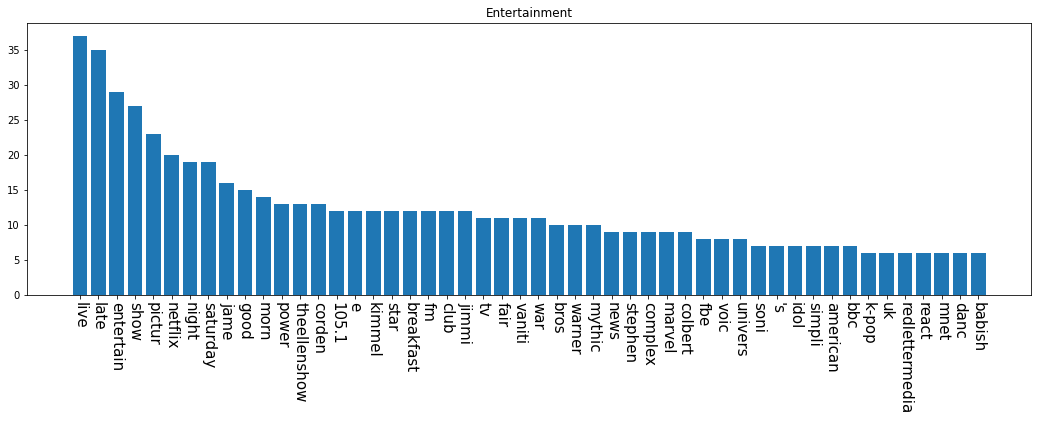

Category 'Music' Attr: 'channel_titles' unique words: 540


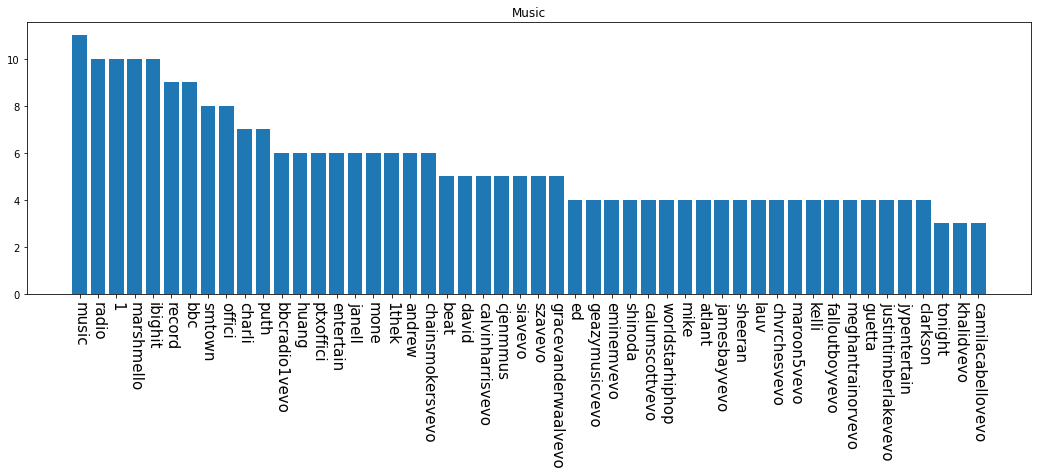

Category 'People & Blogs' Attr: 'channel_titles' unique words: 280


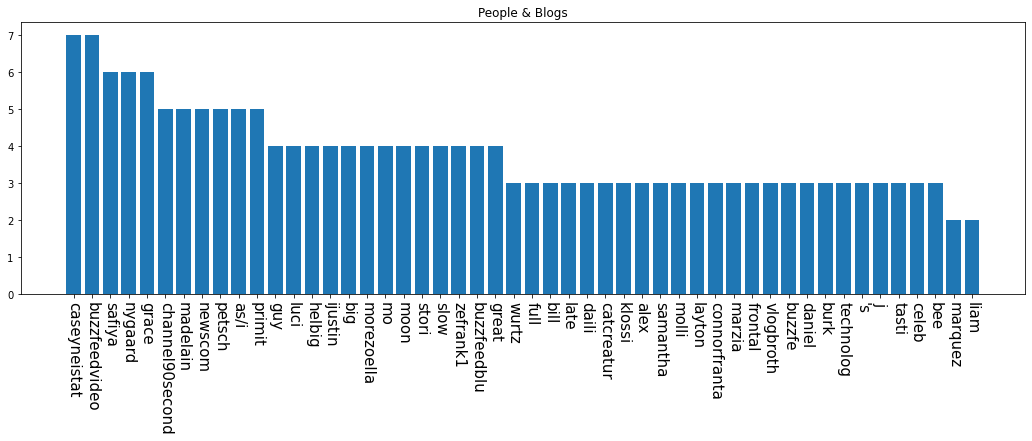

Category 'Howto & Style' Attr: 'channel_titles' unique words: 181


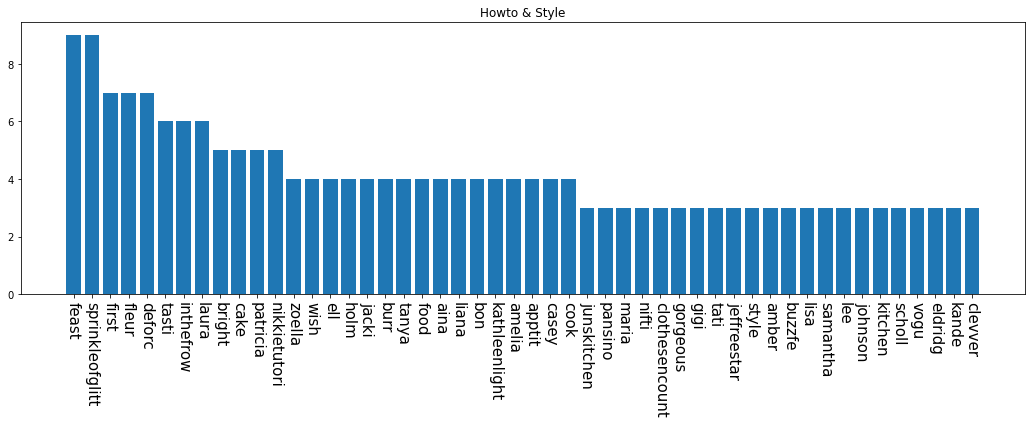

Category 'News & Politics' Attr: 'channel_titles' unique words: 105


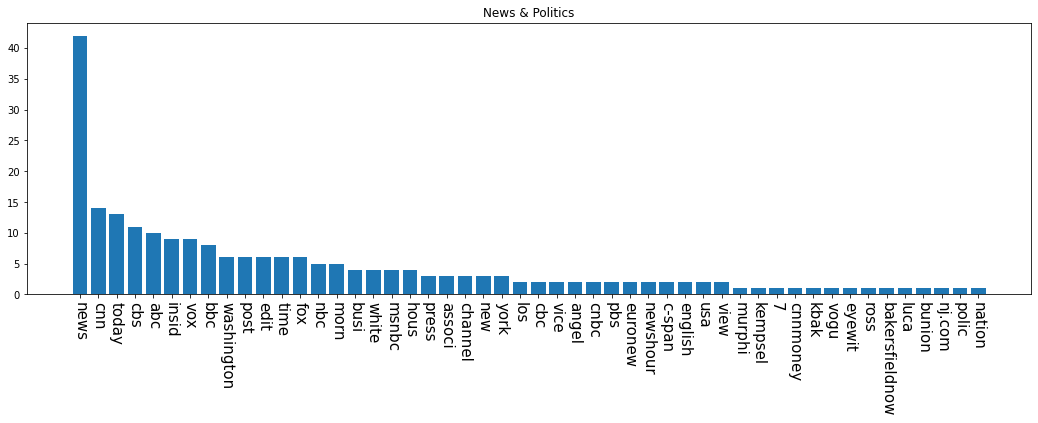

Category 'Comedy' Attr: 'channel_titles' unique words: 162


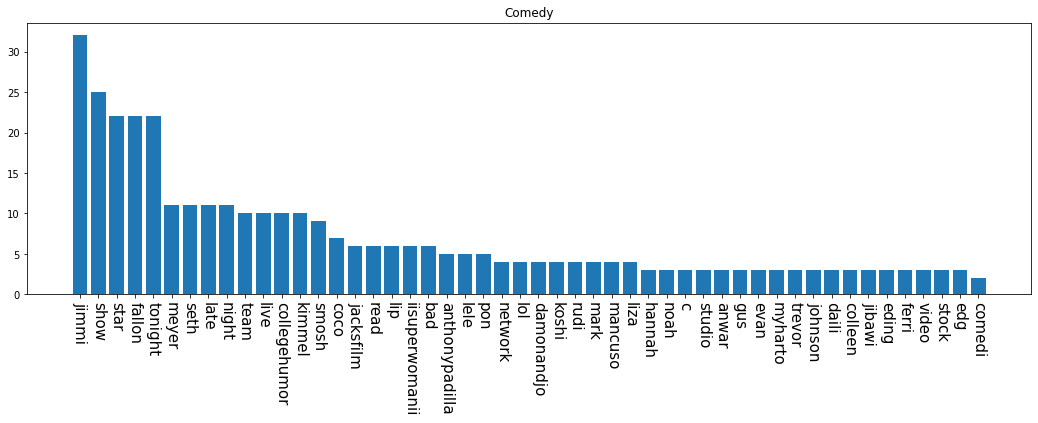

Category 'Sports' Attr: 'channel_titles' unique words: 139


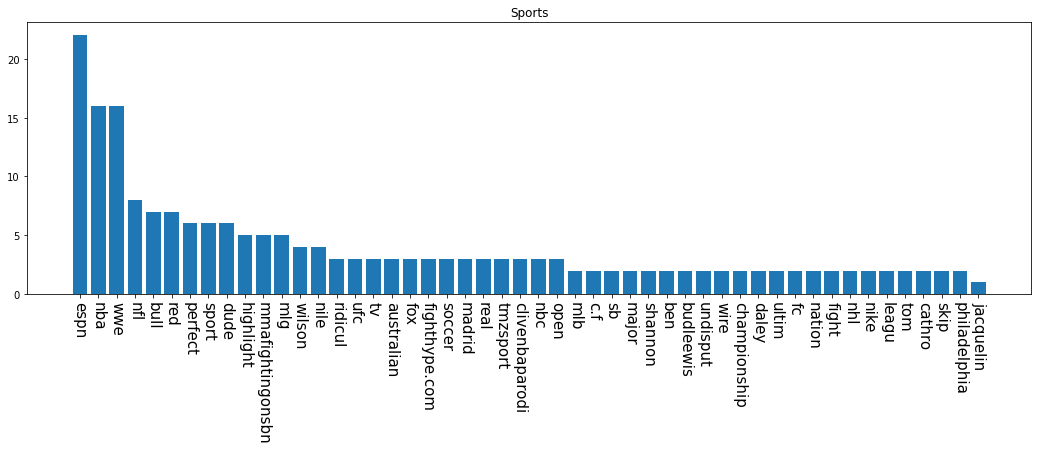

Category 'Travel & Events' Attr: 'channel_titles' unique words: 24


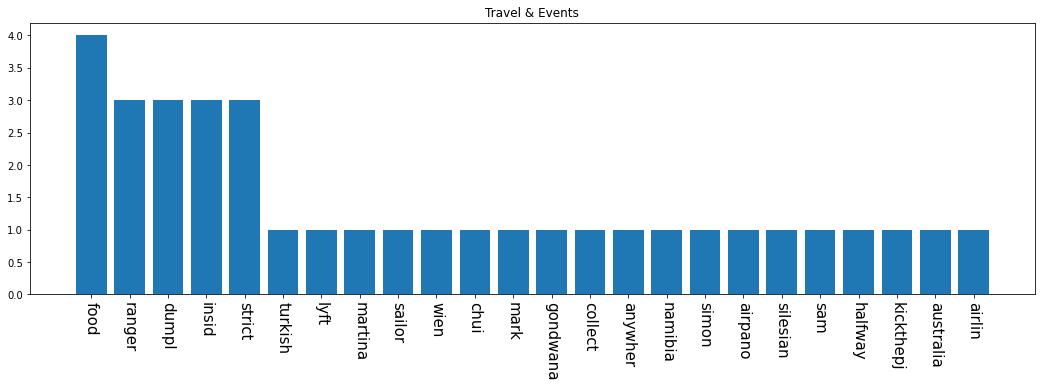

Category 'Gaming' Attr: 'channel_titles' unique words: 118


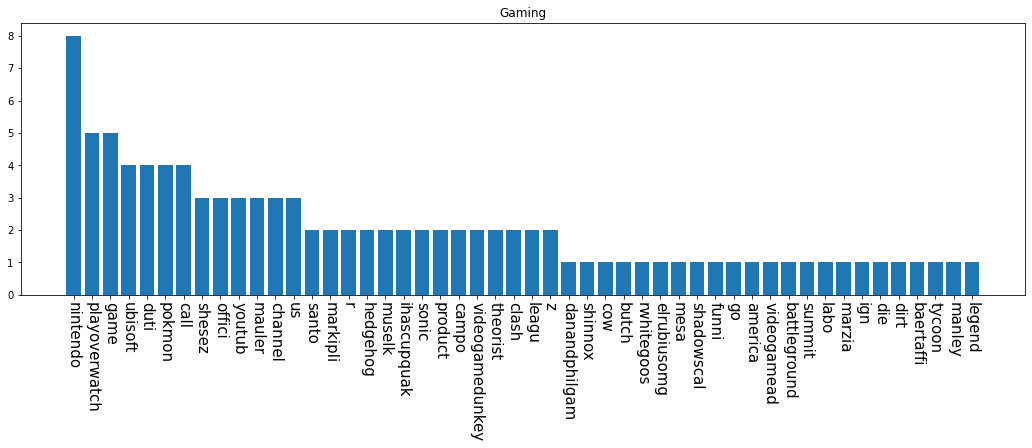

Category 'Education' Attr: 'channel_titles' unique words: 61


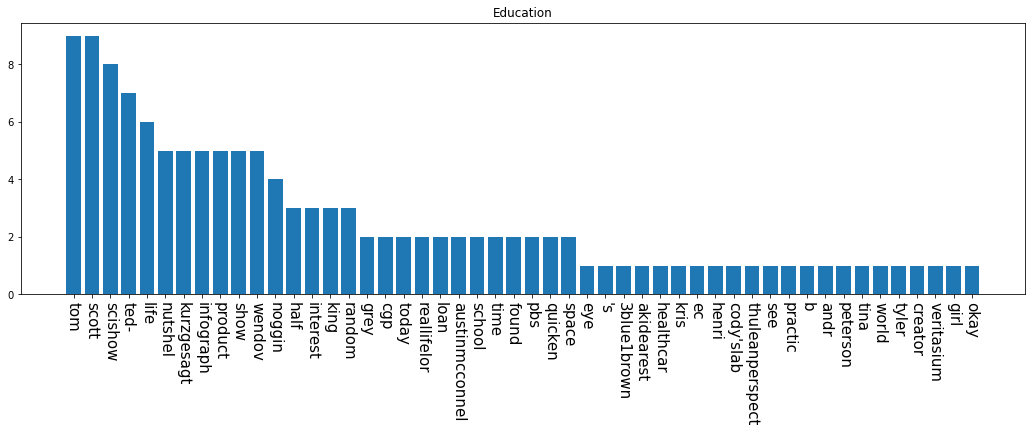

Category 'Pets & Animals' Attr: 'channel_titles' unique words: 61


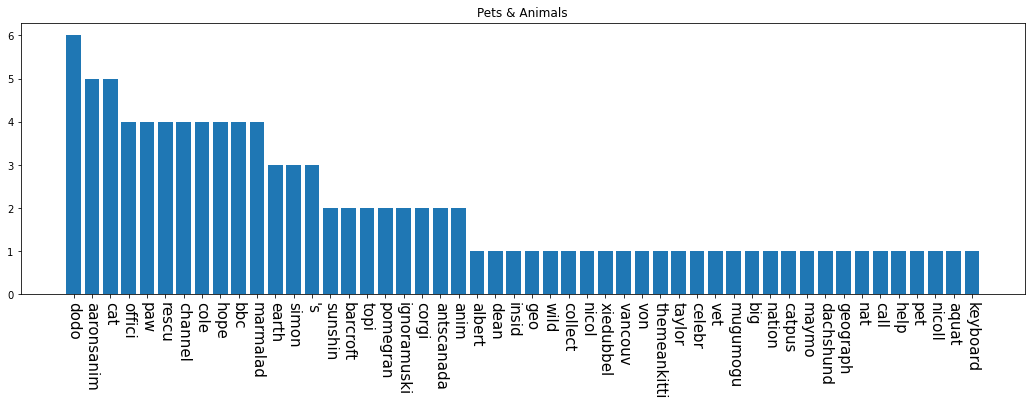

Category 'Science & Technology' Attr: 'channel_titles' unique words: 106


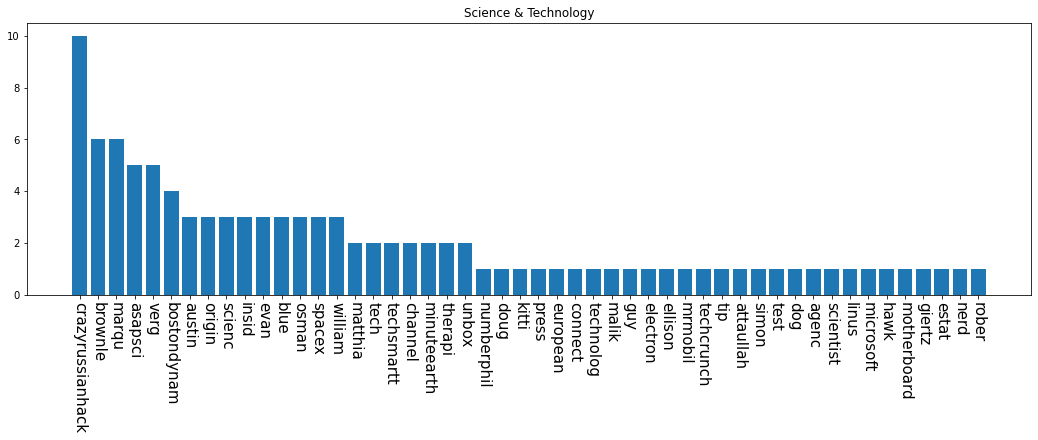

Category 'Film & Animation' Attr: 'channel_titles' unique words: 144


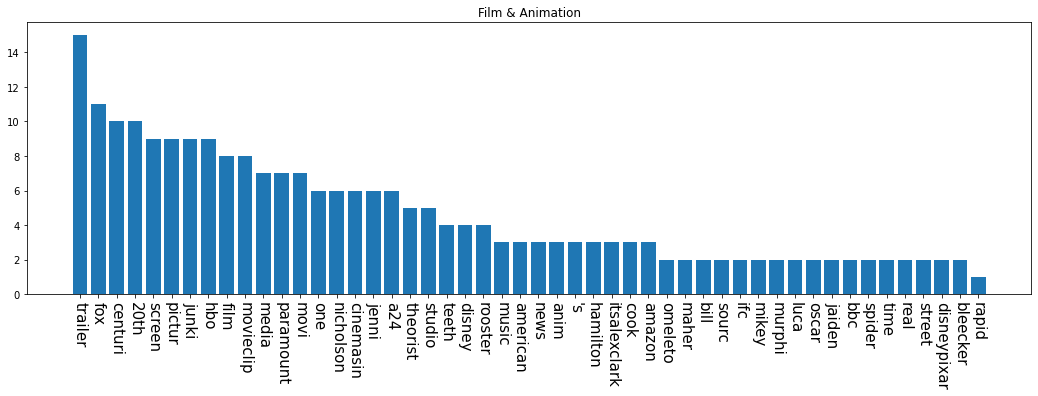

Category 'Autos & Vehicles' Attr: 'channel_titles' unique words: 25


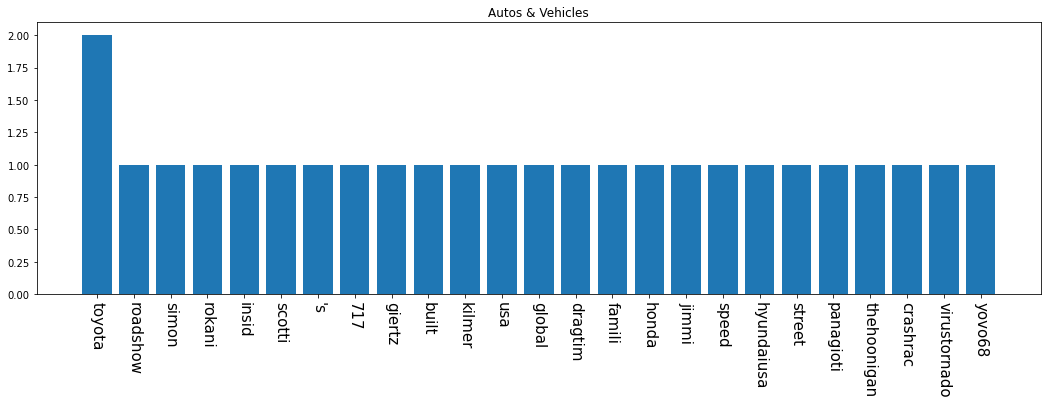

Category 'Nonprofits & Activism' Attr: 'channel_titles' unique words: 8


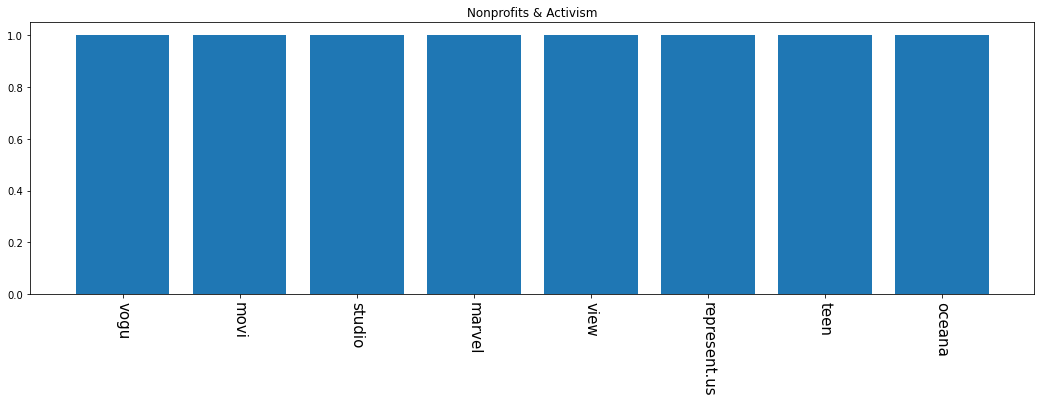

Category 'Shows' Attr: 'channel_titles' unique words: 3


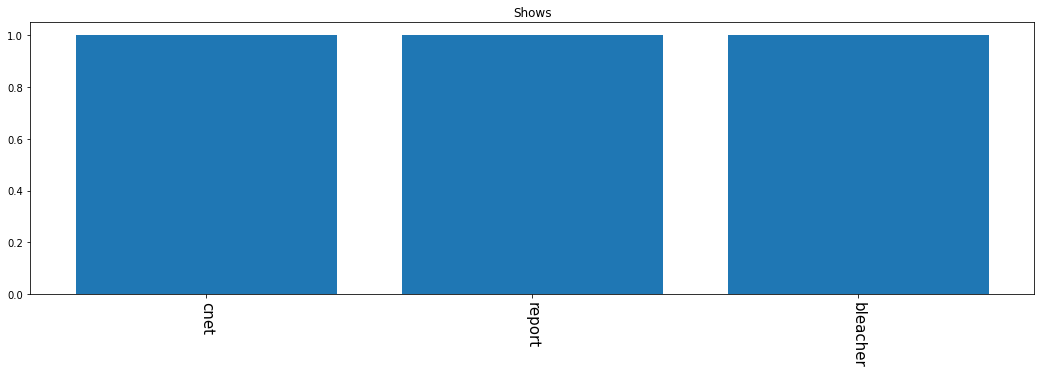

In [149]:
plot_categories_bars(categories, "channel_titles")

## Tytuł filmu

Category 'Entertainment' Attr: 'titles' unique words: 2108


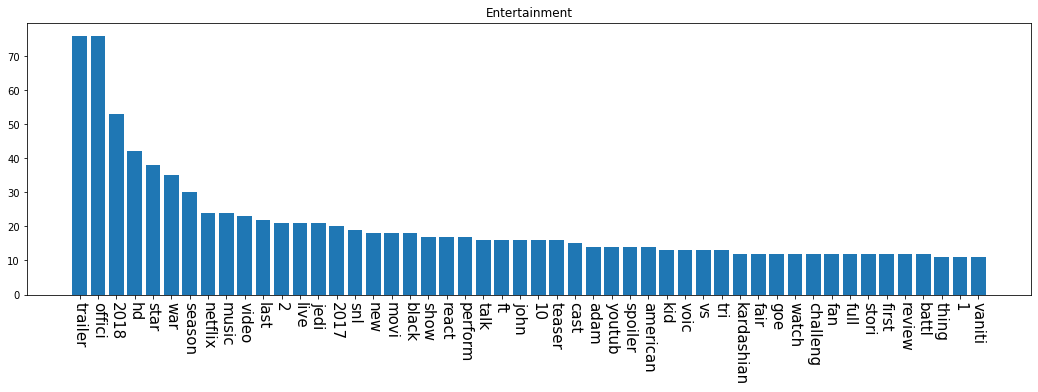

Category 'Music' Attr: 'titles' unique words: 1549


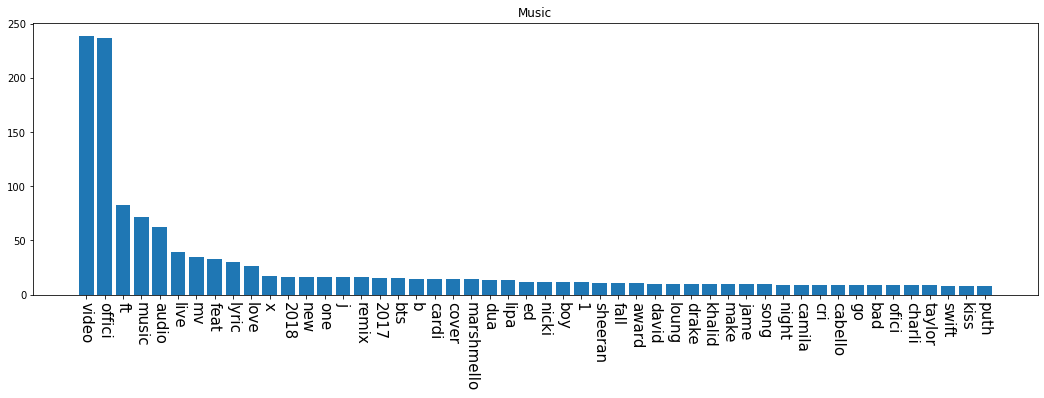

Category 'People & Blogs' Attr: 'titles' unique words: 899


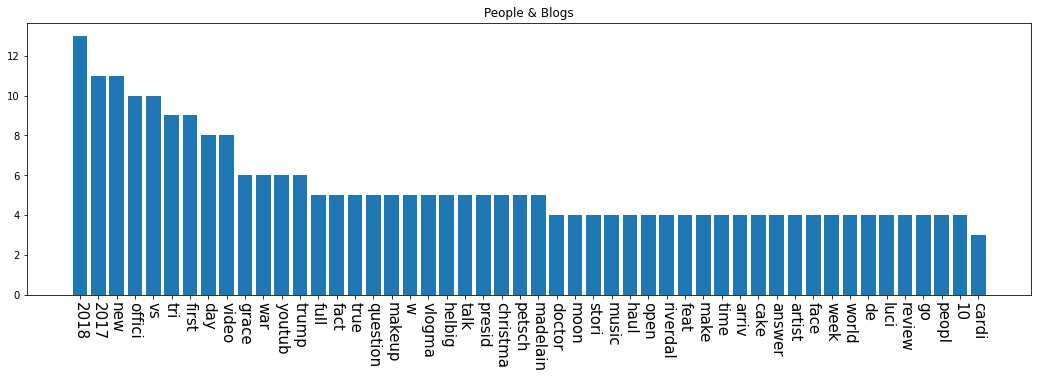

Category 'Howto & Style' Attr: 'titles' unique words: 791


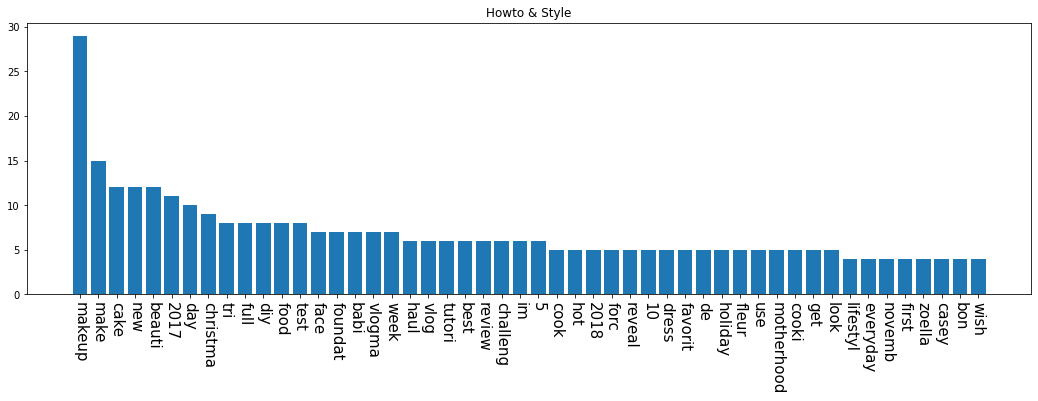

Category 'News & Politics' Attr: 'titles' unique words: 768


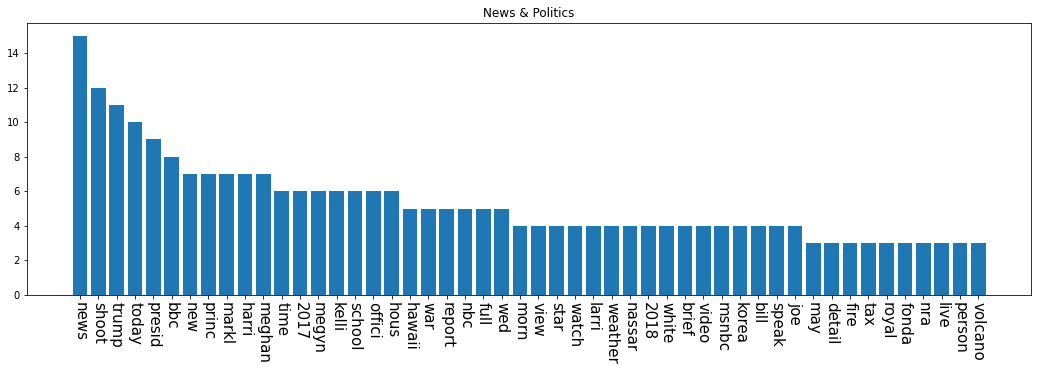

Category 'Comedy' Attr: 'titles' unique words: 759


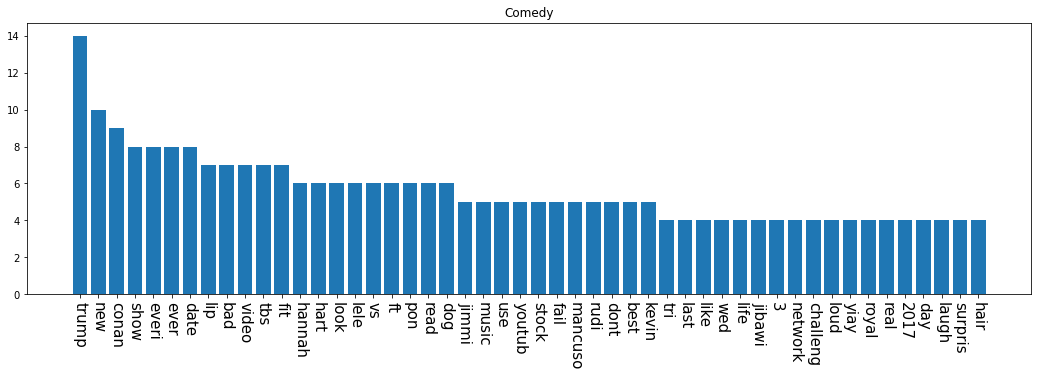

Category 'Sports' Attr: 'titles' unique words: 874


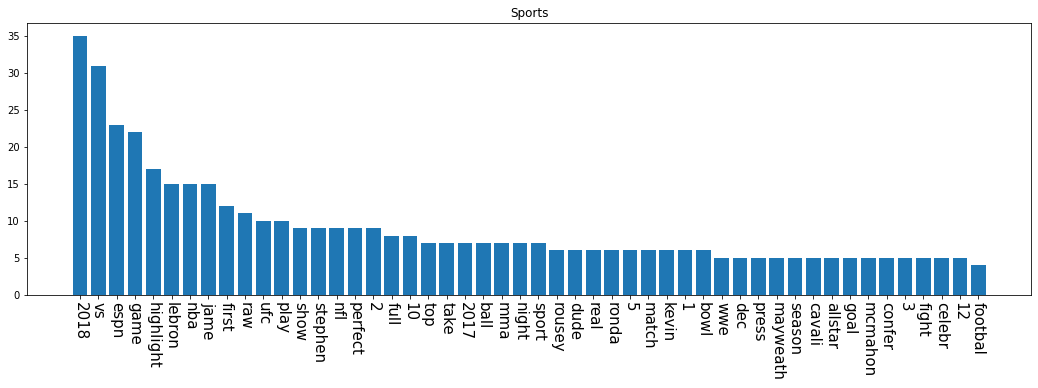

Category 'Travel & Events' Attr: 'titles' unique words: 111


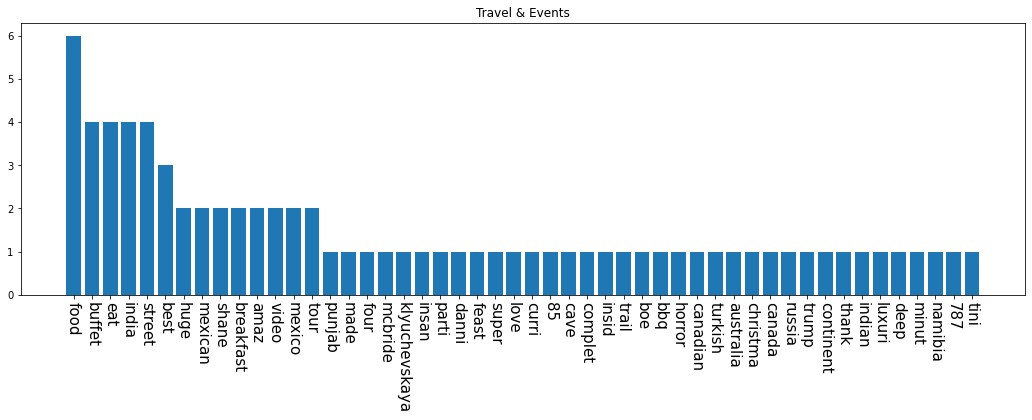

Category 'Gaming' Attr: 'titles' unique words: 440


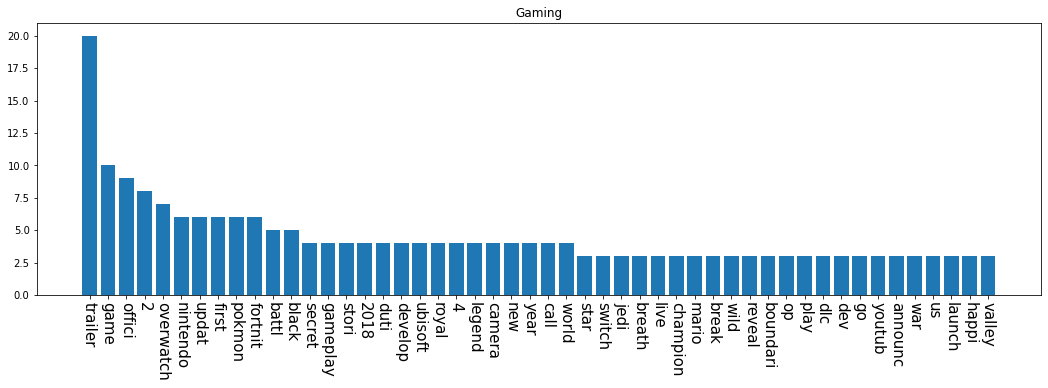

Category 'Education' Attr: 'titles' unique words: 301


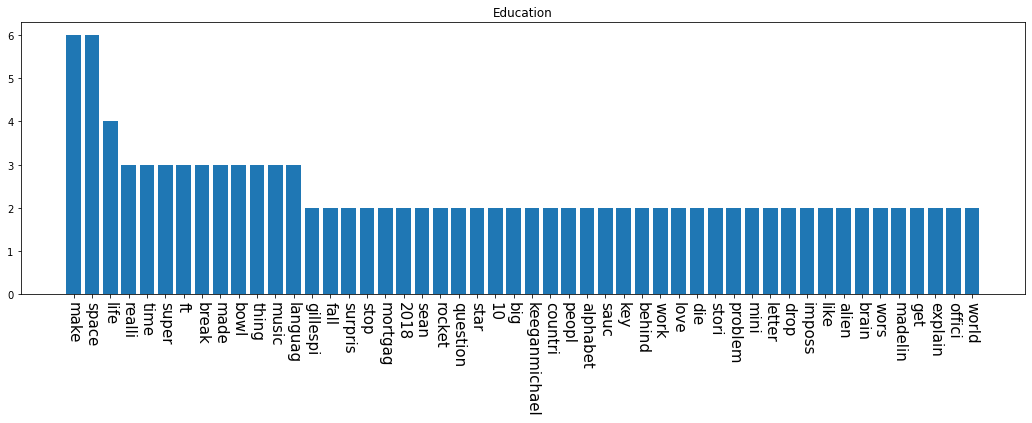

Category 'Pets & Animals' Attr: 'titles' unique words: 212


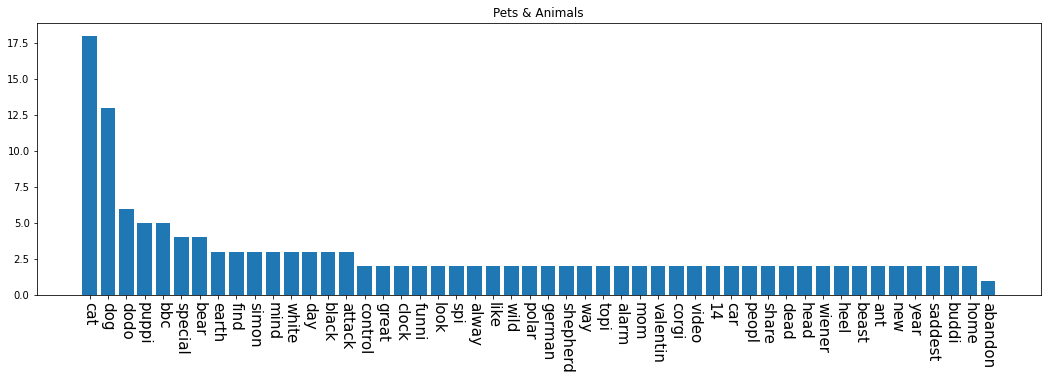

Category 'Science & Technology' Attr: 'titles' unique words: 401


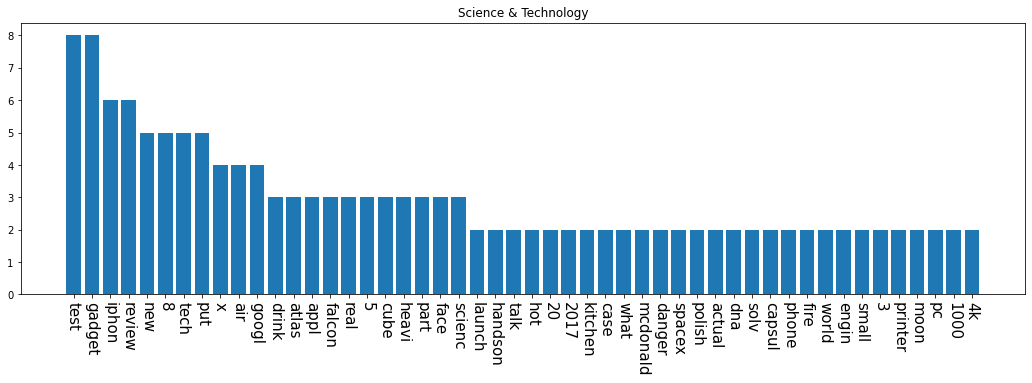

Category 'Film & Animation' Attr: 'titles' unique words: 568


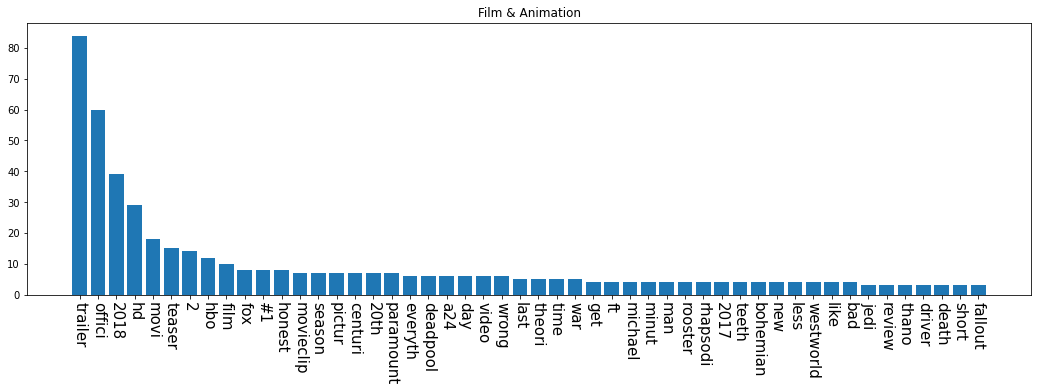

Category 'Autos & Vehicles' Attr: 'titles' unique words: 104


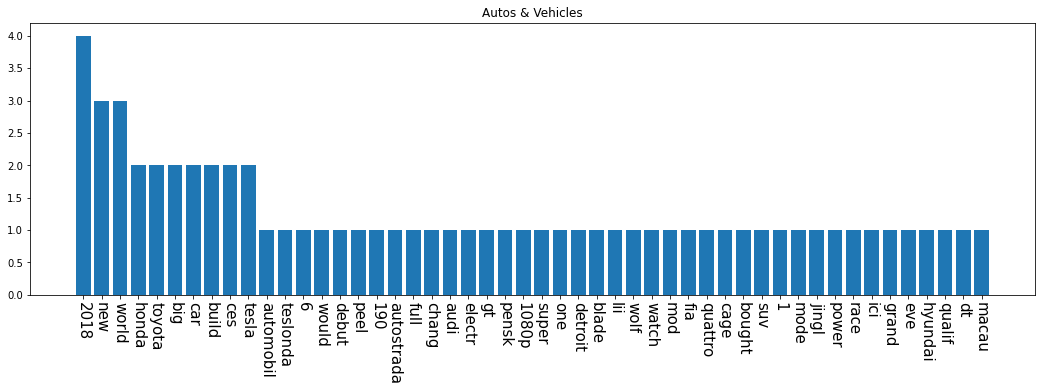

Category 'Nonprofits & Activism' Attr: 'titles' unique words: 34


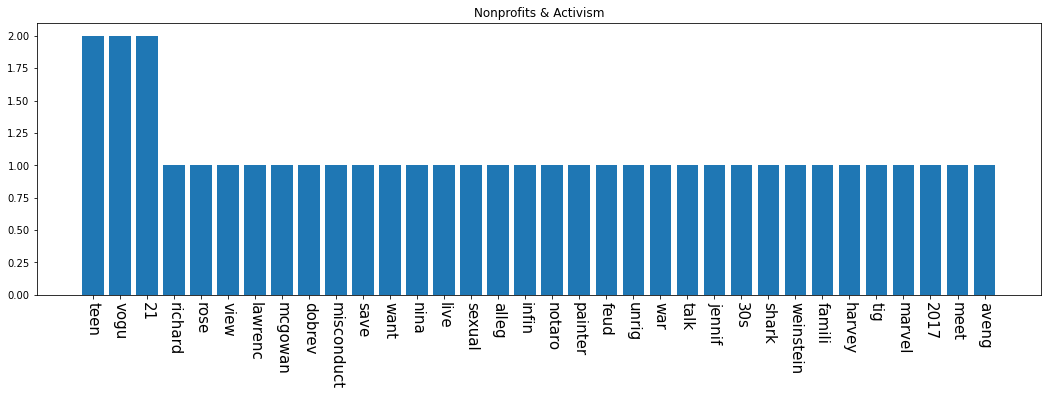

Category 'Shows' Attr: 'titles' unique words: 12


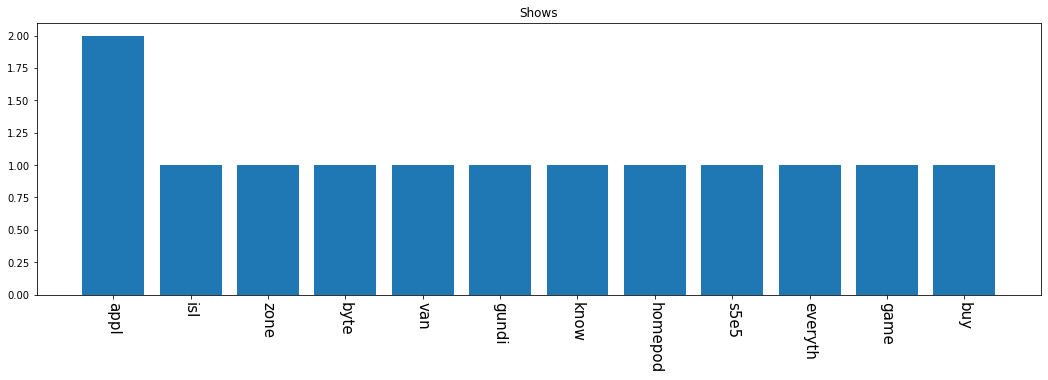

In [150]:
plot_categories_bars(categories, "titles")

## Opisy filmów

Category 'Entertainment' Attr: 'descriptions' unique words: 11357


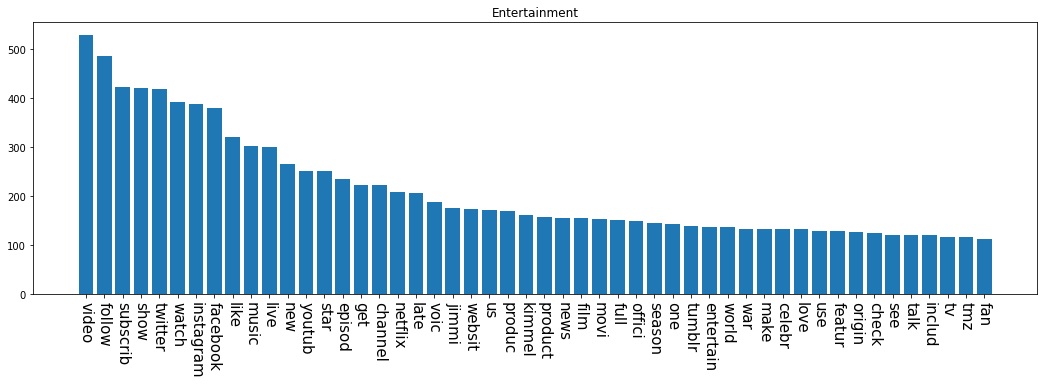

Category 'Music' Attr: 'descriptions' unique words: 11529


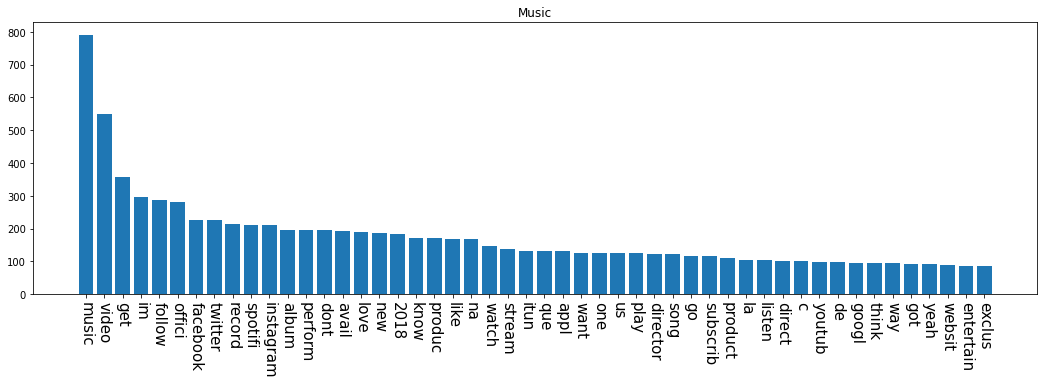

Category 'People & Blogs' Attr: 'descriptions' unique words: 6058


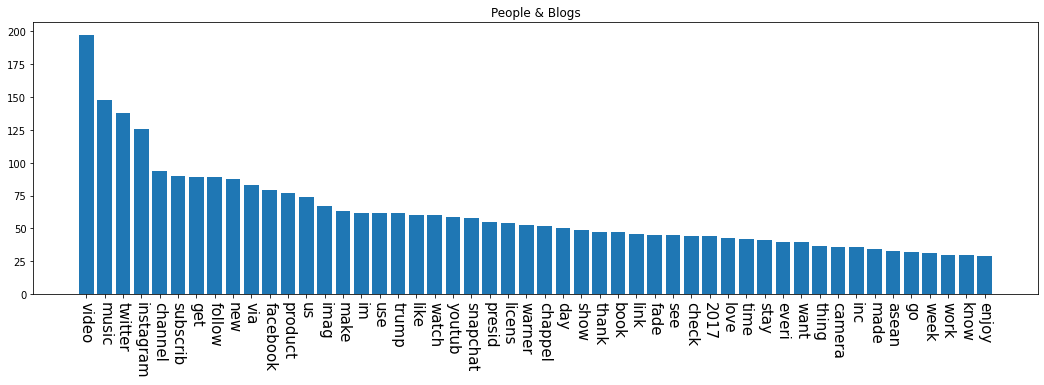

Category 'Howto & Style' Attr: 'descriptions' unique words: 7011


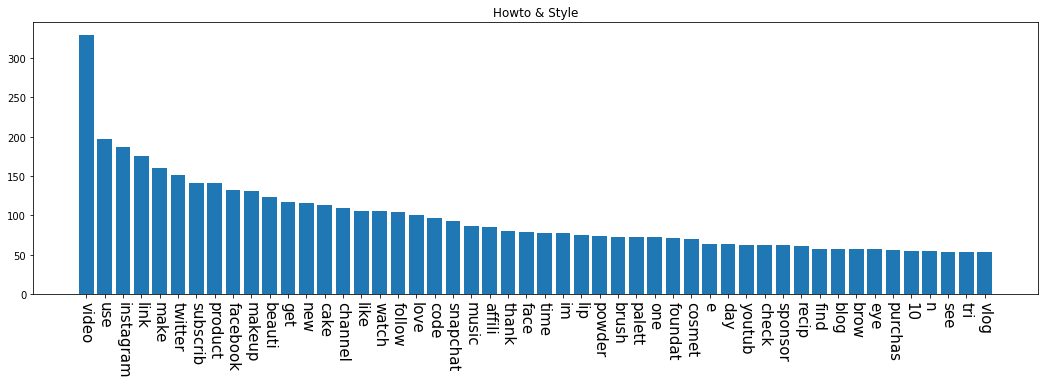

Category 'News & Politics' Attr: 'descriptions' unique words: 2900


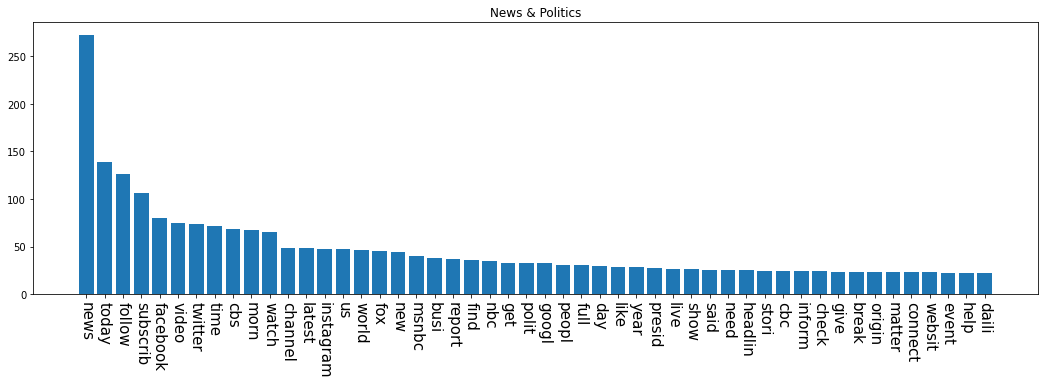

Category 'Comedy' Attr: 'descriptions' unique words: 4420


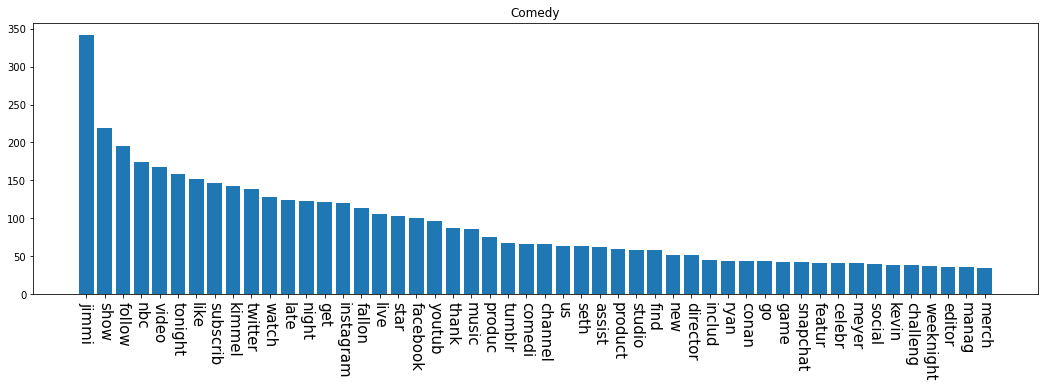

Category 'Sports' Attr: 'descriptions' unique words: 3494


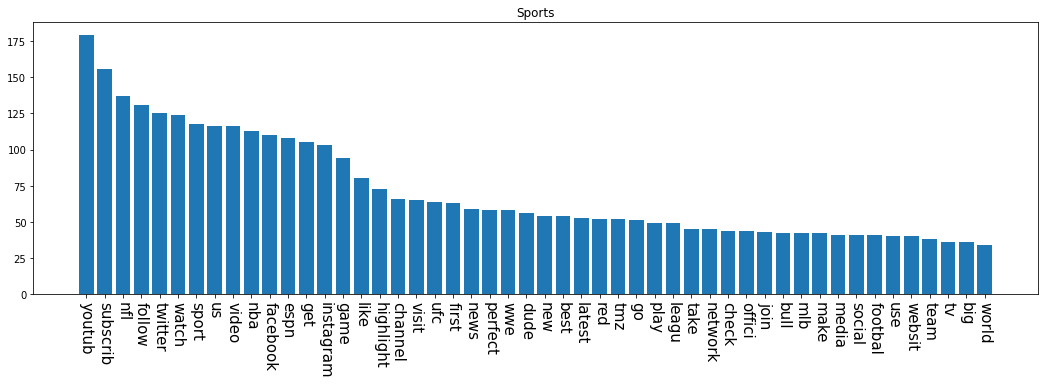

Category 'Travel & Events' Attr: 'descriptions' unique words: 910


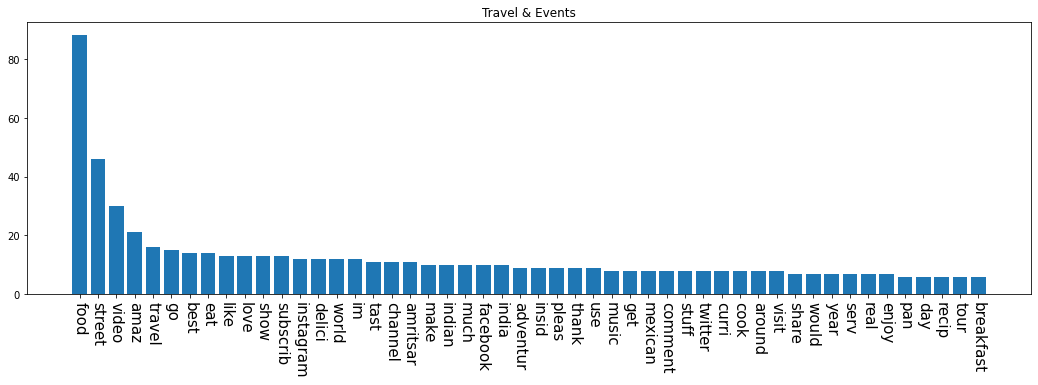

Category 'Gaming' Attr: 'descriptions' unique words: 2719


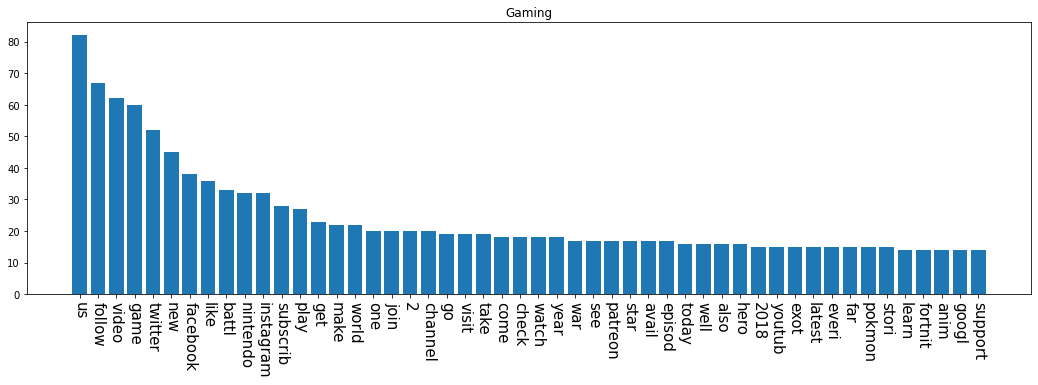

Category 'Education' Attr: 'descriptions' unique words: 3723


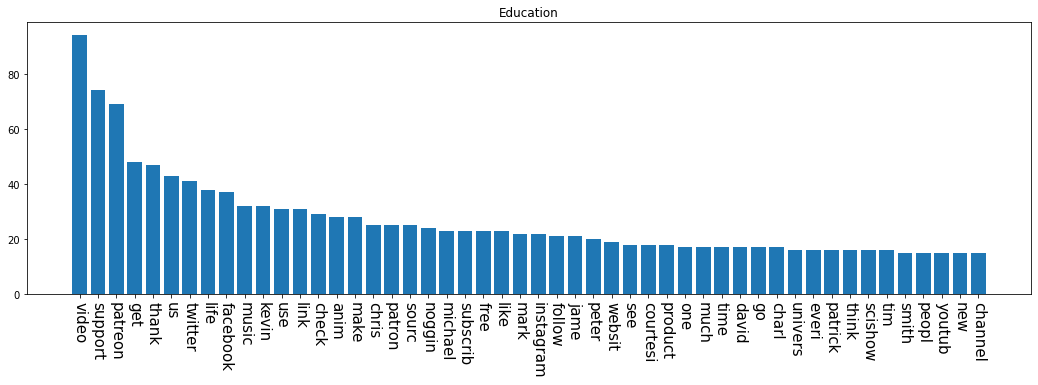

Category 'Pets & Animals' Attr: 'descriptions' unique words: 1345


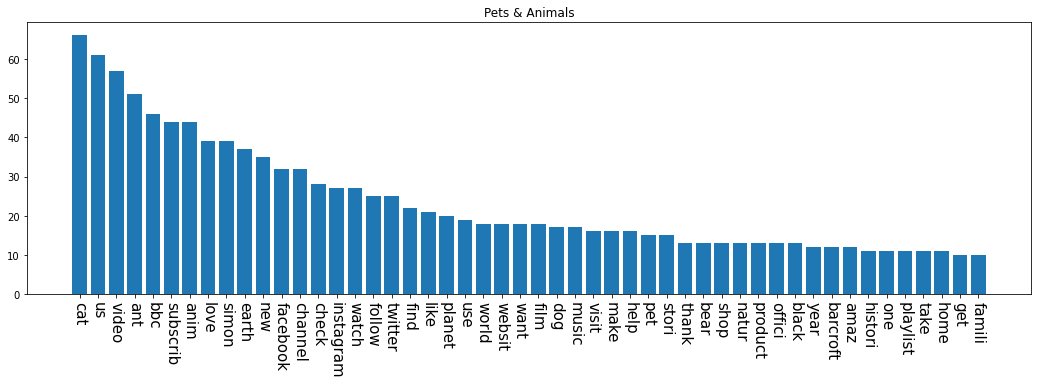

Category 'Science & Technology' Attr: 'descriptions' unique words: 3351


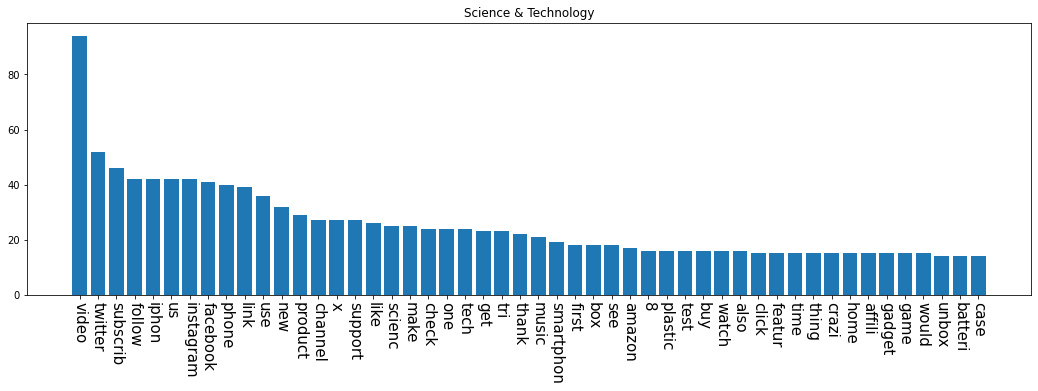

Category 'Film & Animation' Attr: 'descriptions' unique words: 4791


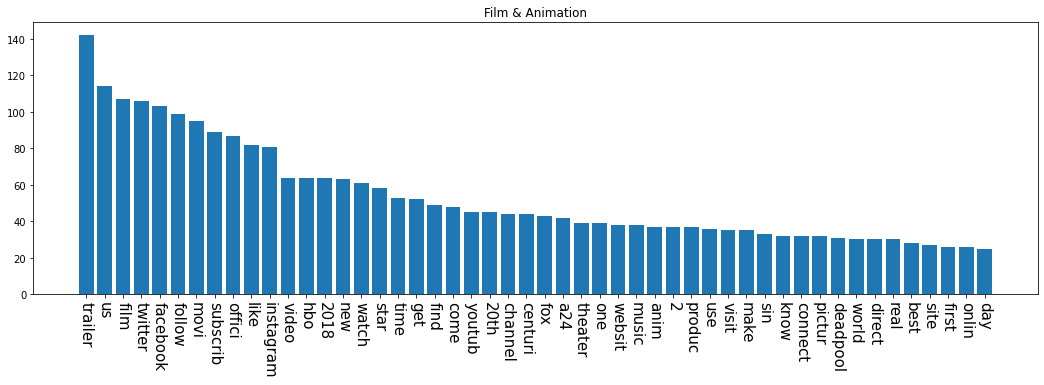

Category 'Autos & Vehicles' Attr: 'descriptions' unique words: 670


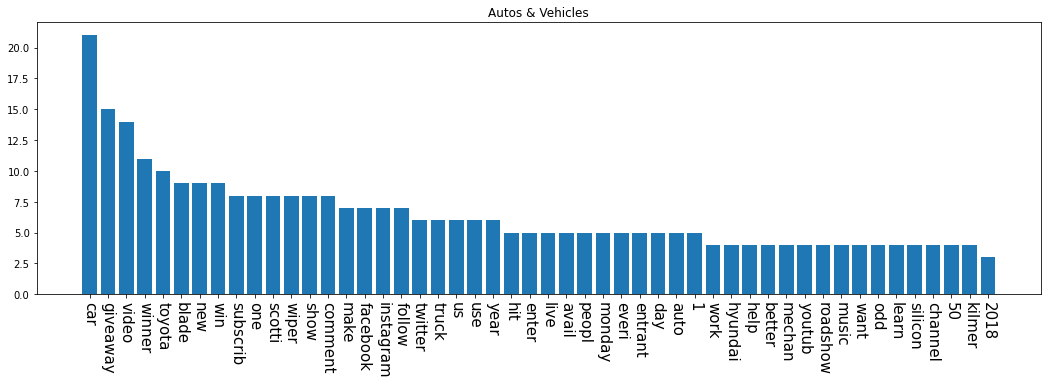

Category 'Nonprofits & Activism' Attr: 'descriptions' unique words: 103


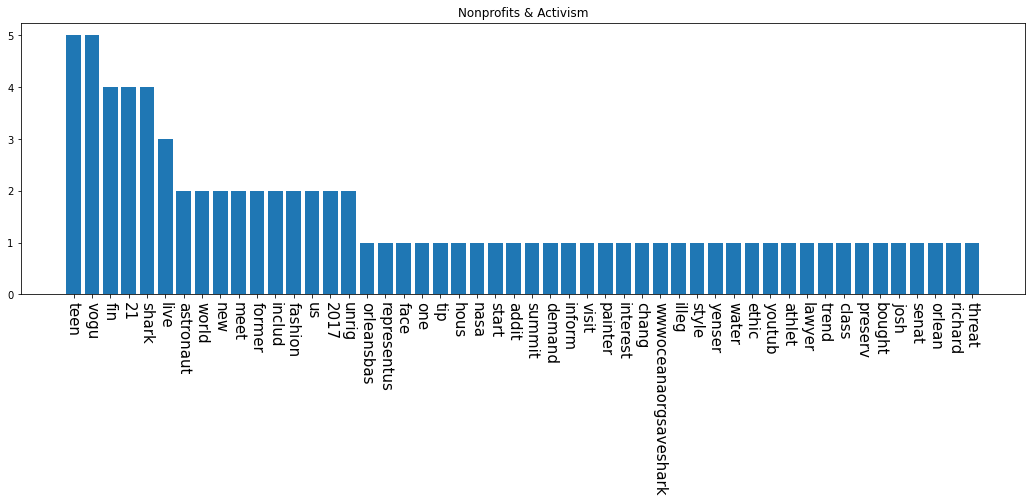

Category 'Shows' Attr: 'descriptions' unique words: 56


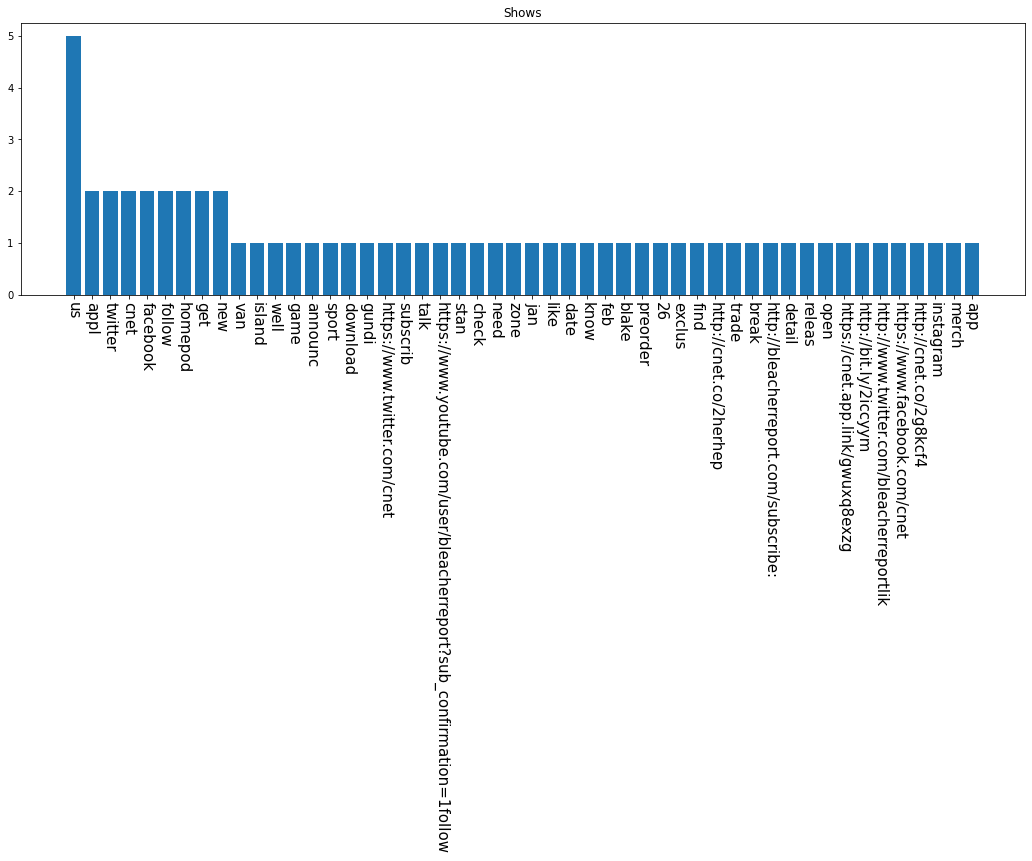

In [151]:
plot_categories_bars(categories, "descriptions")

## OCR

Category 'Entertainment' Attr: 'ocr_text' unique words: 135


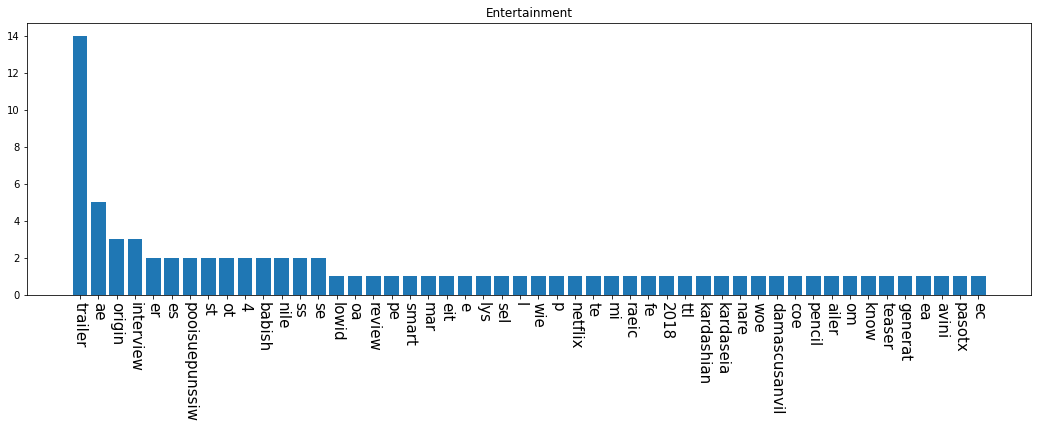

Category 'Music' Attr: 'ocr_text' unique words: 99


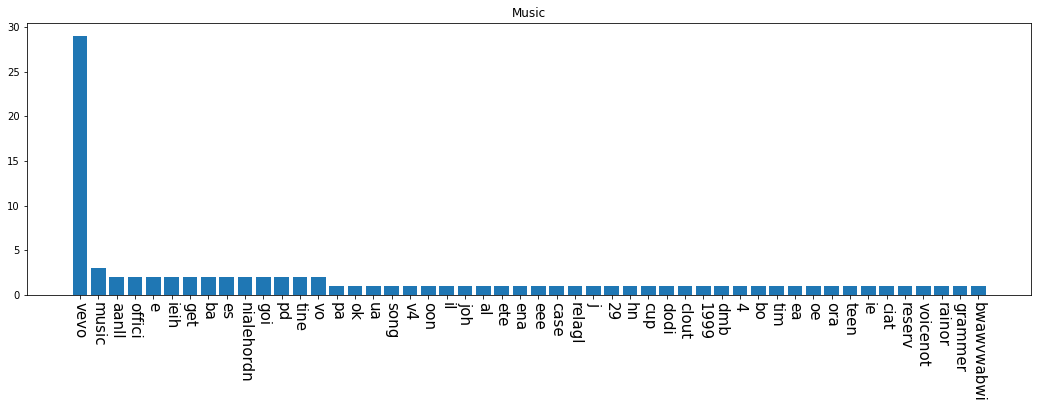

Category 'People & Blogs' Attr: 'ocr_text' unique words: 31


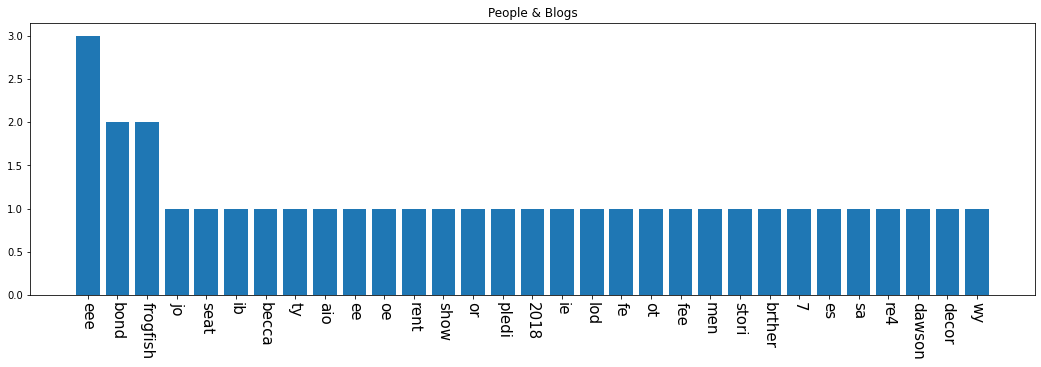

Category 'Howto & Style' Attr: 'ocr_text' unique words: 39


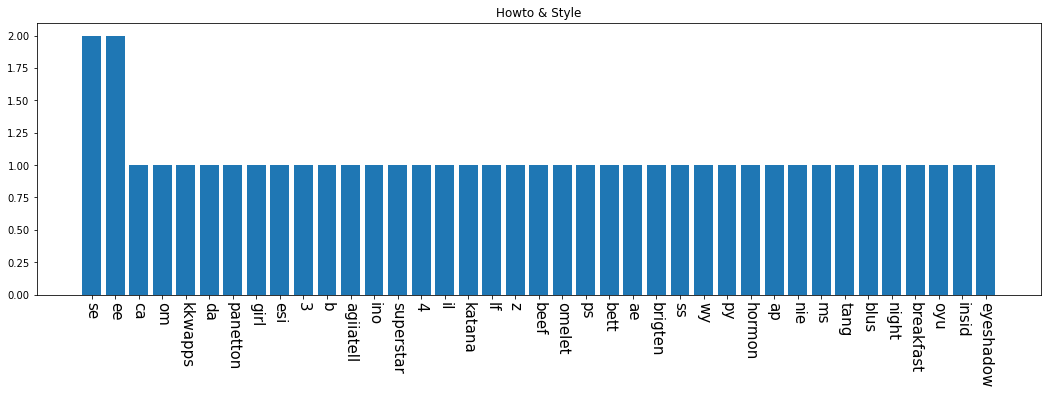

Category 'News & Politics' Attr: 'ocr_text' unique words: 29


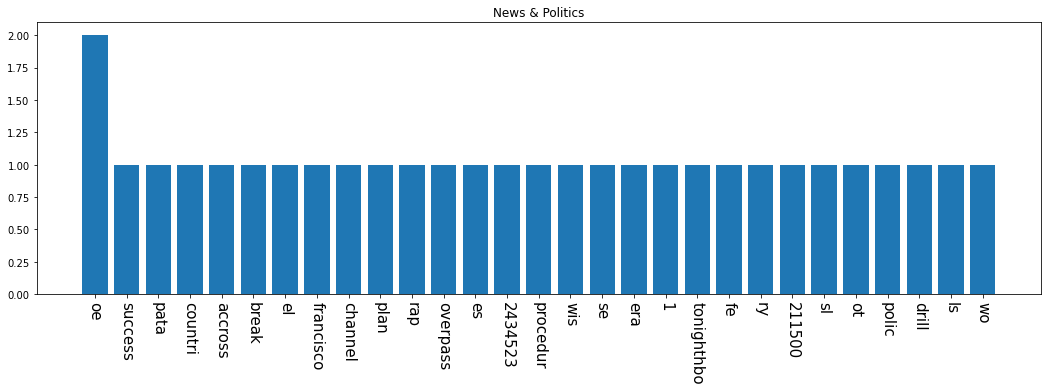

Category 'Comedy' Attr: 'ocr_text' unique words: 41


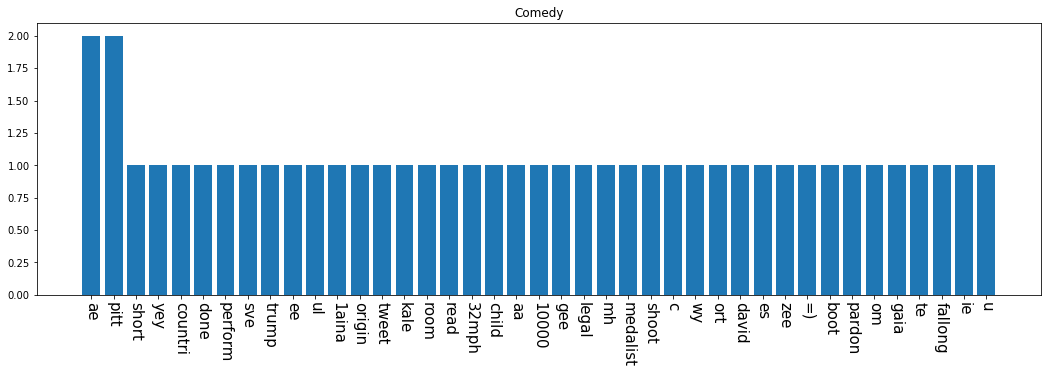

Category 'Sports' Attr: 'ocr_text' unique words: 38


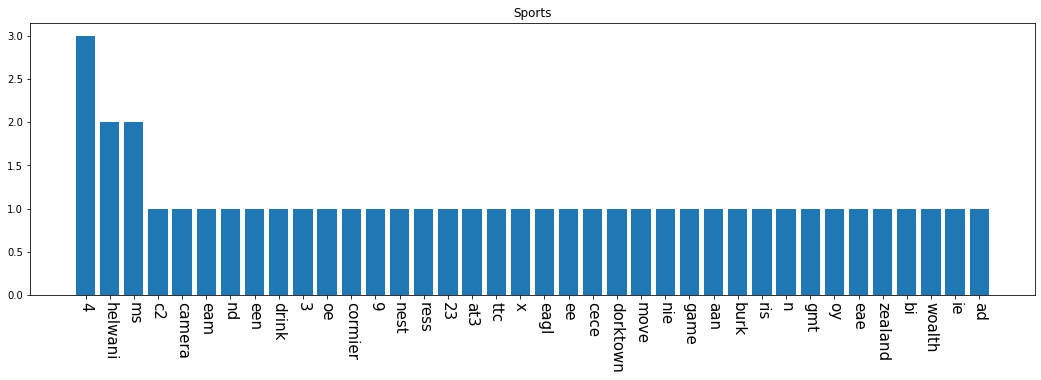

Category 'Travel & Events' Attr: 'ocr_text' unique words: 3


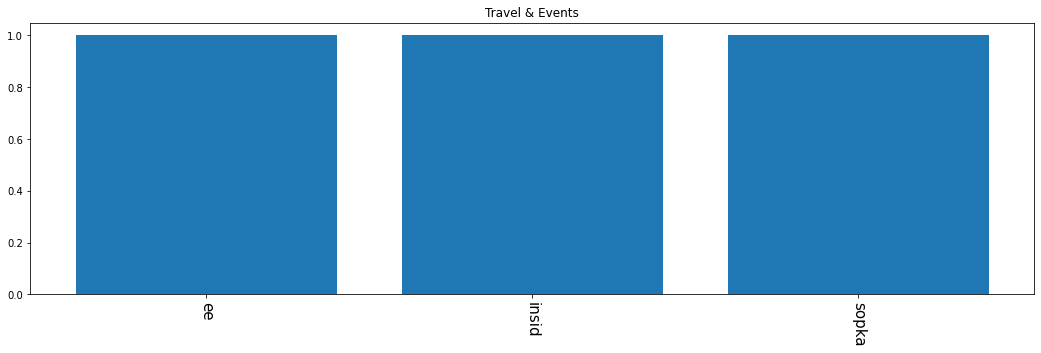

Category 'Gaming' Attr: 'ocr_text' unique words: 35


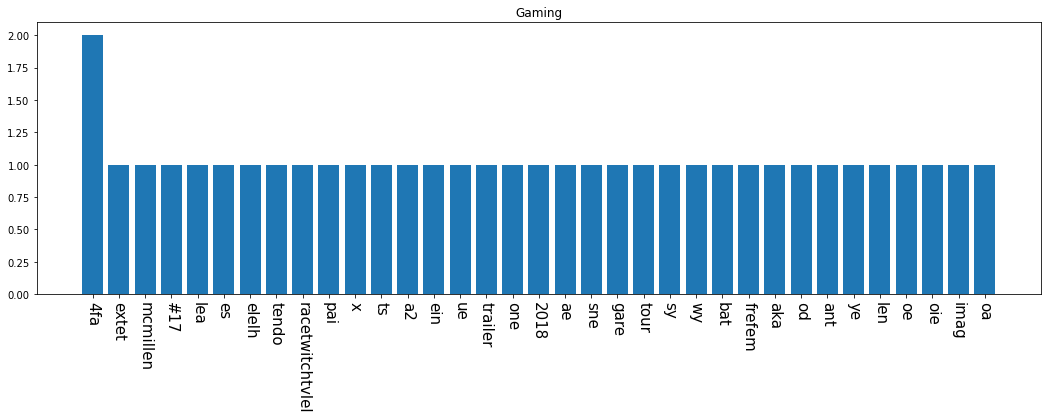

Category 'Education' Attr: 'ocr_text' unique words: 35


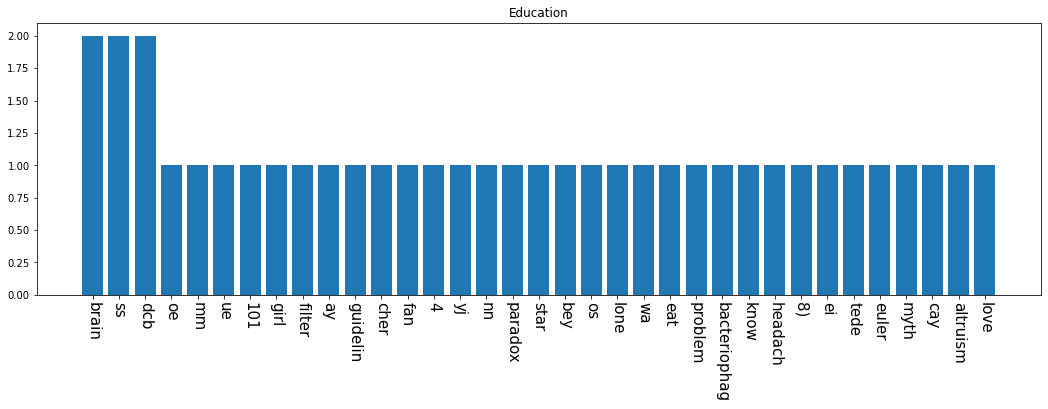

Category 'Pets & Animals' Attr: 'ocr_text' unique words: 5


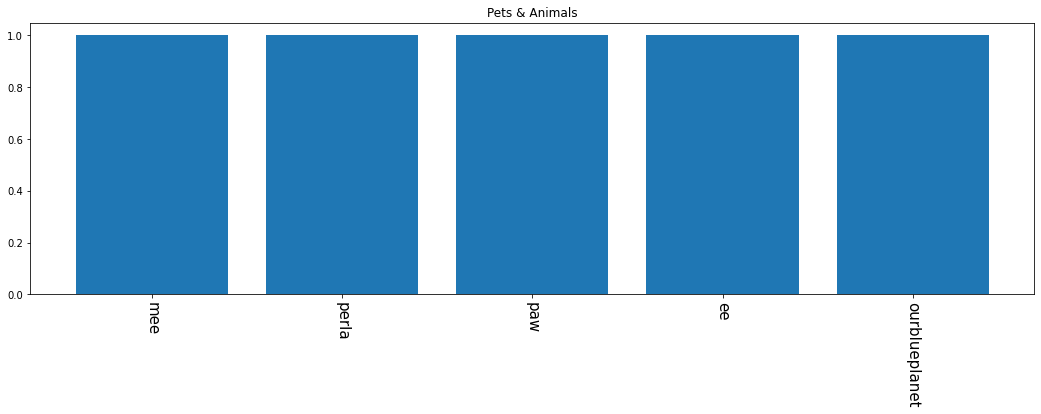

Category 'Science & Technology' Attr: 'ocr_text' unique words: 28


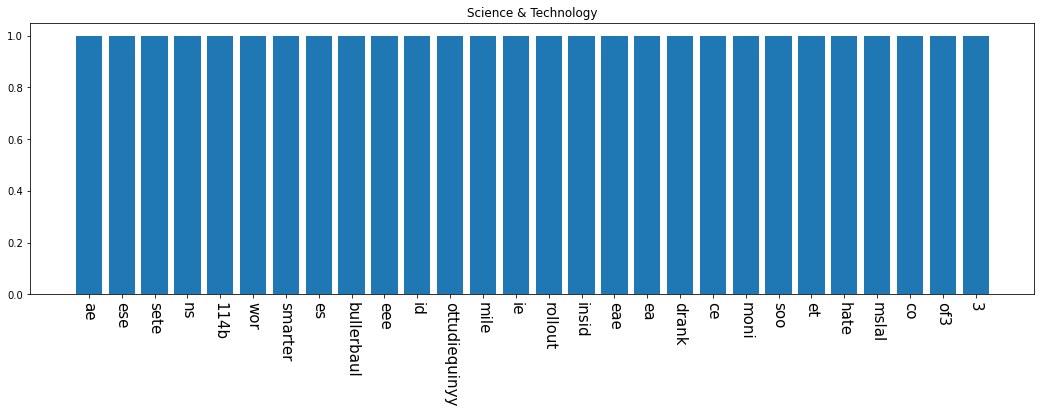

Category 'Film & Animation' Attr: 'ocr_text' unique words: 42


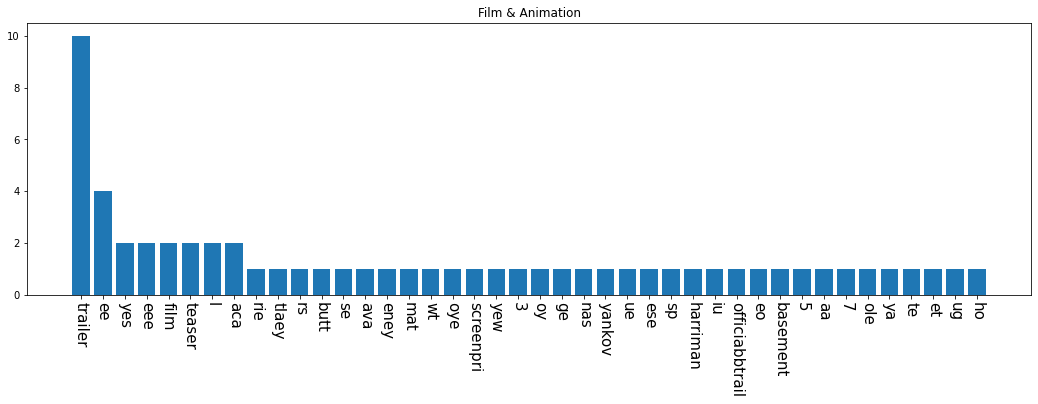

Category 'Autos & Vehicles' Attr: 'ocr_text' unique words: 2


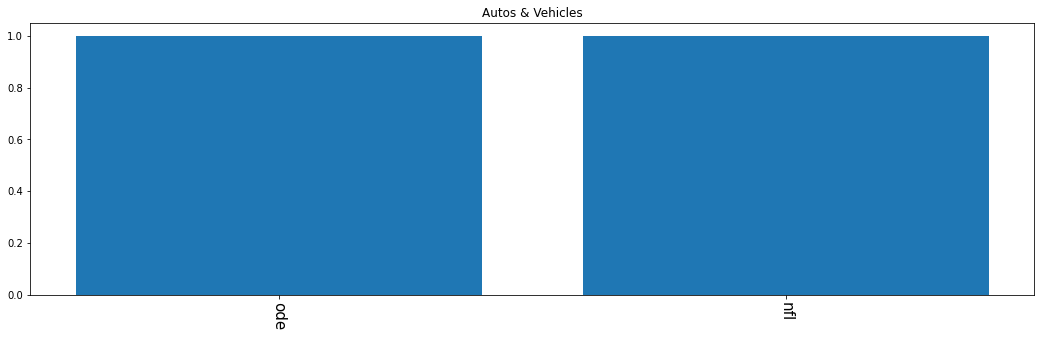

Category 'Nonprofits & Activism' Attr: 'ocr_text' unique words: 1


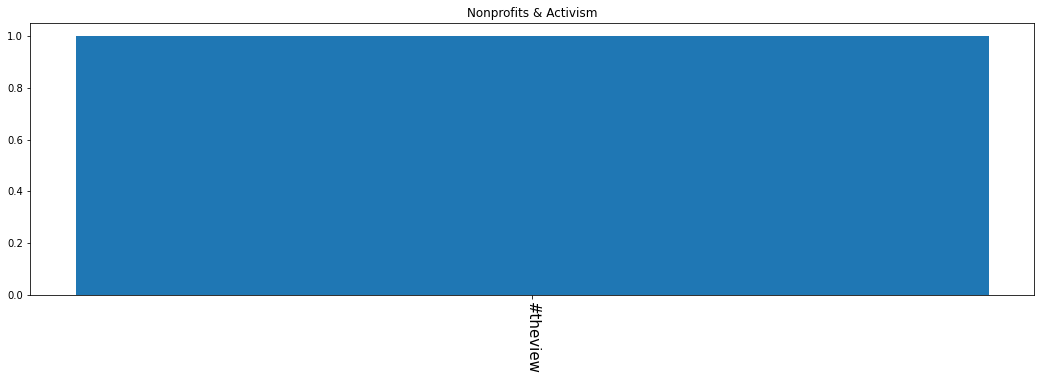

Category 'Shows' Attr: 'ocr_text' unique words: 0


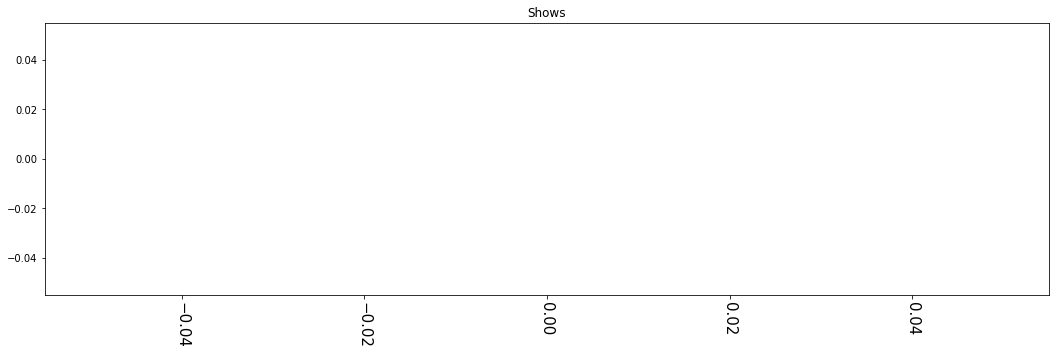

In [152]:
plot_categories_bars(categories, "ocr_text")

## Filtered OCR

Category 'Entertainment' Attr: 'filtered_ocr_text' unique words: 99


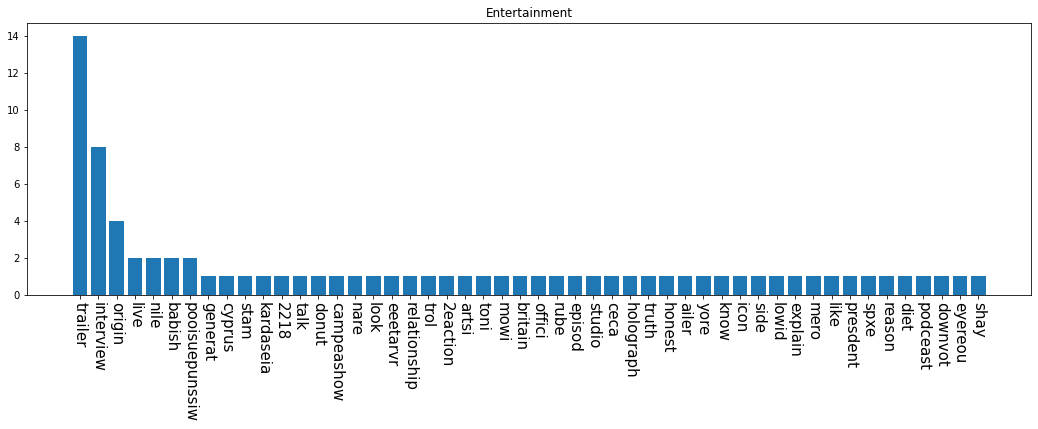

Category 'Music' Attr: 'filtered_ocr_text' unique words: 55


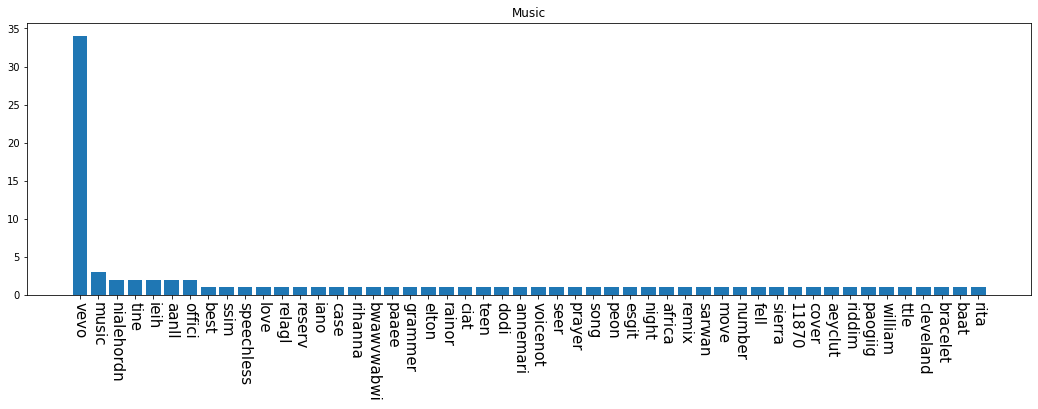

Category 'People & Blogs' Attr: 'filtered_ocr_text' unique words: 20


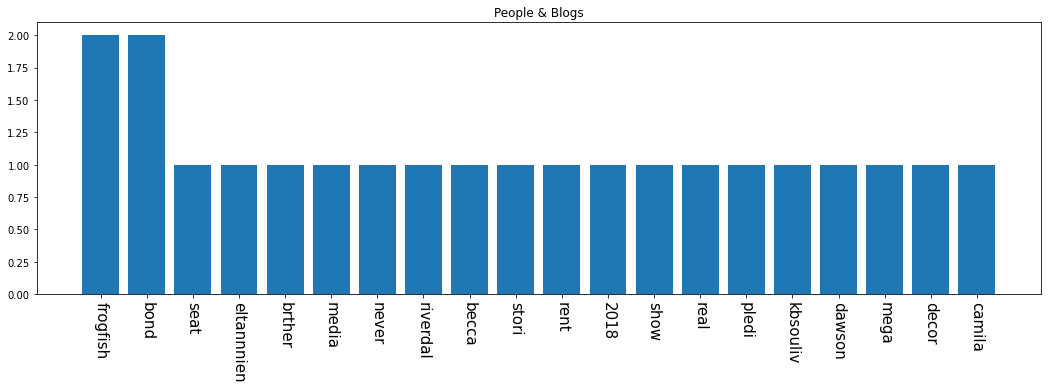

Category 'Howto & Style' Attr: 'filtered_ocr_text' unique words: 33


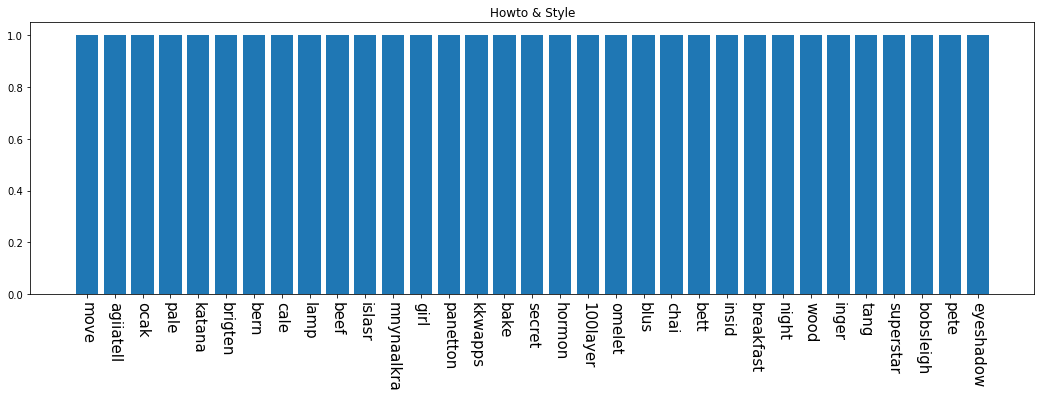

Category 'News & Politics' Attr: 'filtered_ocr_text' unique words: 24


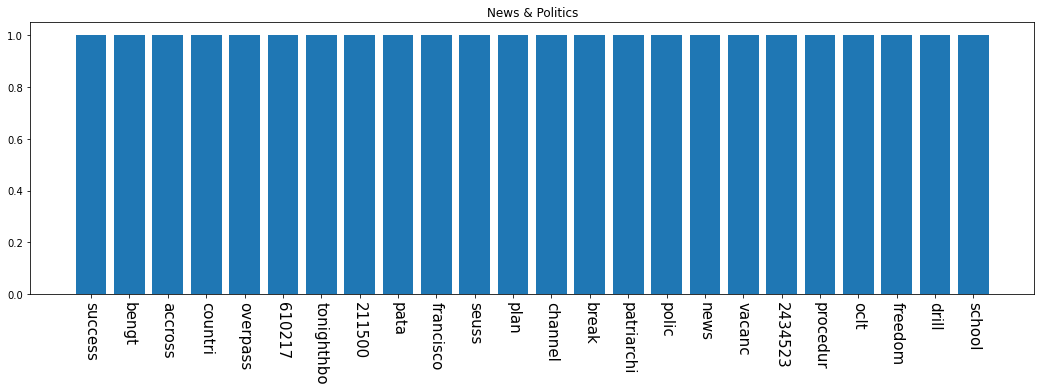

Category 'Comedy' Attr: 'filtered_ocr_text' unique words: 34


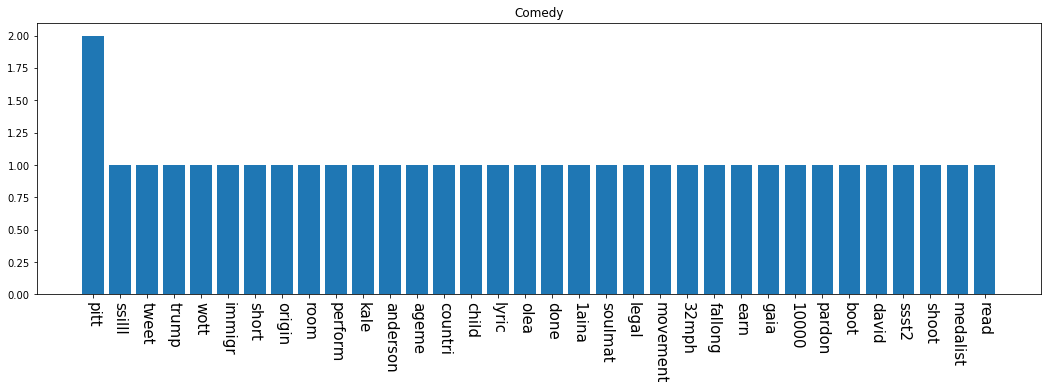

Category 'Sports' Attr: 'filtered_ocr_text' unique words: 28


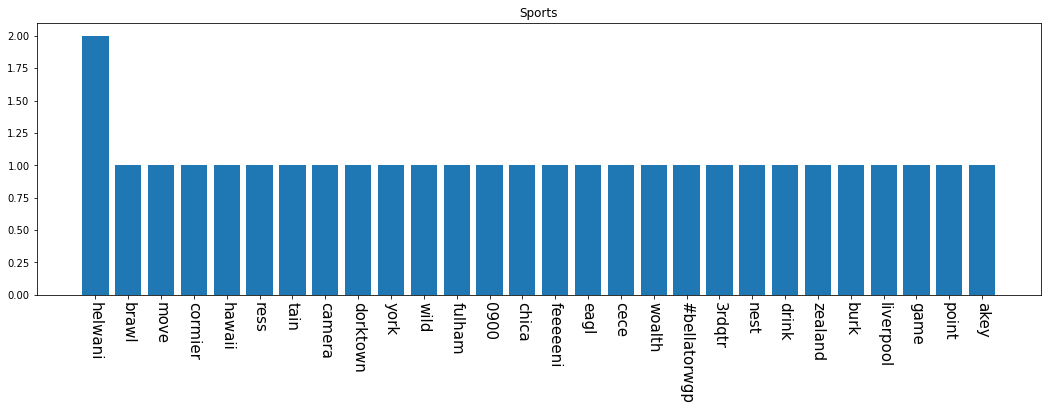

Category 'Travel & Events' Attr: 'filtered_ocr_text' unique words: 2


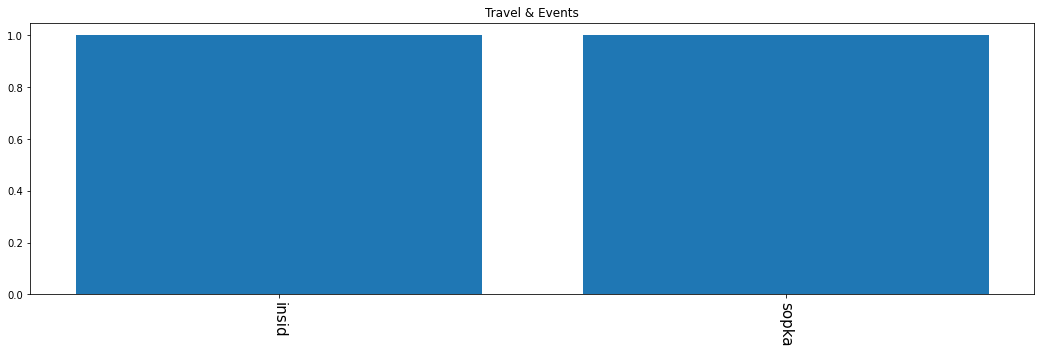

Category 'Gaming' Attr: 'filtered_ocr_text' unique words: 24


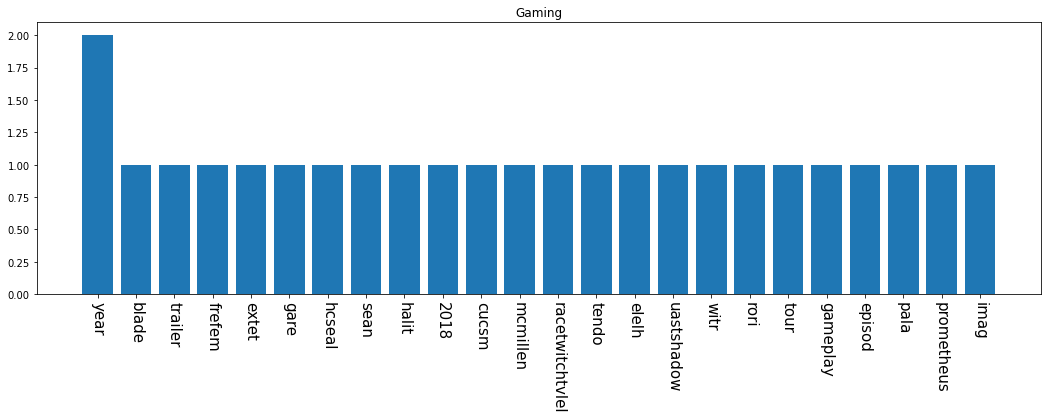

Category 'Education' Attr: 'filtered_ocr_text' unique words: 26


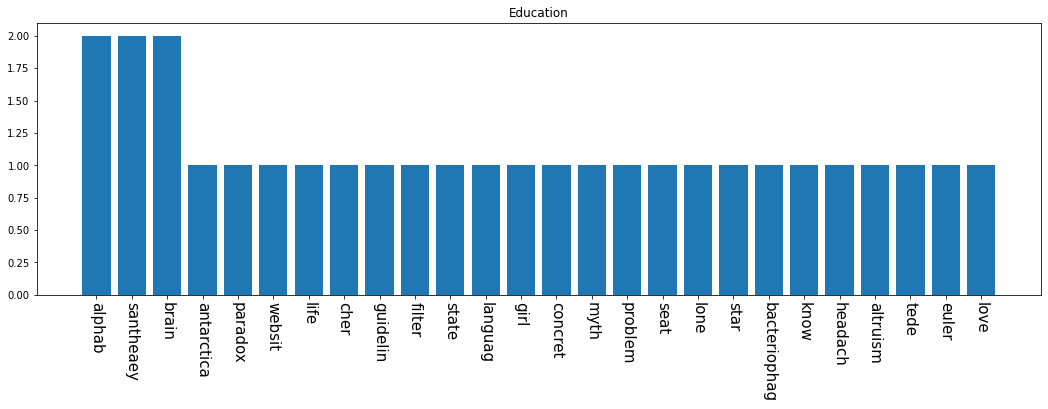

Category 'Pets & Animals' Attr: 'filtered_ocr_text' unique words: 2


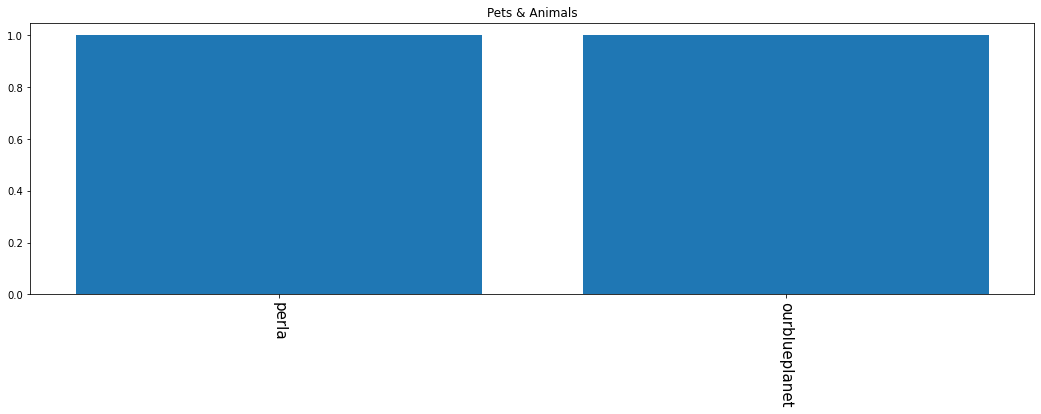

Category 'Science & Technology' Attr: 'filtered_ocr_text' unique words: 19


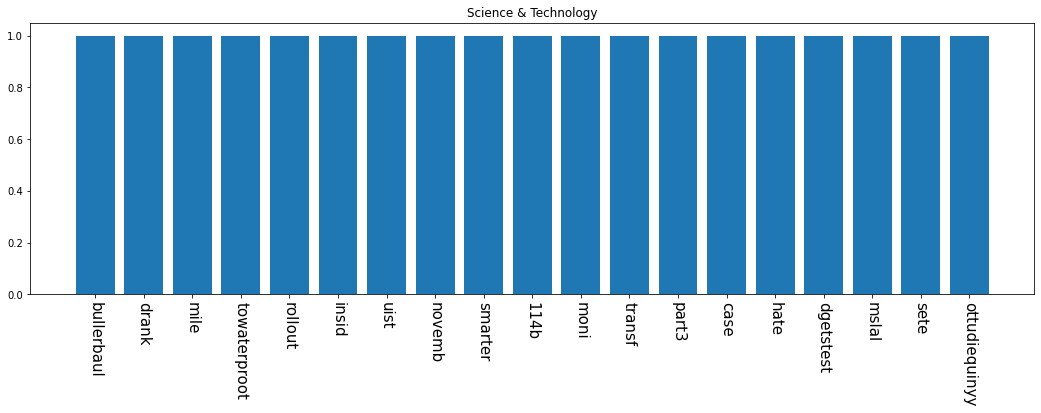

Category 'Film & Animation' Attr: 'filtered_ocr_text' unique words: 28


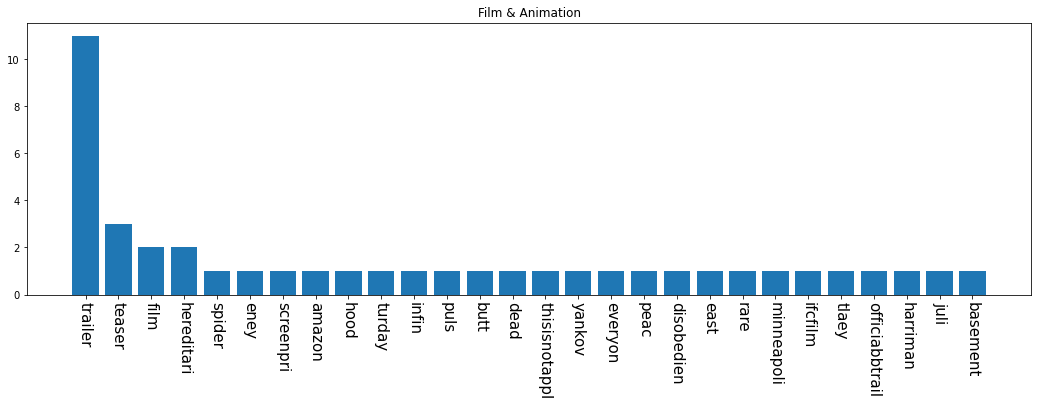

Category 'Autos & Vehicles' Attr: 'filtered_ocr_text' unique words: 2


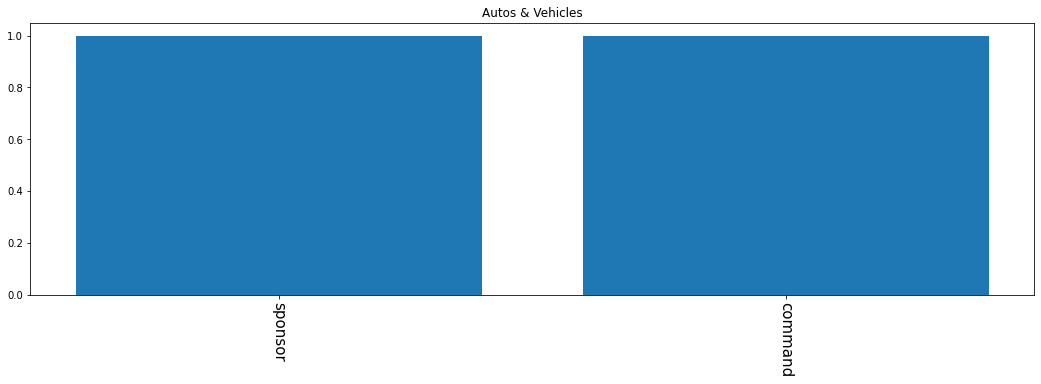

Category 'Nonprofits & Activism' Attr: 'filtered_ocr_text' unique words: 1


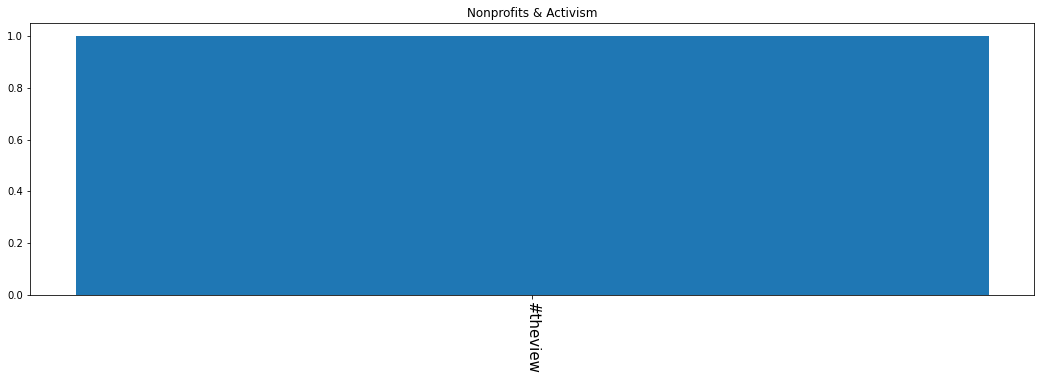

Category 'Shows' Attr: 'filtered_ocr_text' unique words: 0


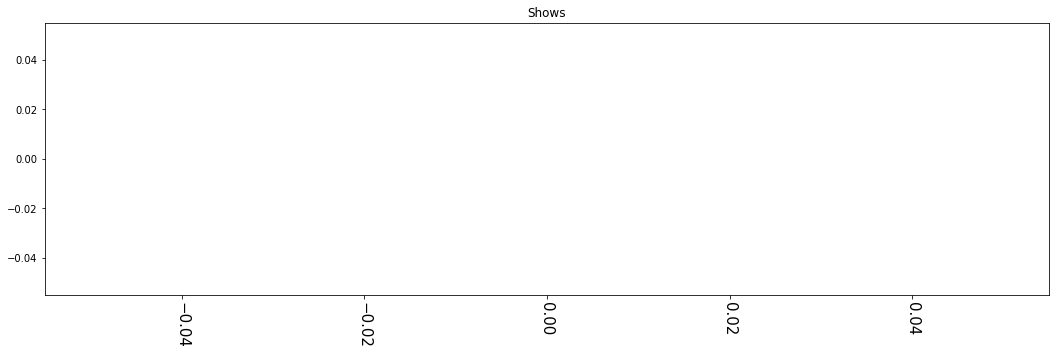

In [153]:
plot_categories_bars(categories, "filtered_ocr_text", n_tokens=1)

## Domeny

Category 'Entertainment' Attr: 'domains' unique words: 429


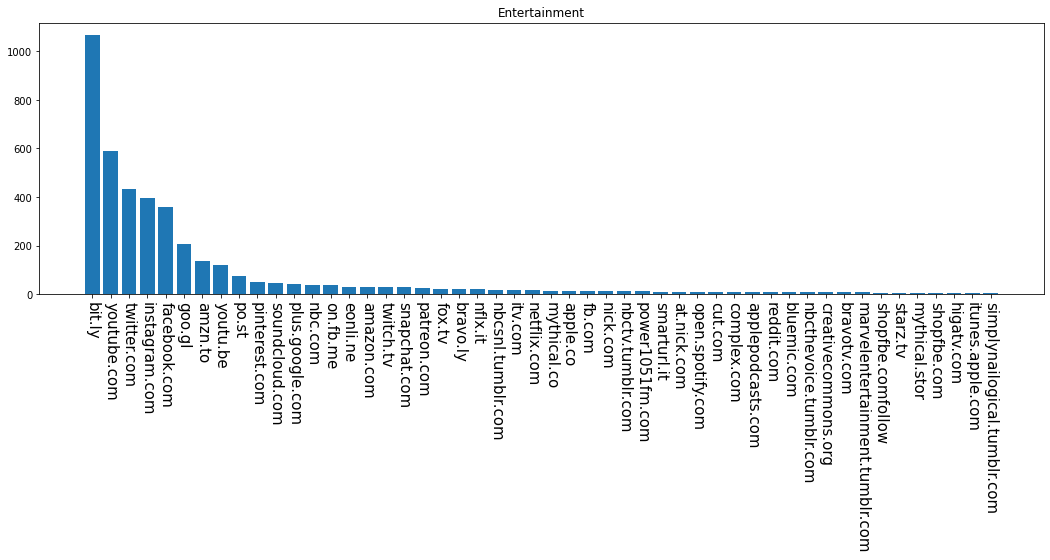

Category 'Music' Attr: 'domains' unique words: 473


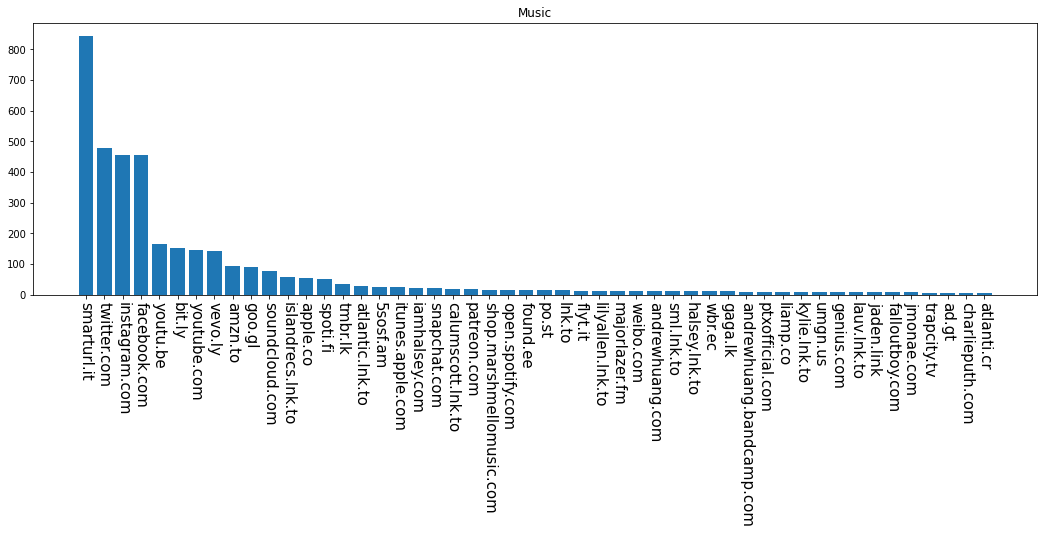

Category 'People & Blogs' Attr: 'domains' unique words: 214


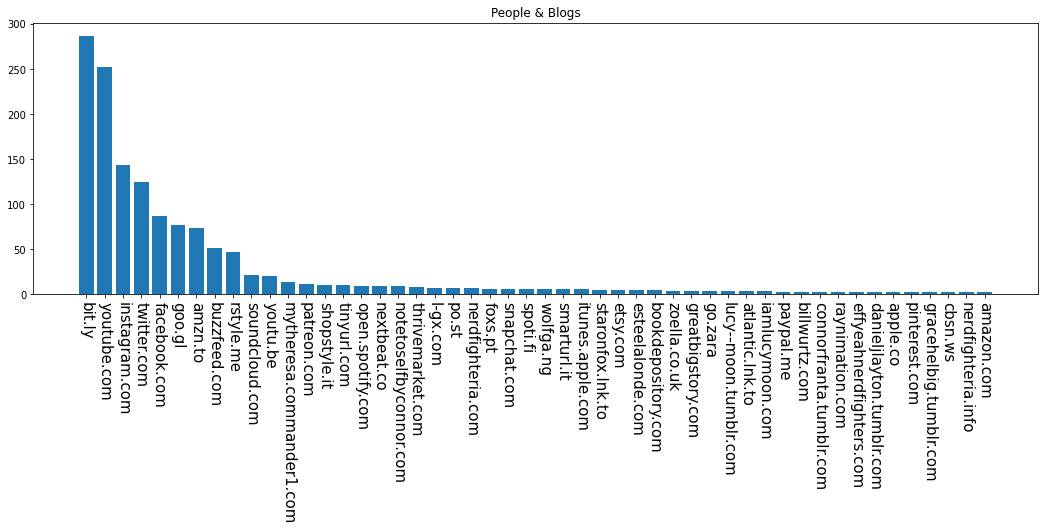

Category 'Howto & Style' Attr: 'domains' unique words: 222


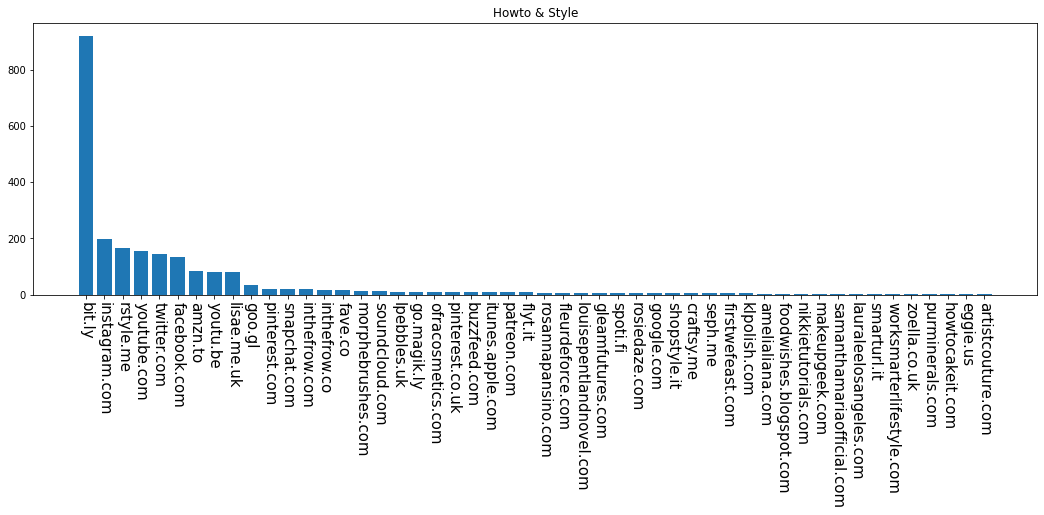

Category 'News & Politics' Attr: 'domains' unique words: 79


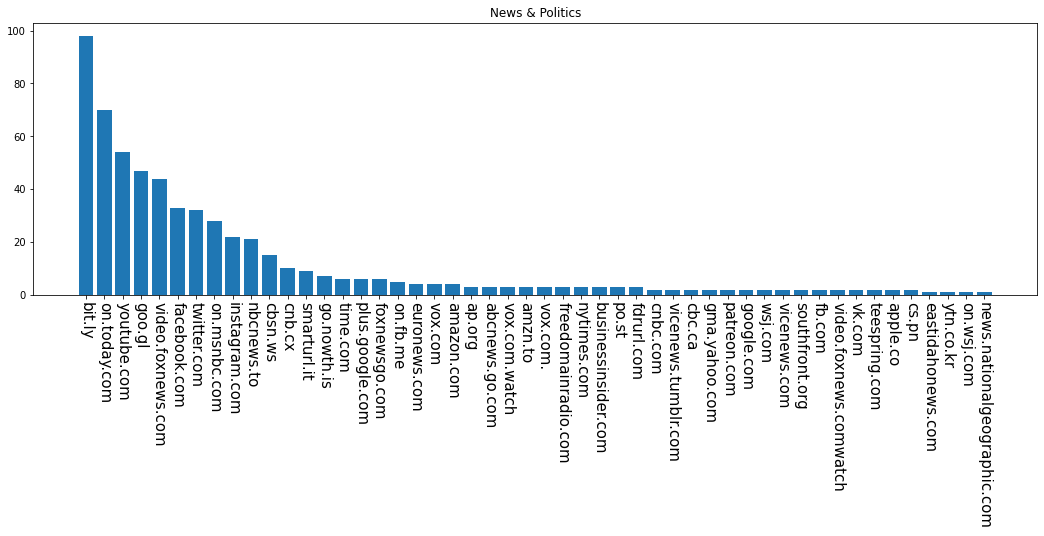

Category 'Comedy' Attr: 'domains' unique words: 135


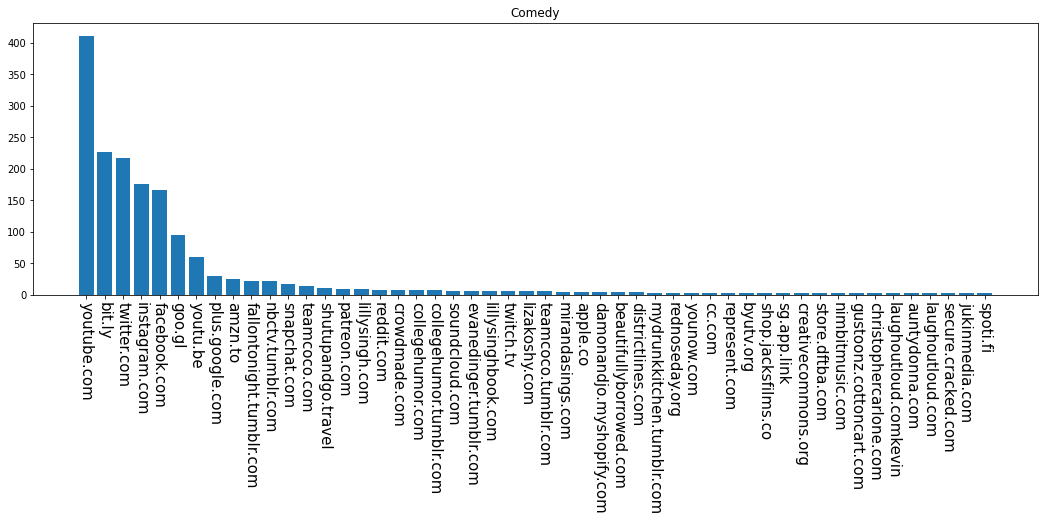

Category 'Sports' Attr: 'domains' unique words: 101


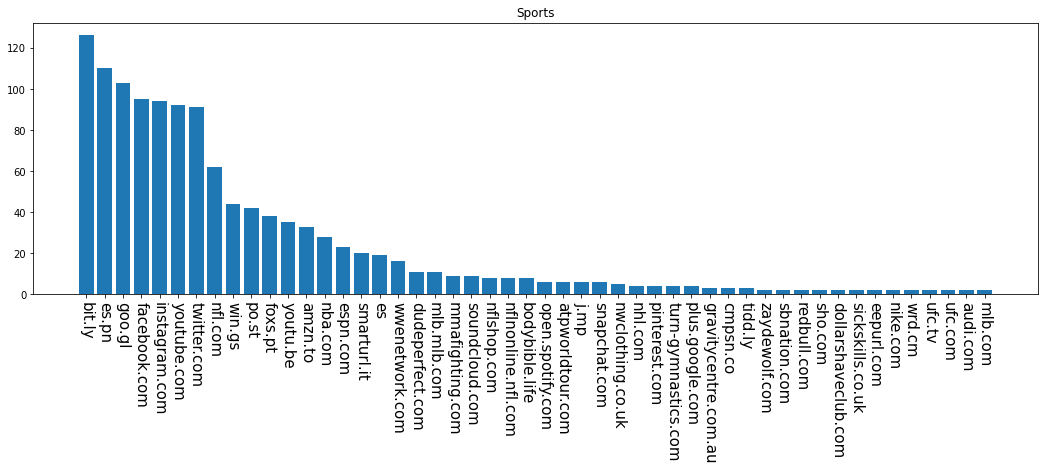

Category 'Travel & Events' Attr: 'domains' unique words: 36


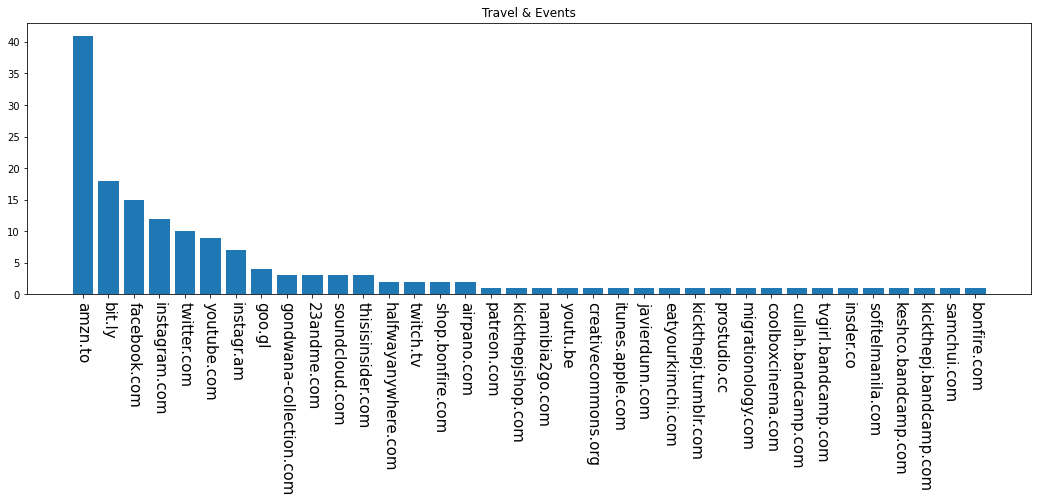

Category 'Gaming' Attr: 'domains' unique words: 108


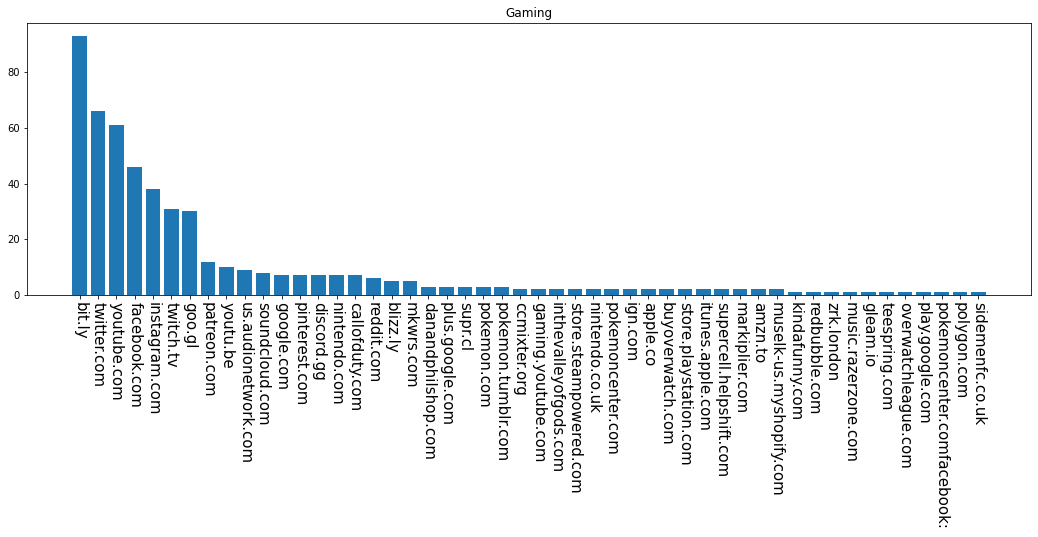

Category 'Education' Attr: 'domains' unique words: 210


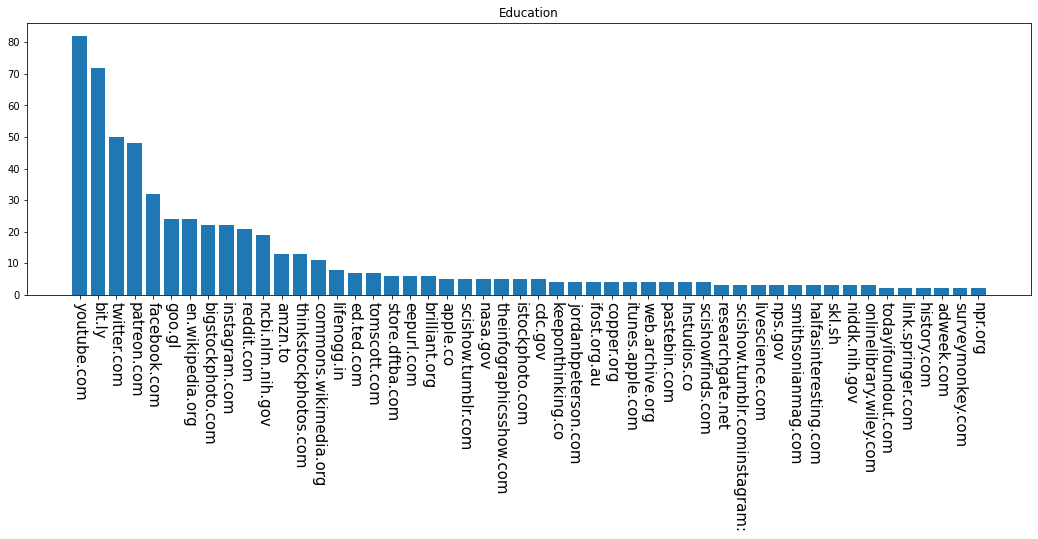

Category 'Pets & Animals' Attr: 'domains' unique words: 56


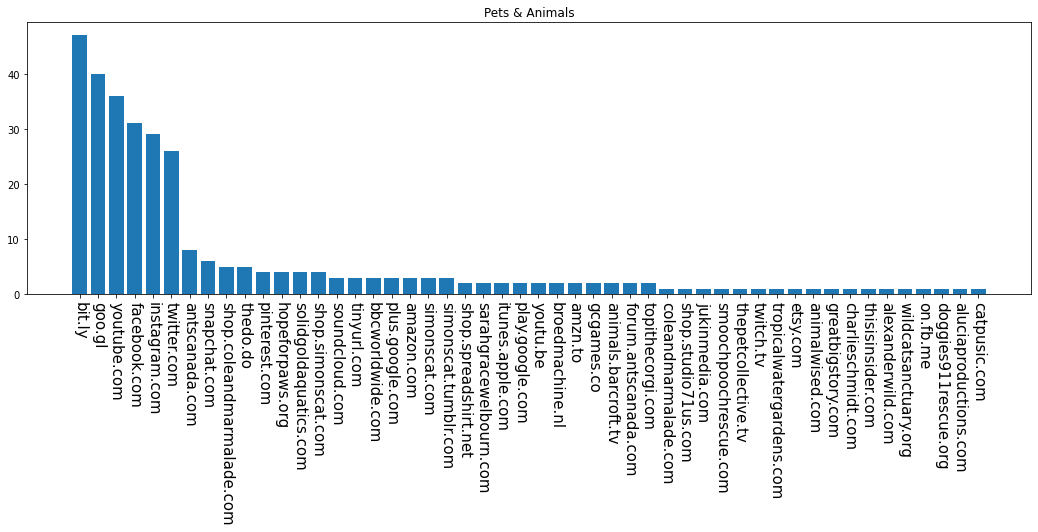

Category 'Science & Technology' Attr: 'domains' unique words: 178


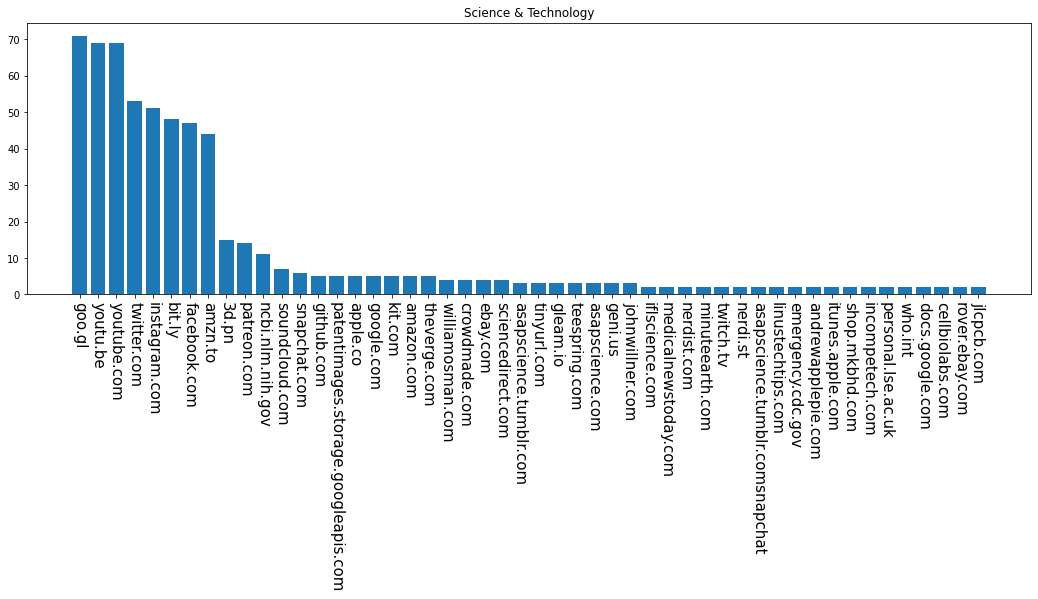

Category 'Film & Animation' Attr: 'domains' unique words: 144


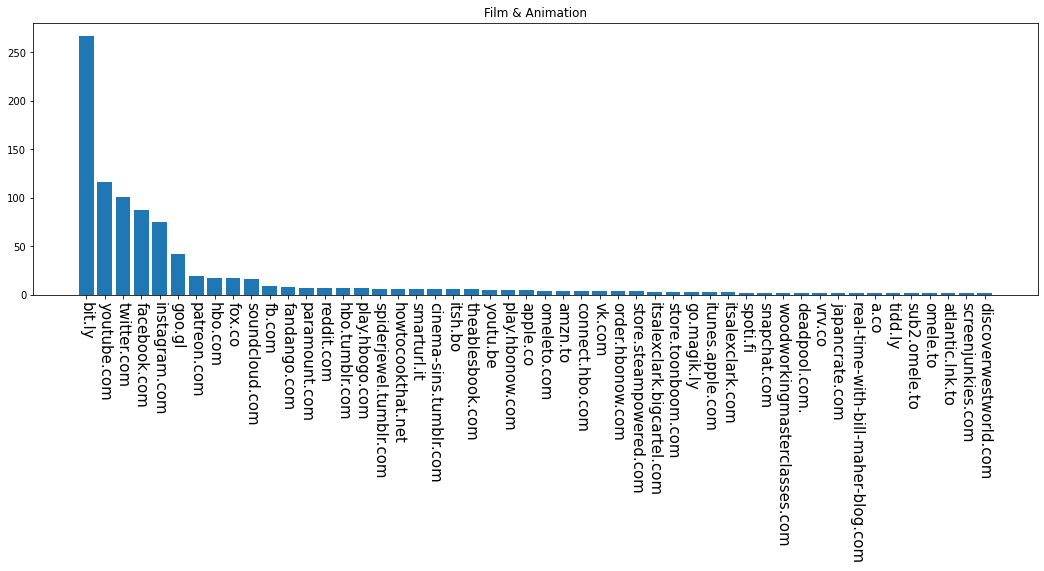

Category 'Autos & Vehicles' Attr: 'domains' unique words: 29


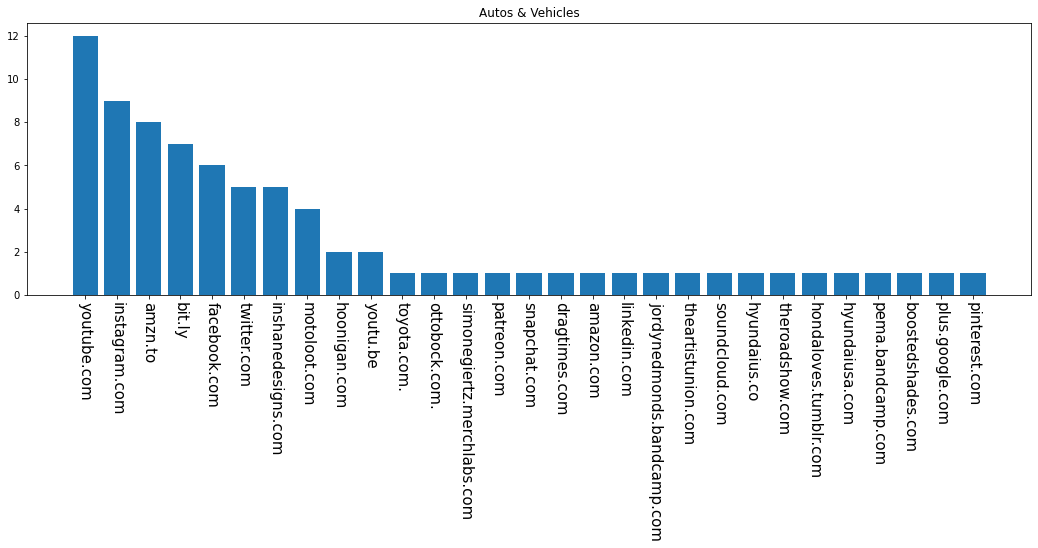

Category 'Nonprofits & Activism' Attr: 'domains' unique words: 1


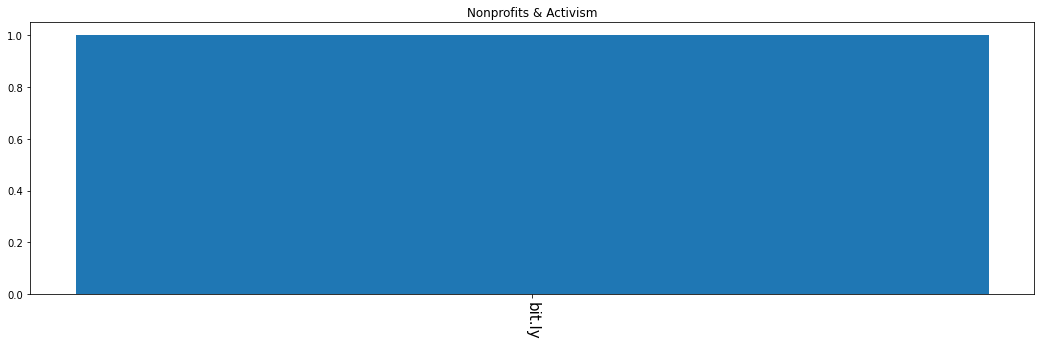

Category 'Shows' Attr: 'domains' unique words: 8


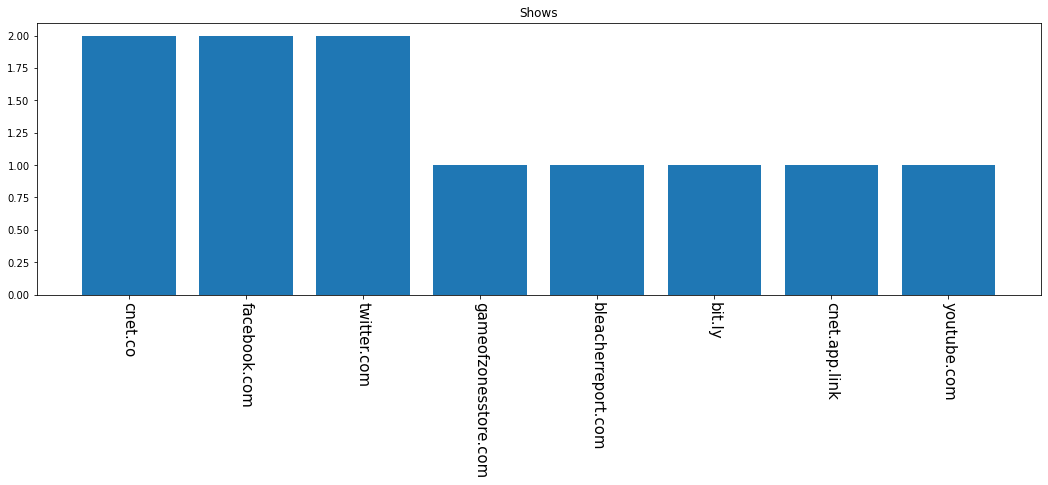

In [154]:
plot_categories_bars(categories, "domains", n_tokens=7)

## TAGI

Category 'Entertainment' Attr: 'tags' unique words: 8878


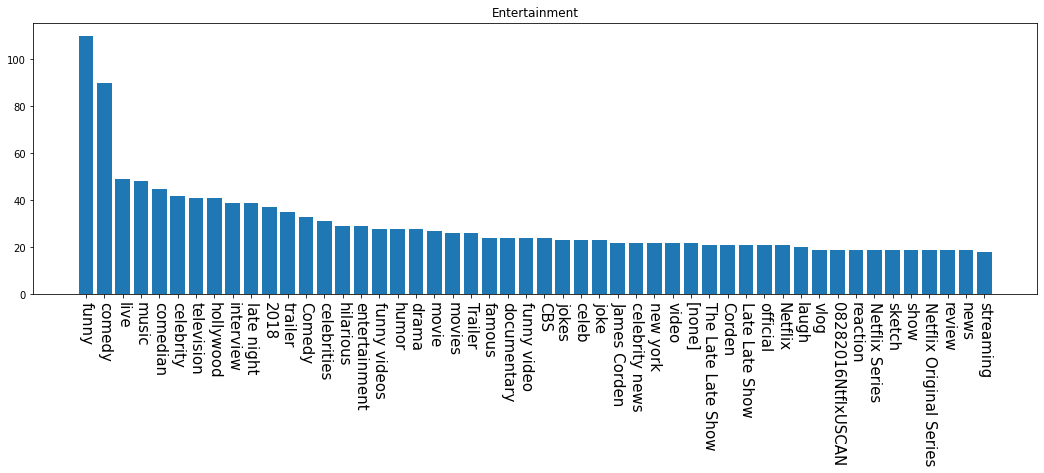

Category 'Music' Attr: 'tags' unique words: 6116


c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 53444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45800 missing from current font.
  font.

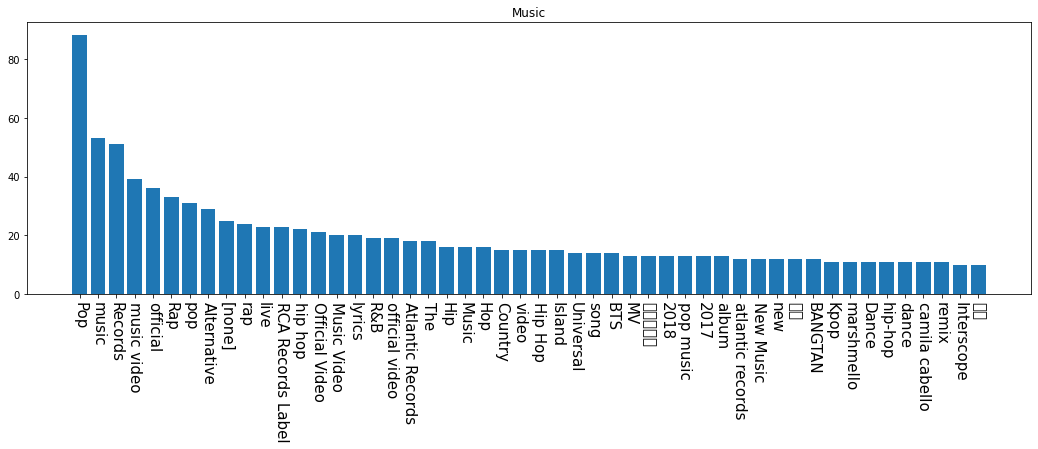

Category 'People & Blogs' Attr: 'tags' unique words: 2774


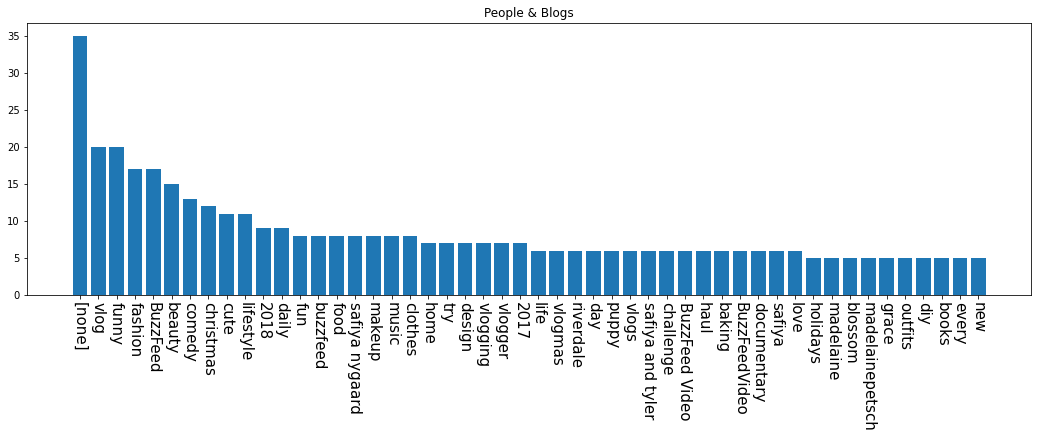

Category 'Howto & Style' Attr: 'tags' unique words: 3137


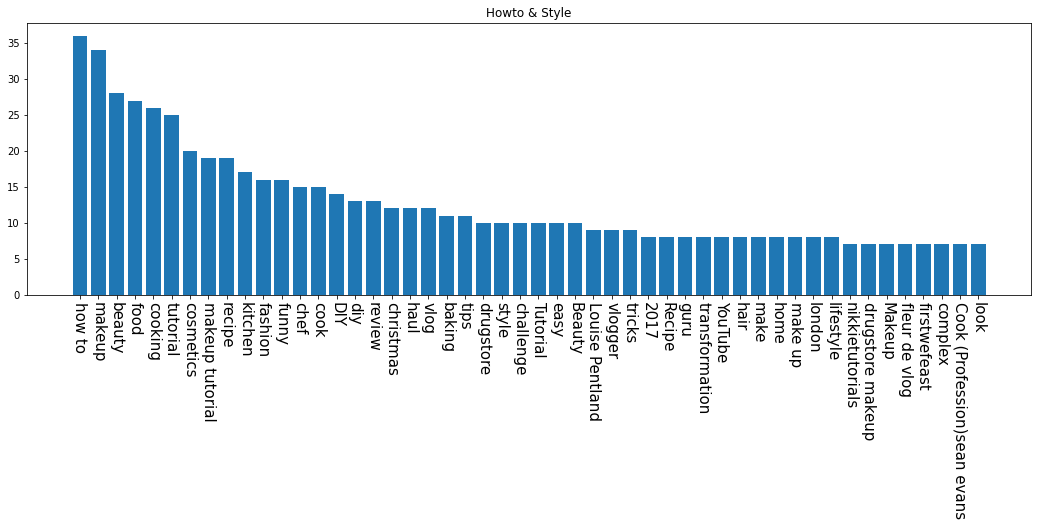

Category 'News & Politics' Attr: 'tags' unique words: 1706


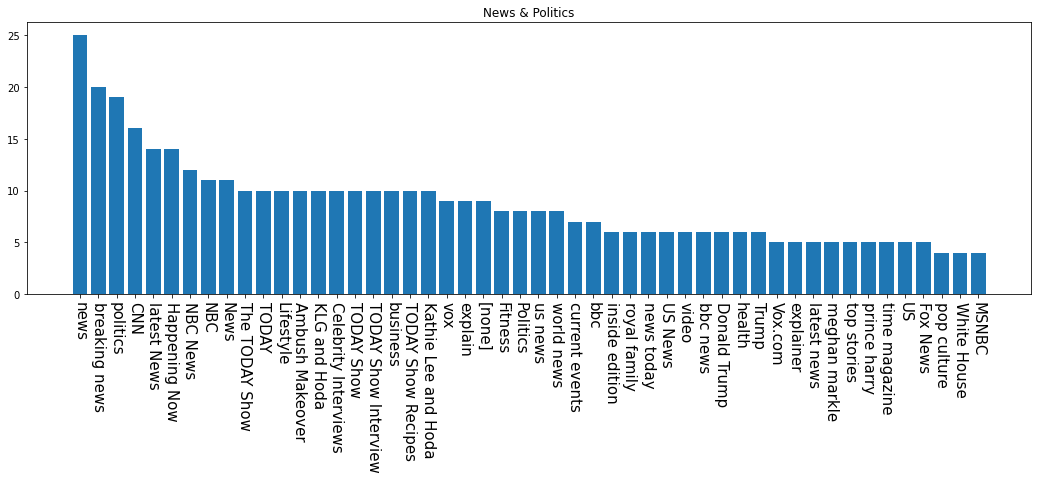

Category 'Comedy' Attr: 'tags' unique words: 2816


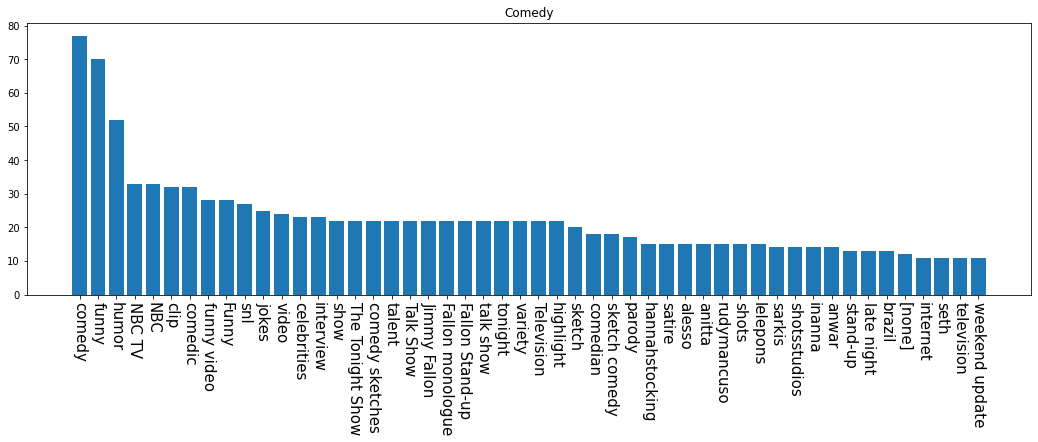

Category 'Sports' Attr: 'tags' unique words: 2749


c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 2369 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 2358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 2381 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 2340 missing from current font.
  font.set_t

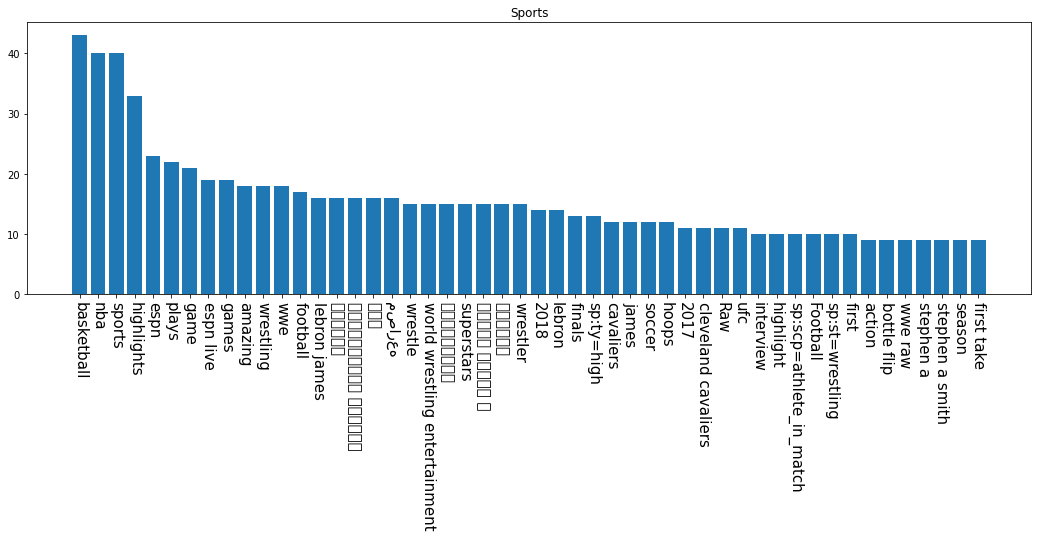

Category 'Travel & Events' Attr: 'tags' unique words: 344


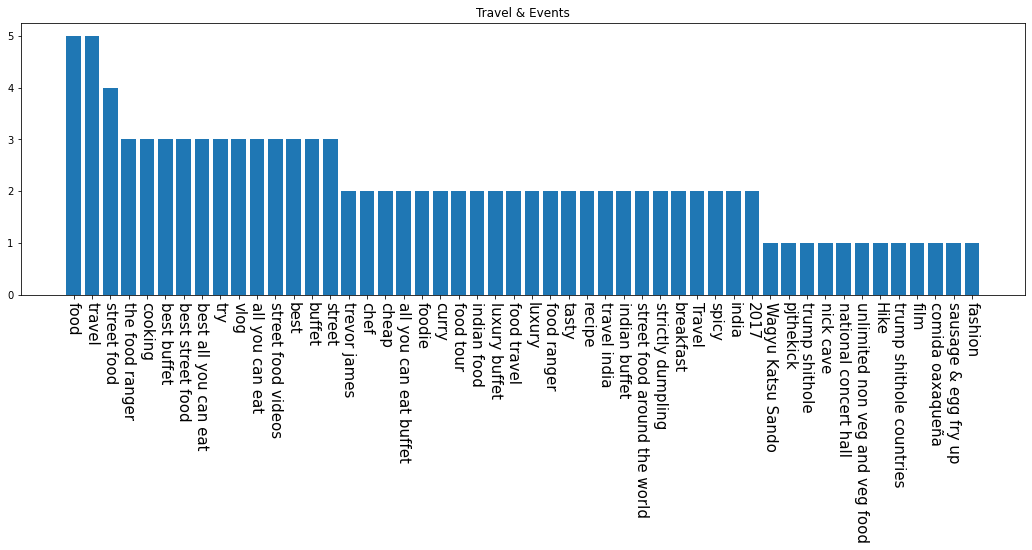

Category 'Gaming' Attr: 'tags' unique words: 1546


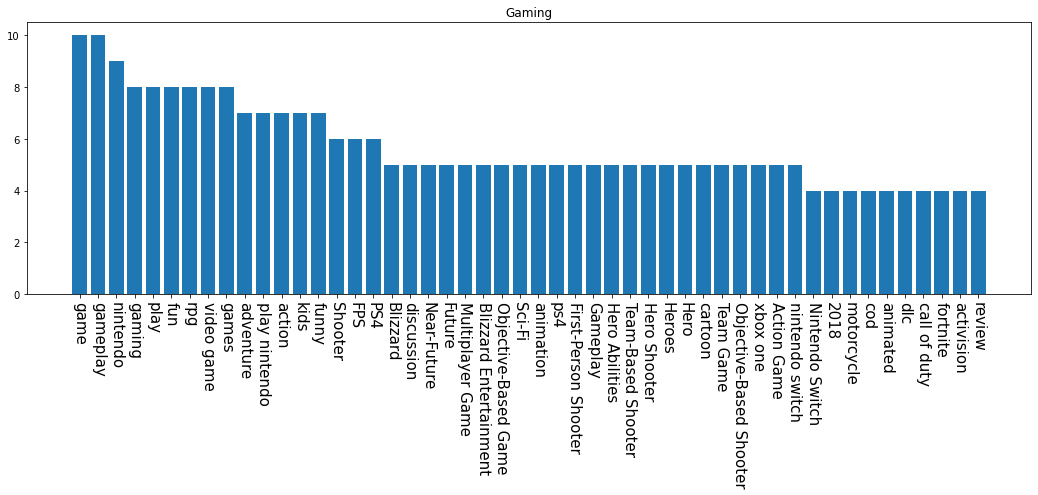

Category 'Education' Attr: 'tags' unique words: 1235


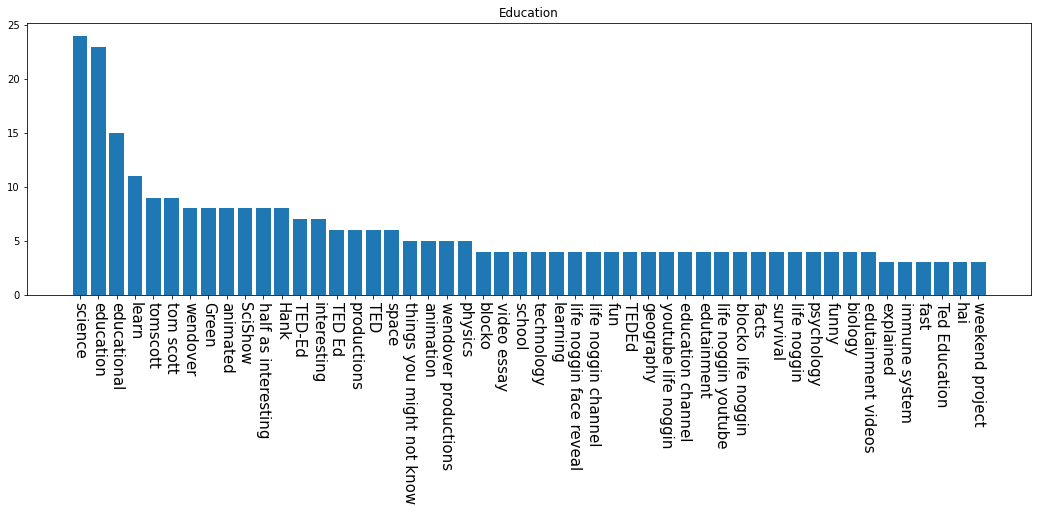

Category 'Pets & Animals' Attr: 'tags' unique words: 793


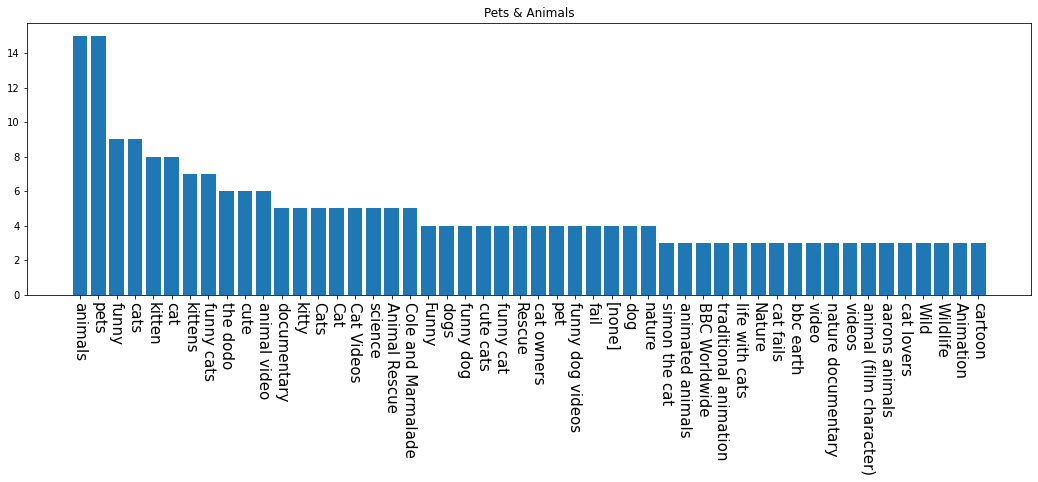

Category 'Science & Technology' Attr: 'tags' unique words: 1340


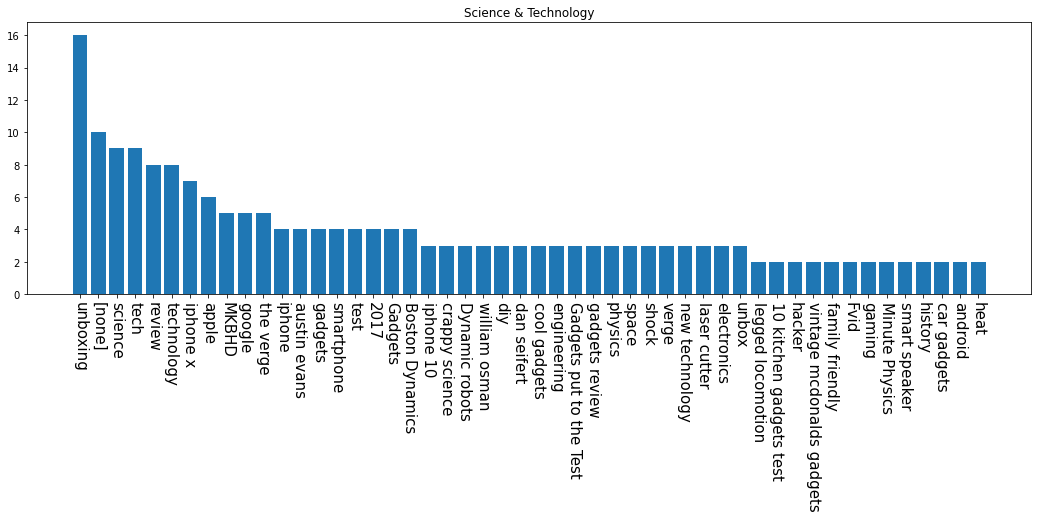

Category 'Film & Animation' Attr: 'tags' unique words: 2178


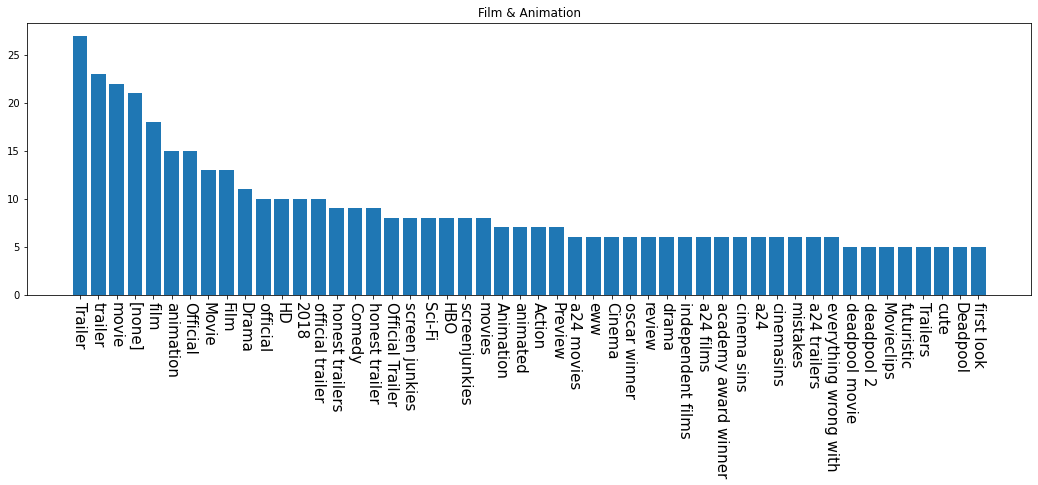

Category 'Autos & Vehicles' Attr: 'tags' unique words: 273


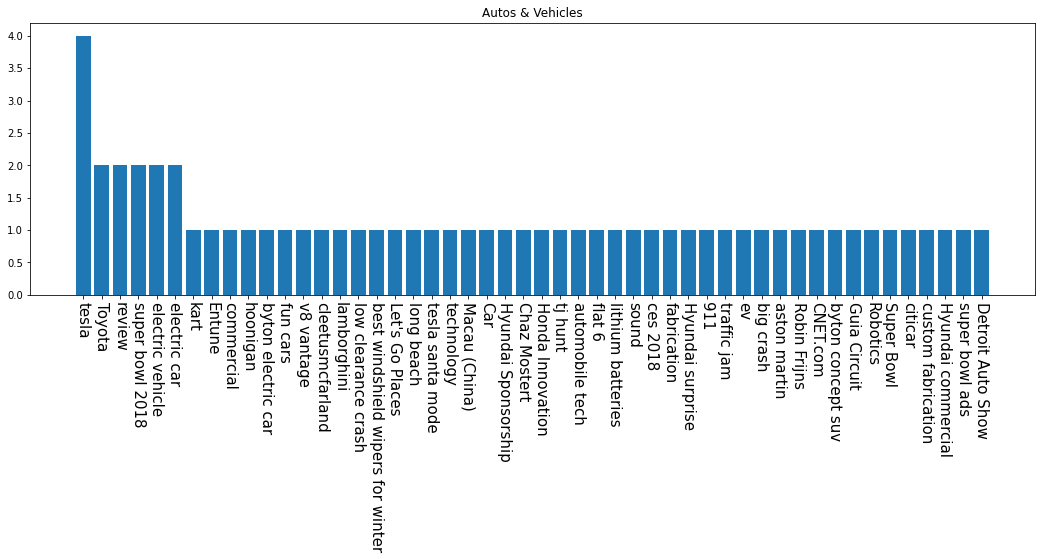

Category 'Nonprofits & Activism' Attr: 'tags' unique words: 88


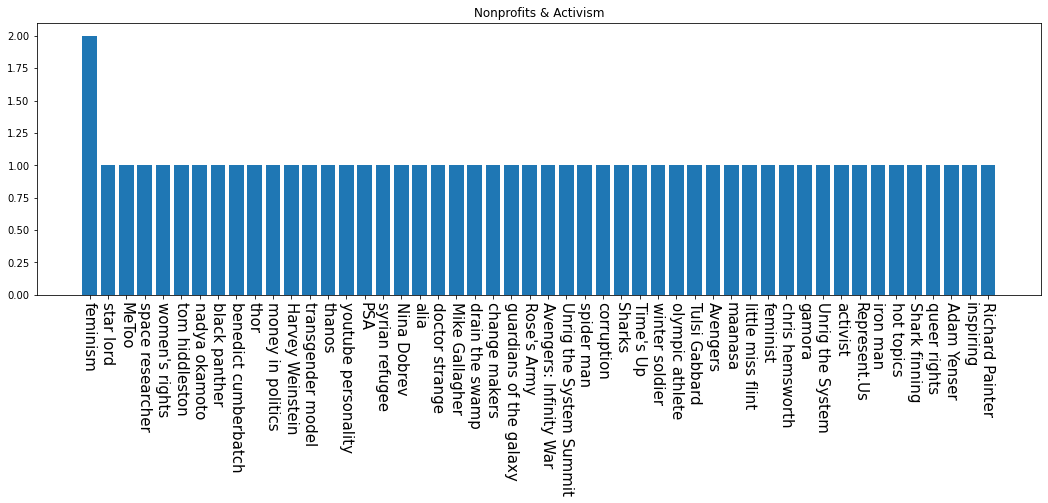

Category 'Shows' Attr: 'tags' unique words: 73


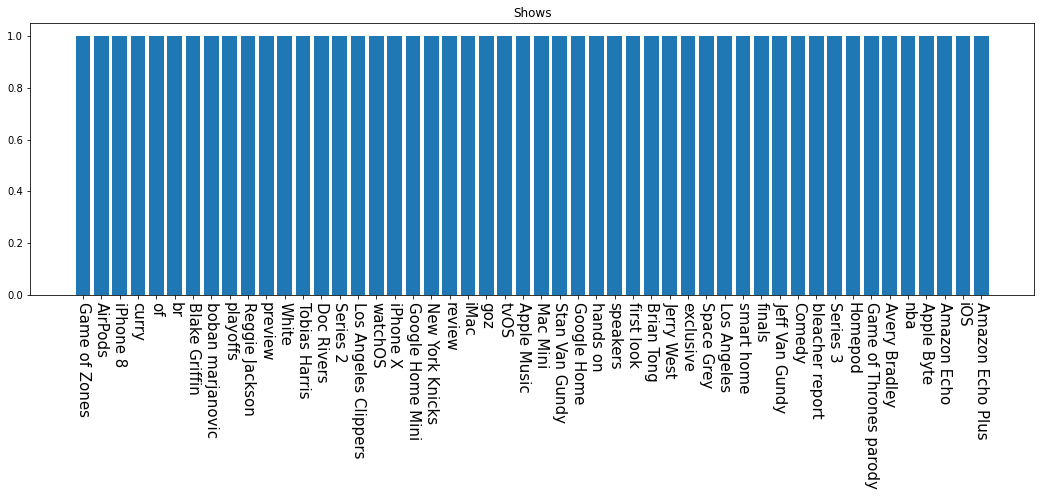

In [155]:
videos["tokenized_tags"] = videos["tags"].apply(lambda x: eval(x)[-1].split("|") if eval(x) else np.nan)
plot_categories_bars(categories, "tags")

## Emocje

Category 'Entertainment' Attr: 'emotion' unique words: 6


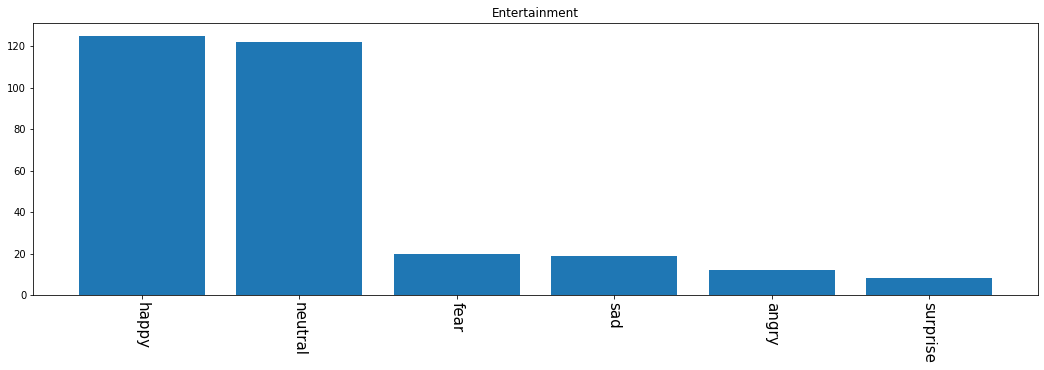

Category 'Music' Attr: 'emotion' unique words: 6


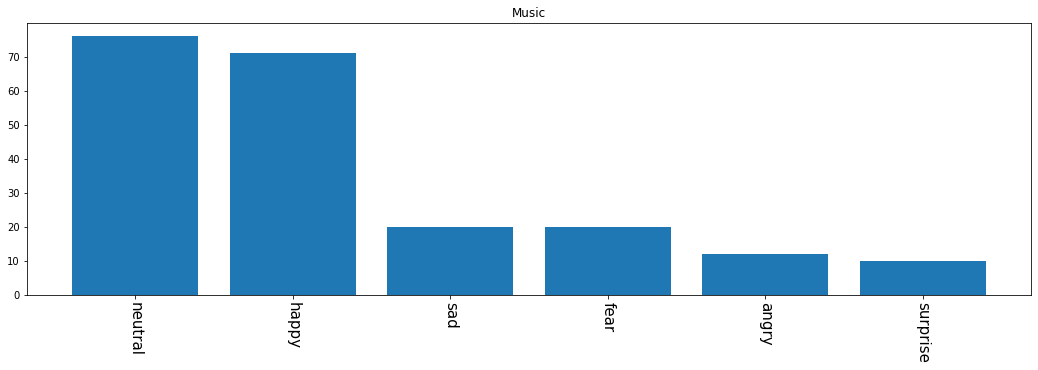

Category 'People & Blogs' Attr: 'emotion' unique words: 6


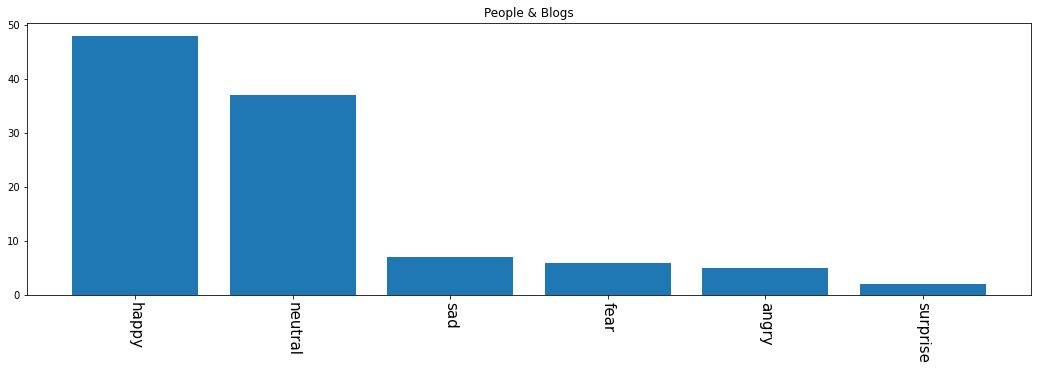

Category 'Howto & Style' Attr: 'emotion' unique words: 7


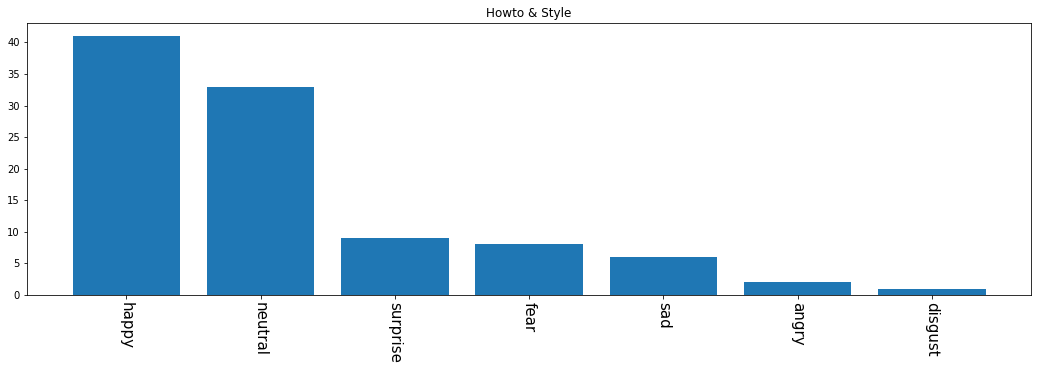

Category 'News & Politics' Attr: 'emotion' unique words: 5


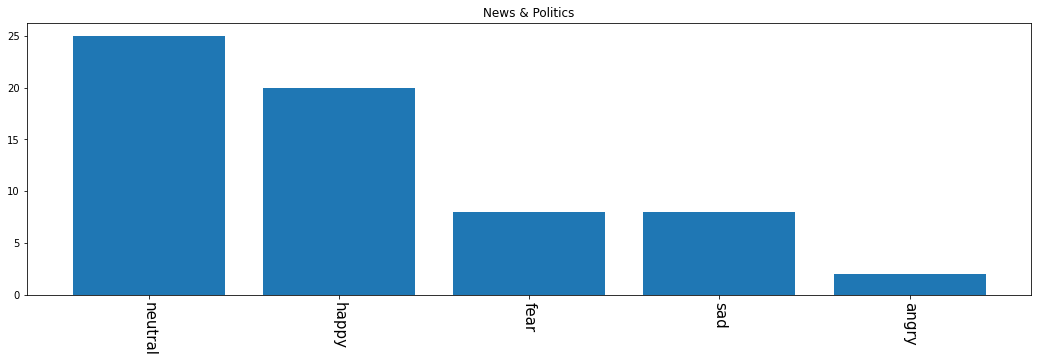

Category 'Comedy' Attr: 'emotion' unique words: 7


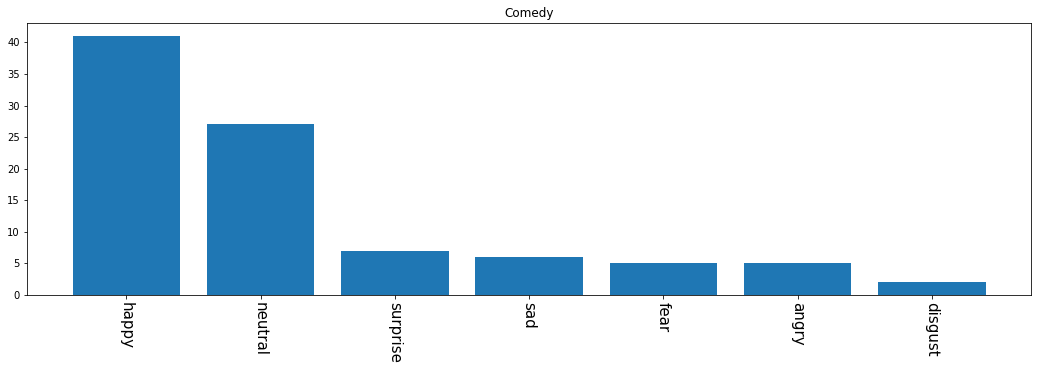

Category 'Sports' Attr: 'emotion' unique words: 6


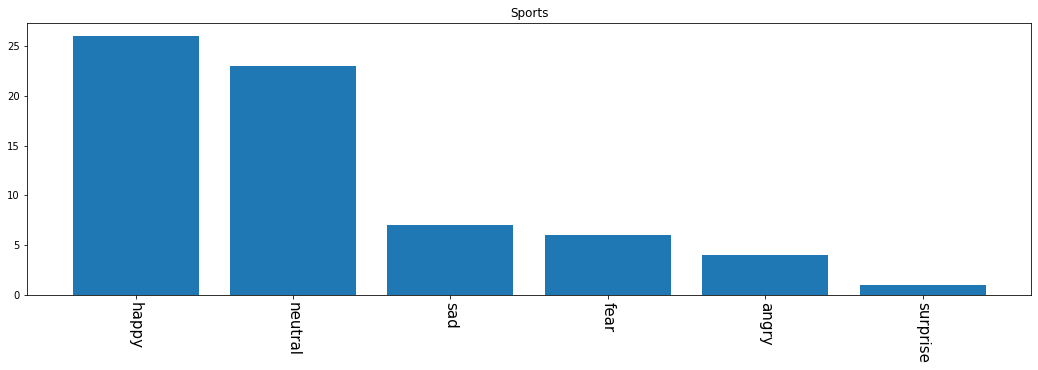

Category 'Travel & Events' Attr: 'emotion' unique words: 3


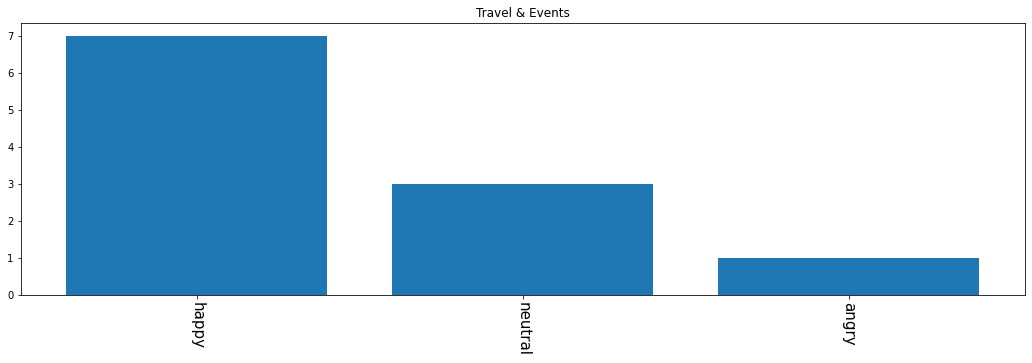

Category 'Gaming' Attr: 'emotion' unique words: 5


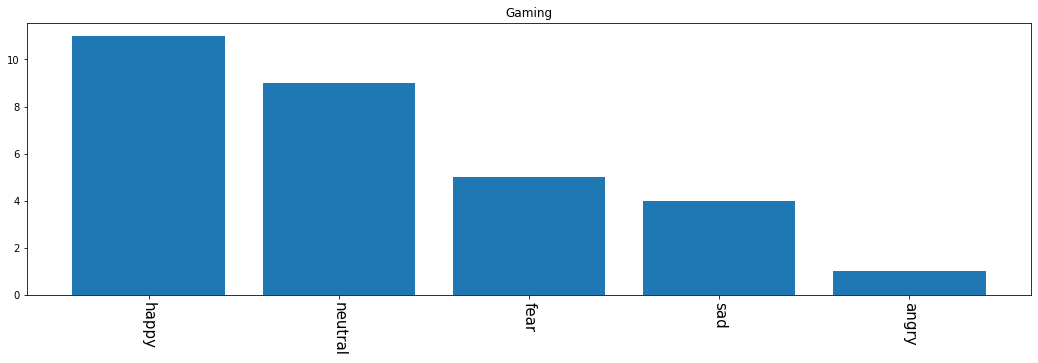

Category 'Education' Attr: 'emotion' unique words: 6


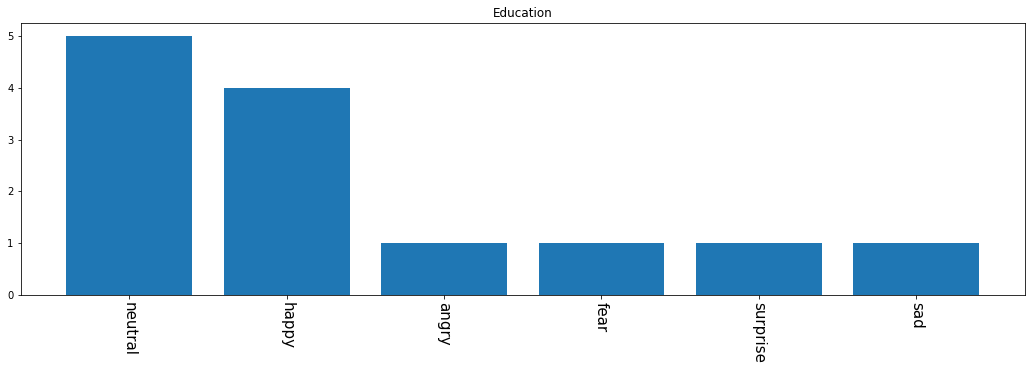

Category 'Pets & Animals' Attr: 'emotion' unique words: 4


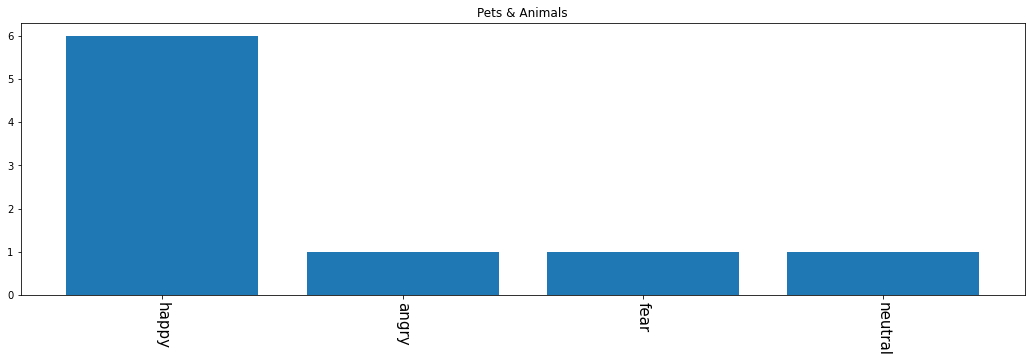

Category 'Science & Technology' Attr: 'emotion' unique words: 6


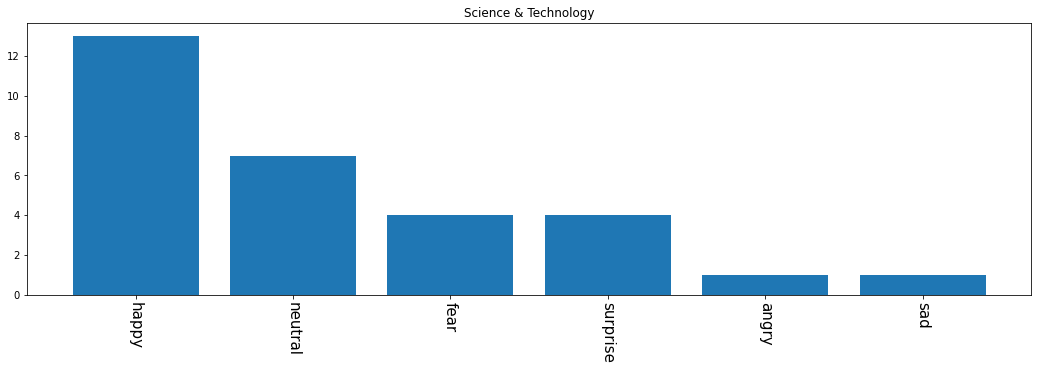

Category 'Film & Animation' Attr: 'emotion' unique words: 6


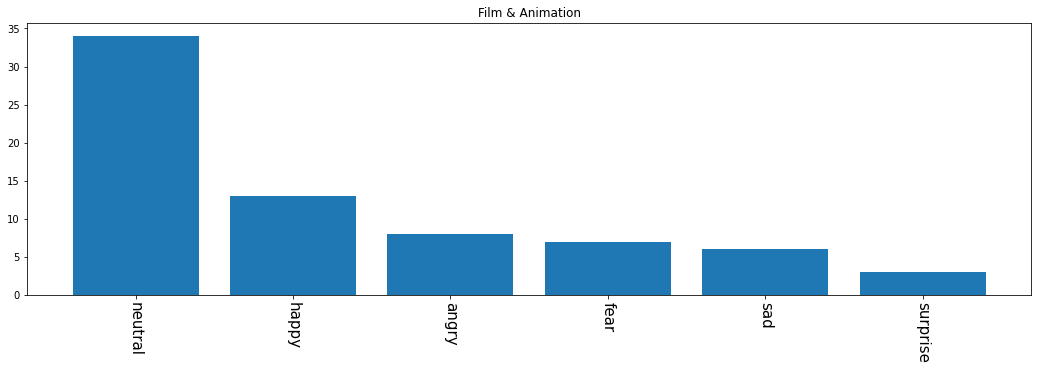

Category 'Autos & Vehicles' Attr: 'emotion' unique words: 0


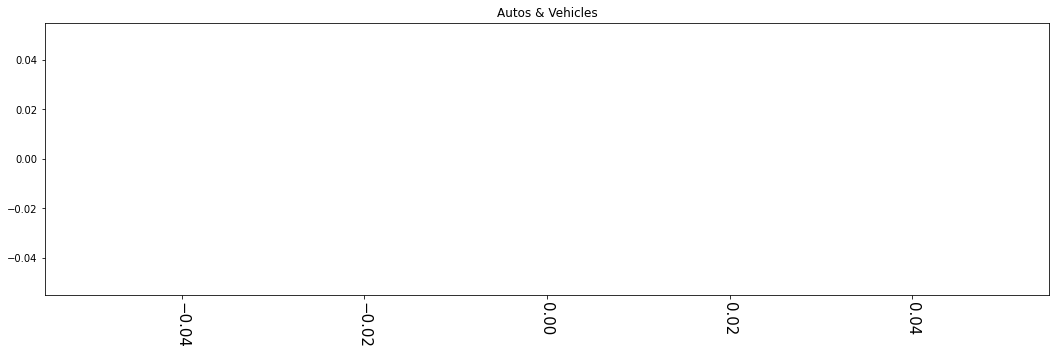

Category 'Nonprofits & Activism' Attr: 'emotion' unique words: 2


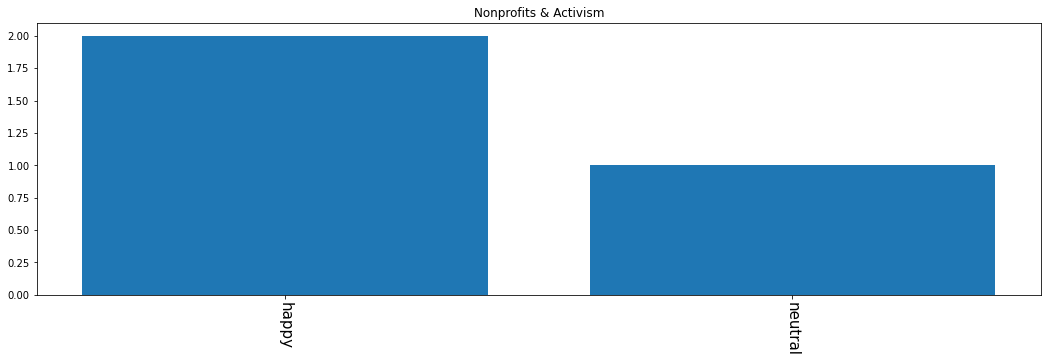

Category 'Shows' Attr: 'emotion' unique words: 1


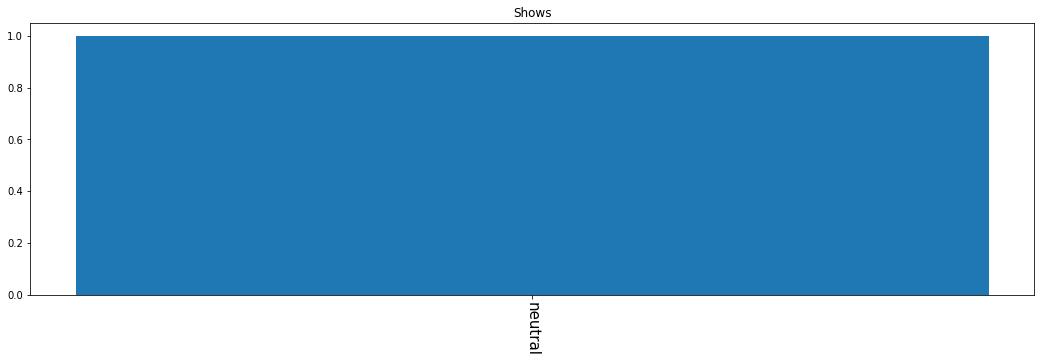

In [156]:
videos["tokenized_emotion"] = videos["emotions"].apply(lambda x: [eval(x)[-1]] if eval(x) else np.nan)
plot_categories_bars(categories, "emotion", create_tokens_dict=False)

## Obiekty na obrazach

Category 'Entertainment' Attr: 'objects' unique words: 21


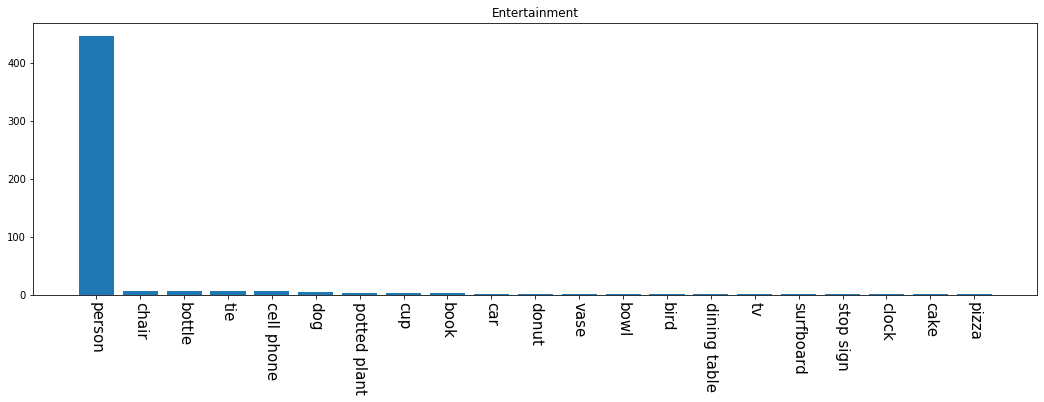

Category 'Music' Attr: 'objects' unique words: 15


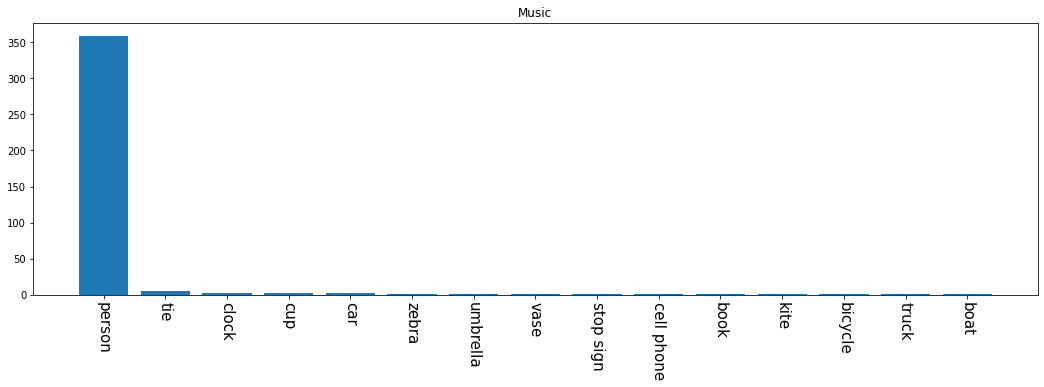

Category 'People & Blogs' Attr: 'objects' unique words: 15


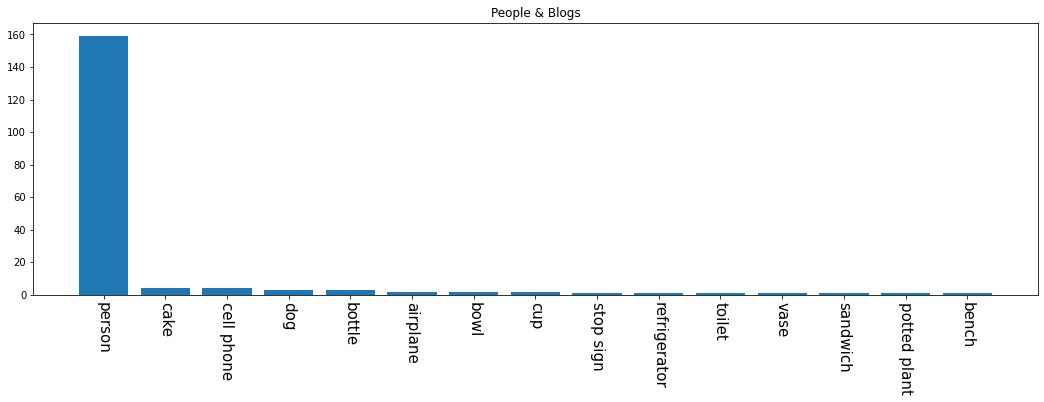

Category 'Howto & Style' Attr: 'objects' unique words: 15


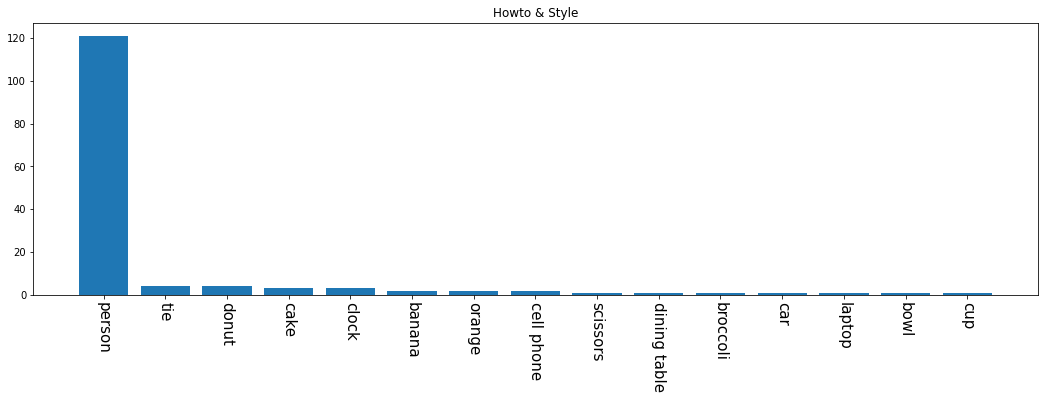

Category 'News & Politics' Attr: 'objects' unique words: 6


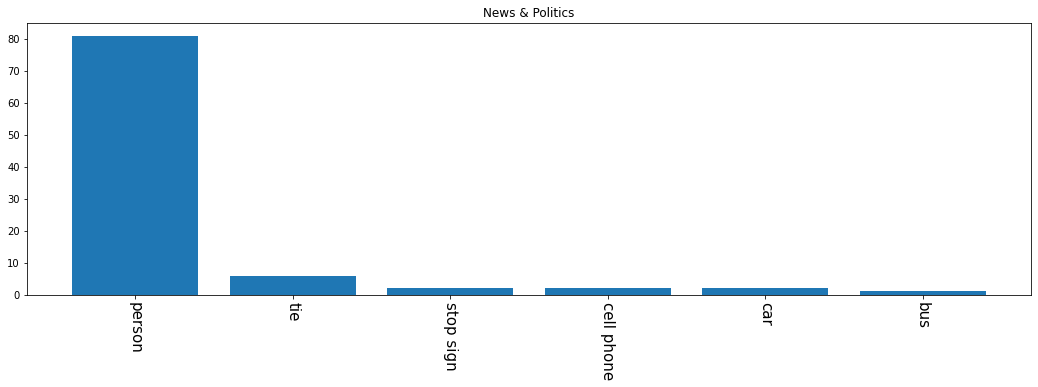

Category 'Comedy' Attr: 'objects' unique words: 13


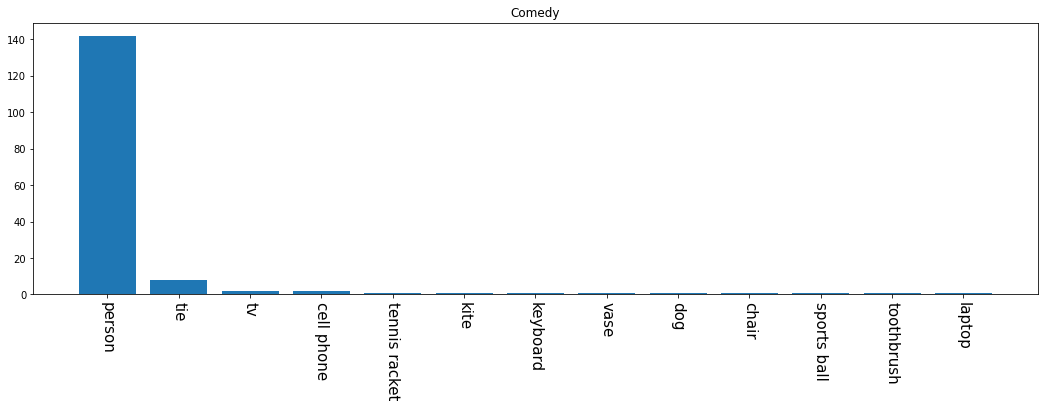

Category 'Sports' Attr: 'objects' unique words: 12


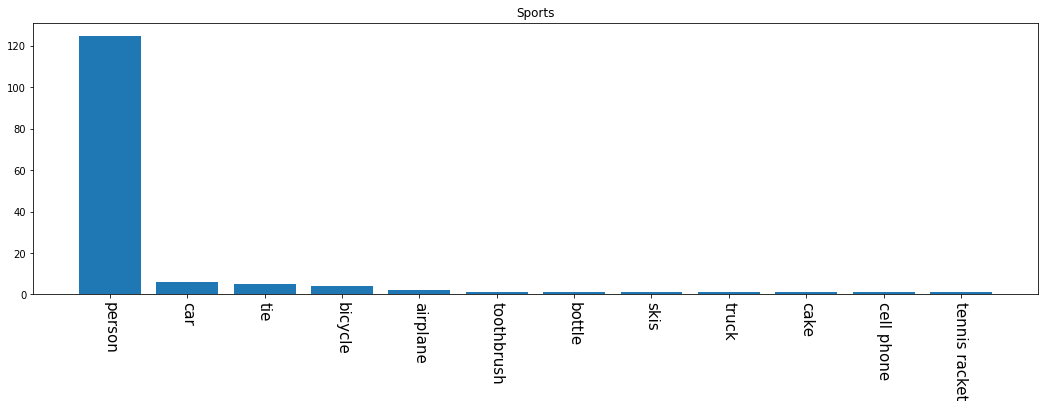

Category 'Travel & Events' Attr: 'objects' unique words: 4


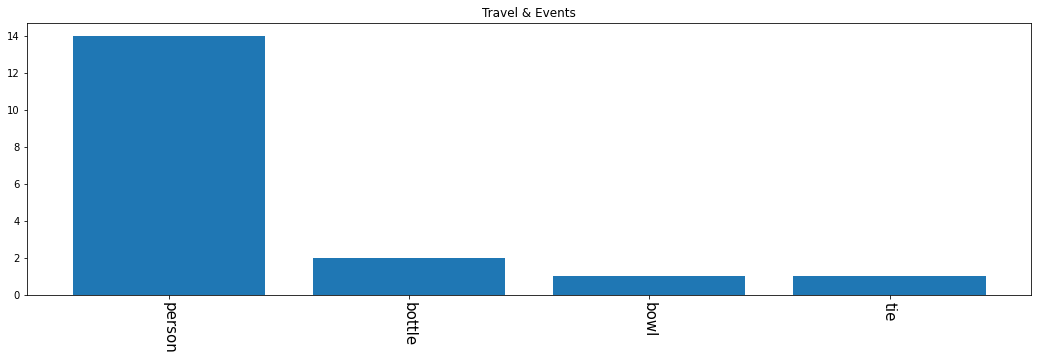

Category 'Gaming' Attr: 'objects' unique words: 4


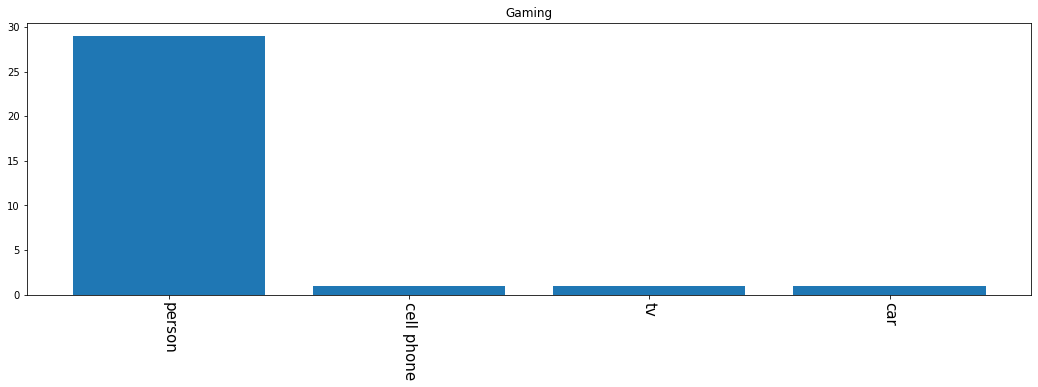

Category 'Education' Attr: 'objects' unique words: 5


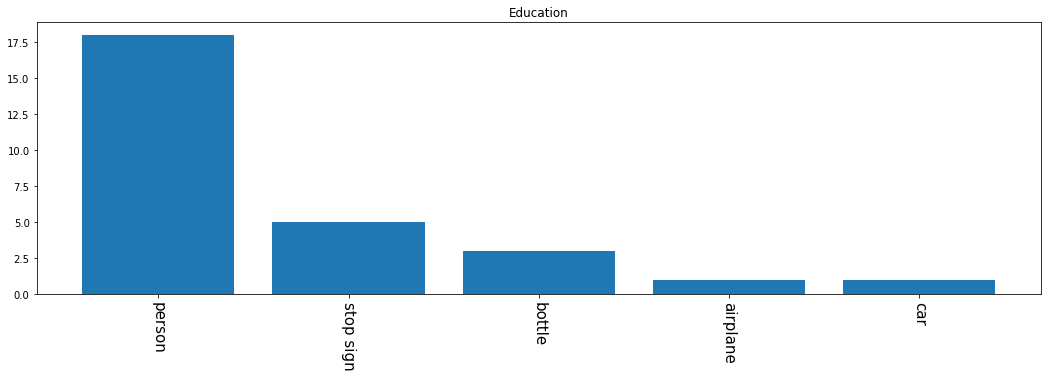

Category 'Pets & Animals' Attr: 'objects' unique words: 8


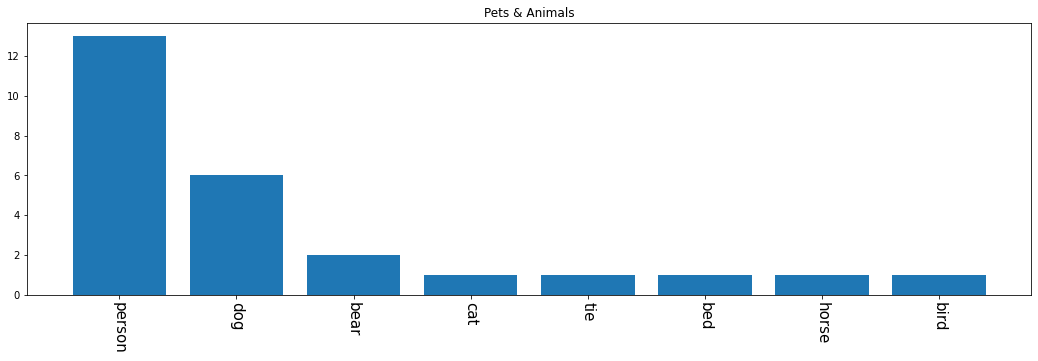

Category 'Science & Technology' Attr: 'objects' unique words: 15


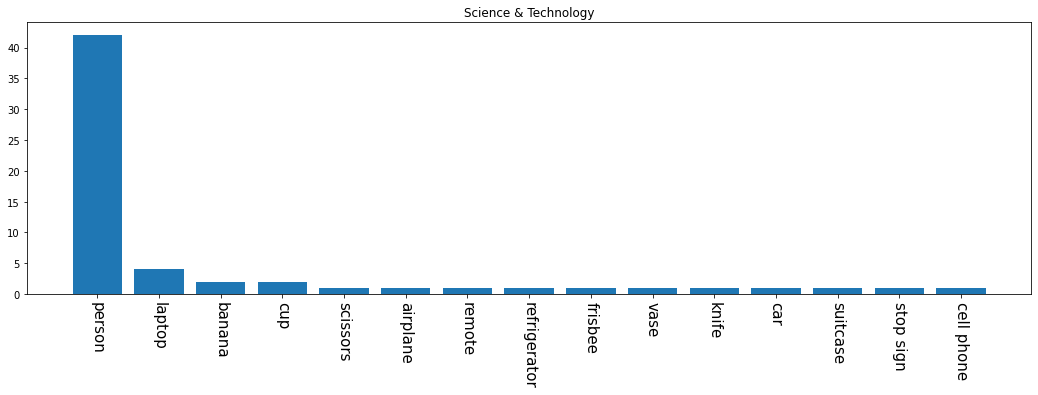

Category 'Film & Animation' Attr: 'objects' unique words: 10


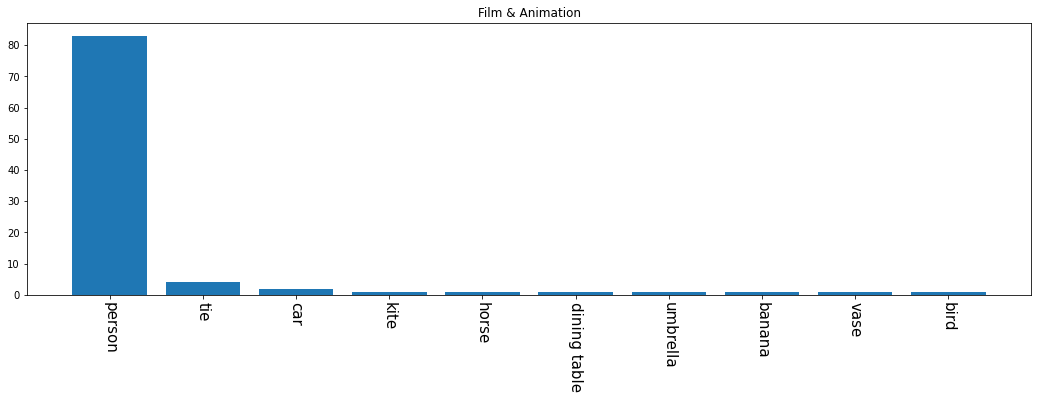

Category 'Autos & Vehicles' Attr: 'objects' unique words: 3


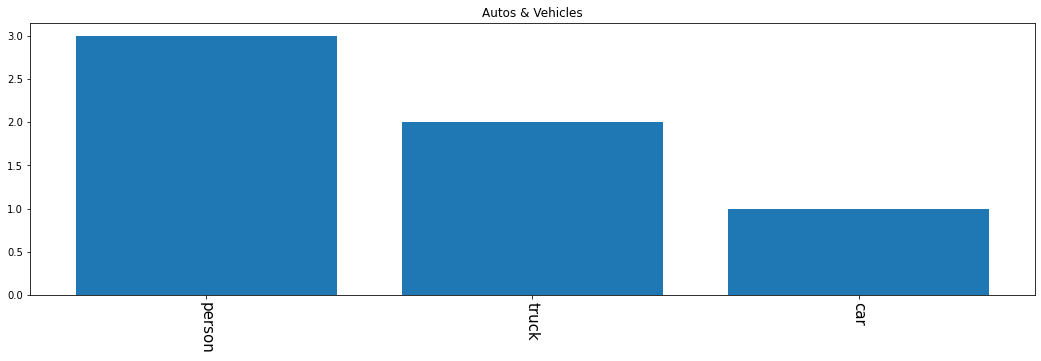

Category 'Nonprofits & Activism' Attr: 'objects' unique words: 1


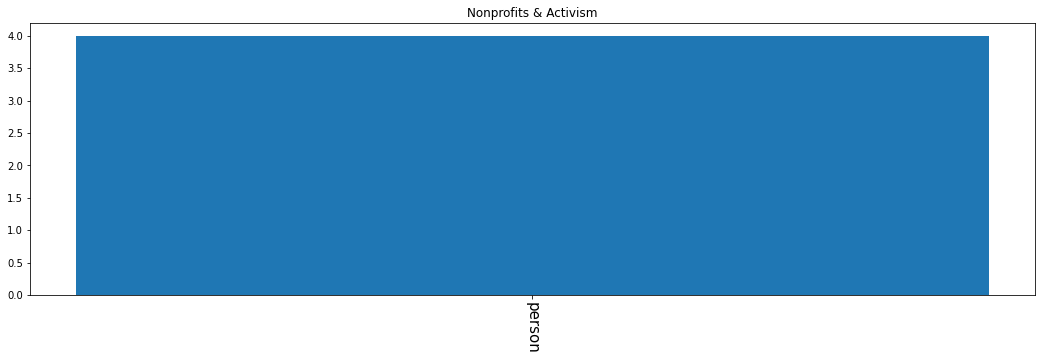

Category 'Shows' Attr: 'objects' unique words: 0


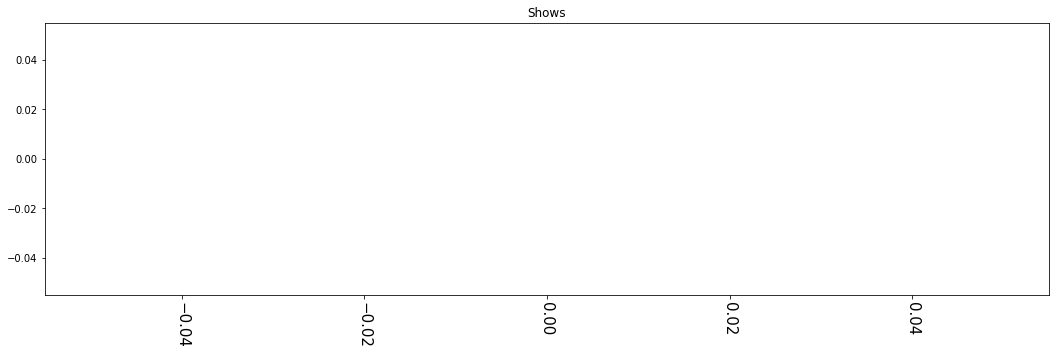

In [157]:
def filter_objects(row):
    objects = eval(row["obj_names"])
    scores = eval(row["obj_scores"])
    new_objects = []
    for obj, score in zip(objects, scores):
        if score > 0.75:
            new_objects.append(obj)
    return new_objects

videos["tokenized_objects"] = videos.apply(lambda x: filter_objects(x), axis=1)
plot_categories_bars(categories, "objects", create_tokens_dict=False)

## Kolory - poprawione

Category 'Entertainment' Attr: 'colors' unique words: 13


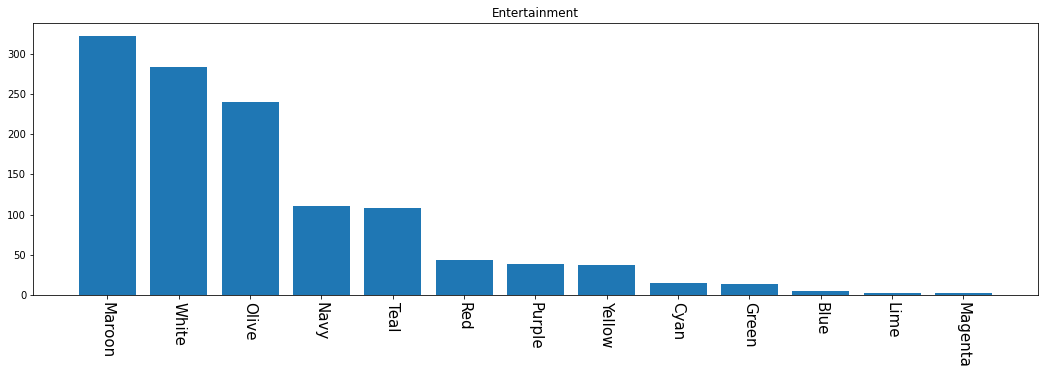

Category 'Music' Attr: 'colors' unique words: 13


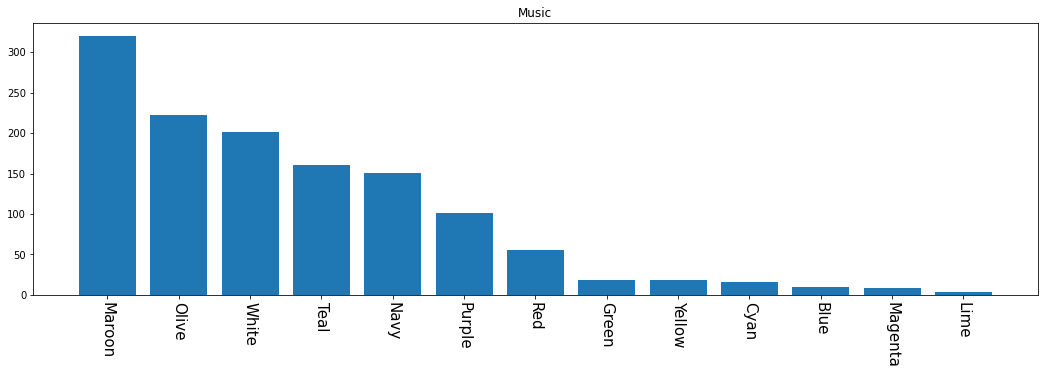

Category 'People & Blogs' Attr: 'colors' unique words: 12


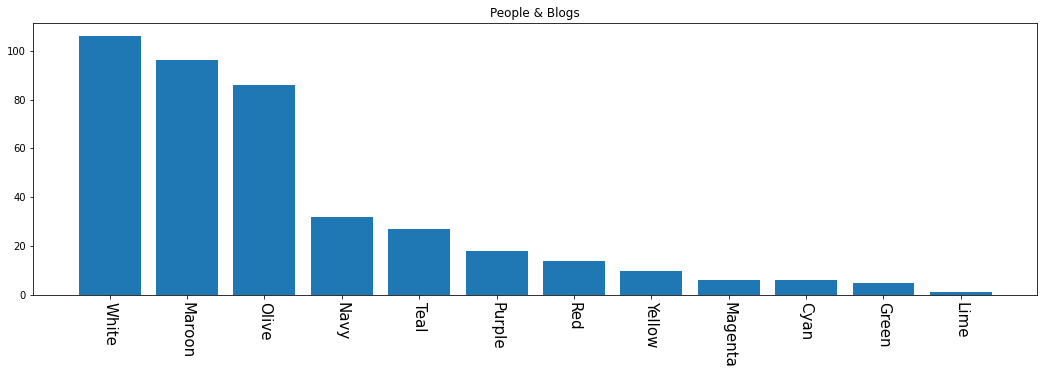

Category 'Howto & Style' Attr: 'colors' unique words: 13


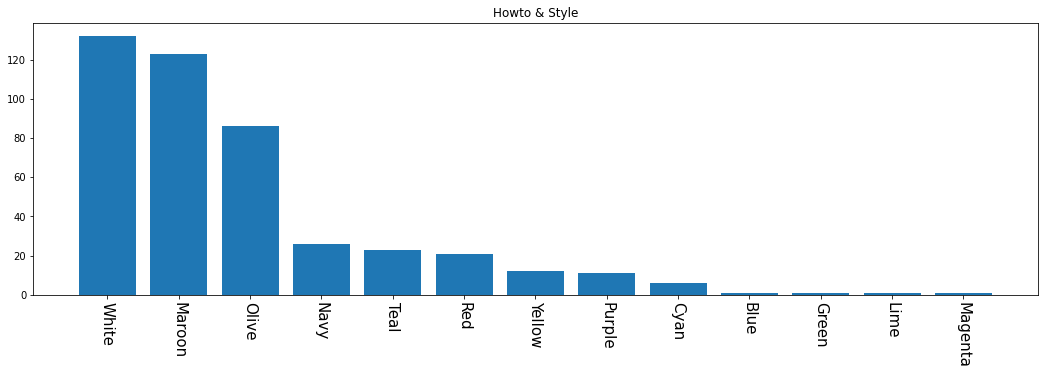

Category 'News & Politics' Attr: 'colors' unique words: 11


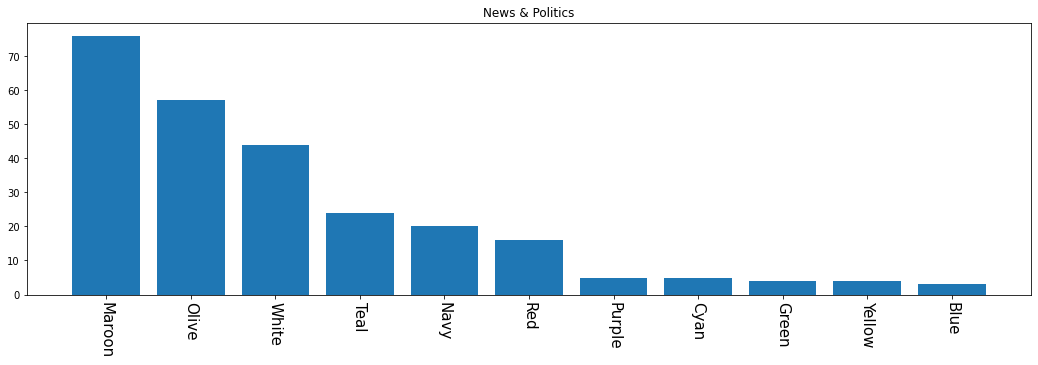

Category 'Comedy' Attr: 'colors' unique words: 13


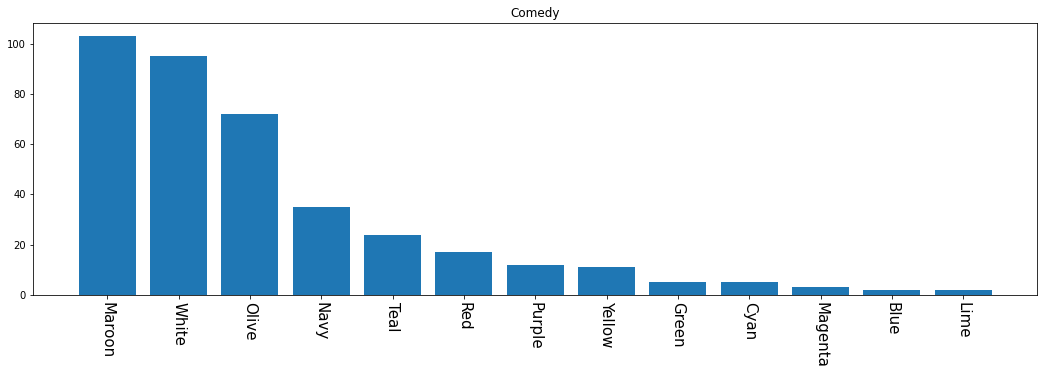

Category 'Sports' Attr: 'colors' unique words: 11


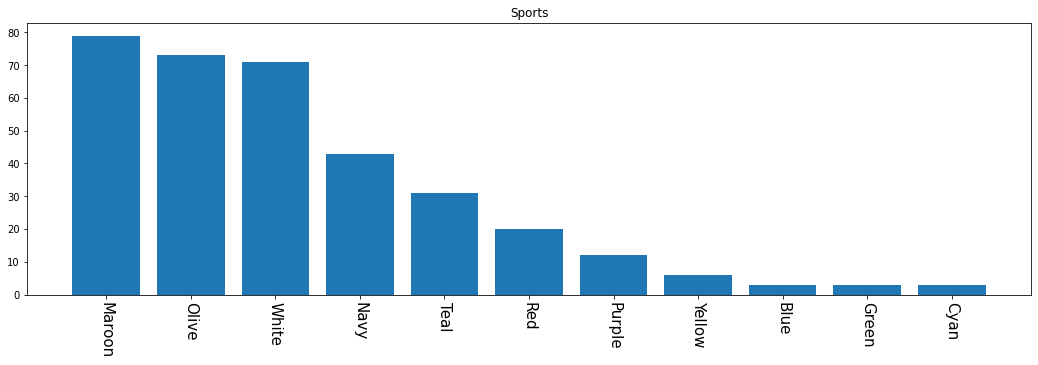

Category 'Travel & Events' Attr: 'colors' unique words: 6


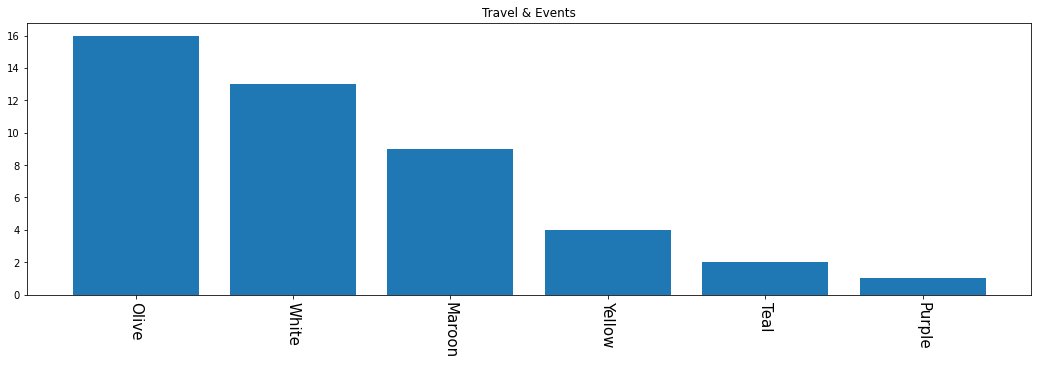

Category 'Gaming' Attr: 'colors' unique words: 11


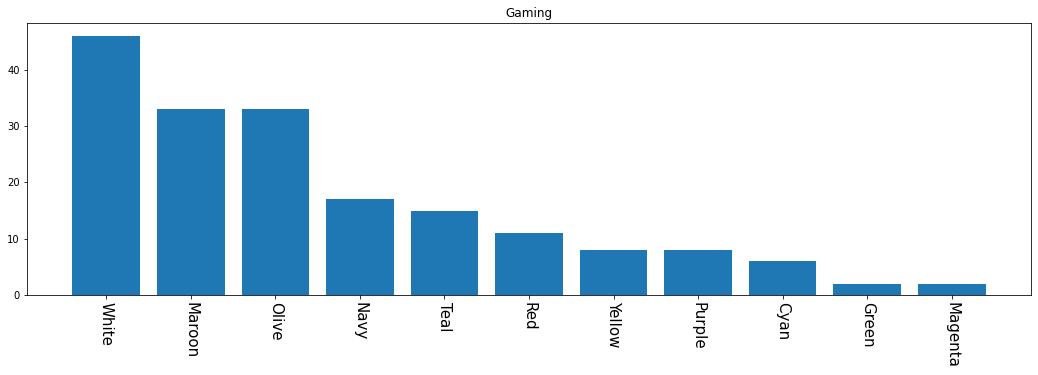

Category 'Education' Attr: 'colors' unique words: 13


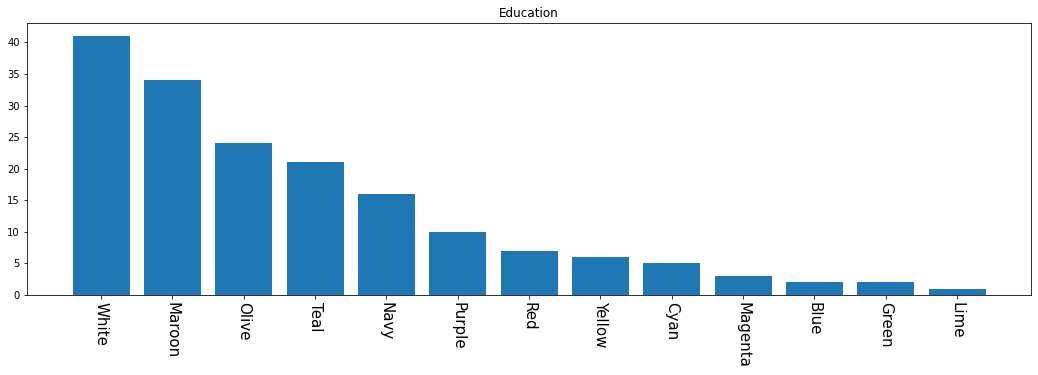

Category 'Pets & Animals' Attr: 'colors' unique words: 11


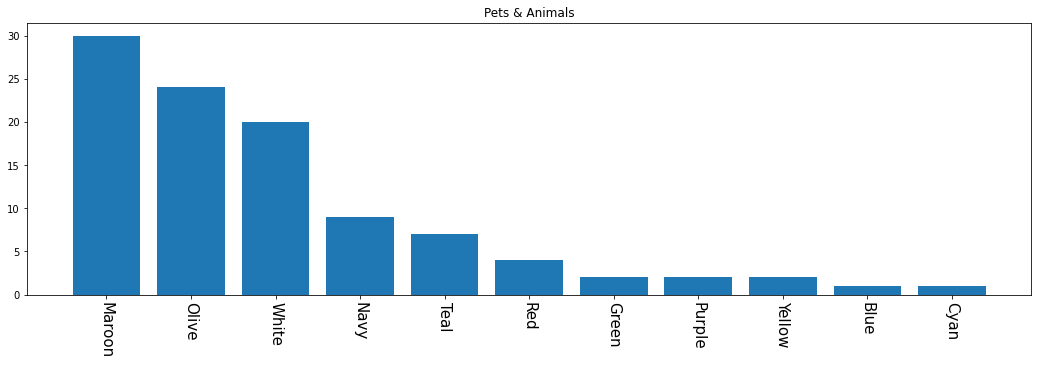

Category 'Science & Technology' Attr: 'colors' unique words: 11


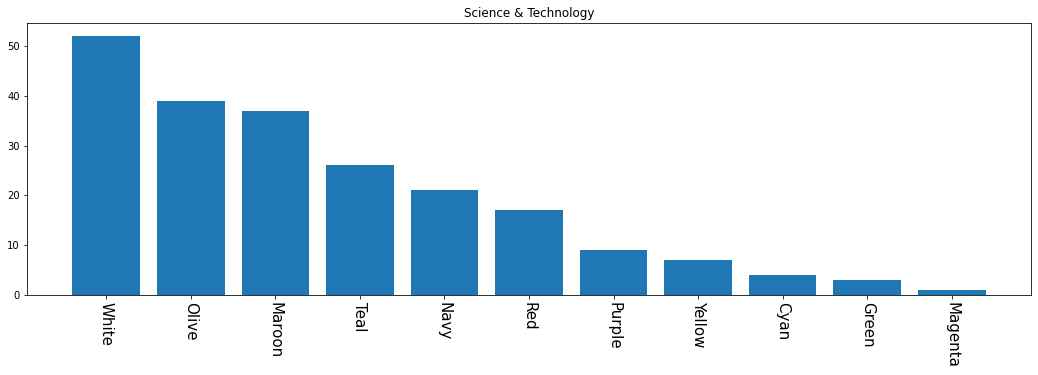

Category 'Film & Animation' Attr: 'colors' unique words: 11


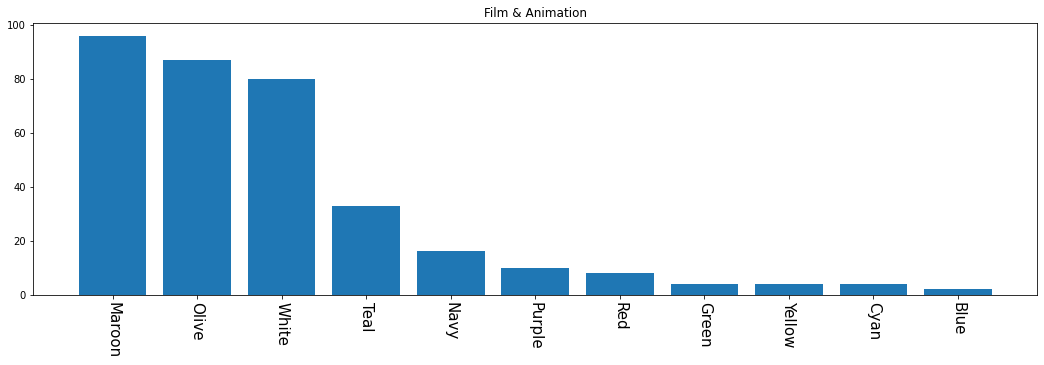

Category 'Autos & Vehicles' Attr: 'colors' unique words: 8


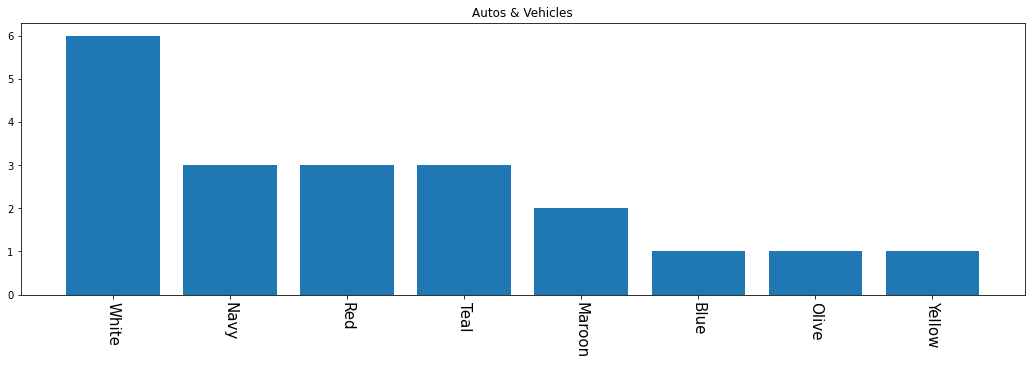

Category 'Nonprofits & Activism' Attr: 'colors' unique words: 7


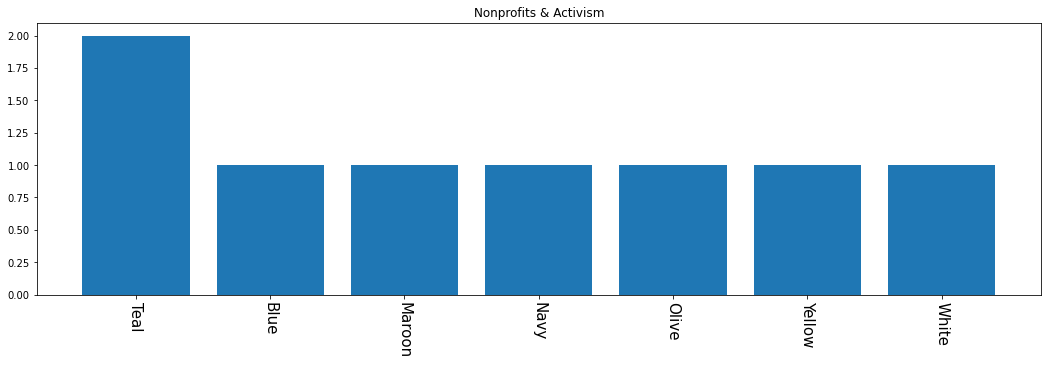

Category 'Shows' Attr: 'colors' unique words: 2


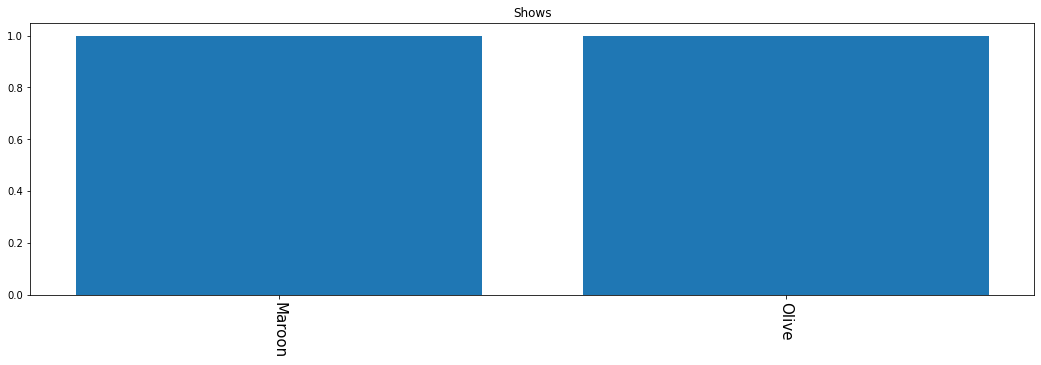

In [169]:
def tokenize_colors(x):
    x = eval(x)
    color_names = list(map(lambda l: l[0][1], x))
    return color_names

videos["tokenized_colors"] = videos["cropped_colors"].apply(lambda x: tokenize_colors(x))
plot_categories_bars(categories, "colors", create_tokens_dict=False, n_tokens=5)

Zapisanie słownika z najczęstszymi *n* tokenami występującymi na poszczególnych atrybutach
z podziałem na kategorie.

In [159]:
print(most_frequent_tokens)
save_frequent_tokens_dict("categories", most_frequent_tokens)

{'channel_titles': {'Entertainment': ['live', 'late', 'entertain', 'show', 'pictur', 'netflix', 'night', 'saturday', 'jame', 'good', 'morn', 'power', 'theellenshow', 'corden', '105.1', 'e', 'kimmel', 'star', 'breakfast', 'fm'], 'Music': ['music', 'radio', '1', 'marshmello', 'ibighit', 'record', 'bbc', 'smtown', 'offici', 'charli', 'puth', 'bbcradio1vevo', 'huang', 'ptxoffici', 'entertain', 'janell', 'mone', '1thek', 'andrew', 'chainsmokersvevo'], 'People & Blogs': ['caseyneistat', 'buzzfeedvideo', 'safiya', 'nygaard', 'grace', 'channel90second', 'madelain', 'newscom', 'petsch', 'as/i', 'primit', 'guy', 'luci', 'helbig', 'ijustin', 'big', 'morezoella', 'mo', 'moon', 'stori'], 'Howto & Style': ['feast', 'sprinkleofglitt', 'first', 'fleur', 'deforc', 'tasti', 'inthefrow', 'laura', 'bright', 'cake', 'patricia', 'nikkietutori', 'zoella', 'wish', 'ell', 'holm', 'jacki', 'burr', 'tanya', 'food'], 'News & Politics': ['news', 'cnn', 'today', 'cbs', 'abc', 'insid', 'vox', 'bbc', 'washington', 'p

## Utworzenie atrybutów

In [160]:
def count_tokens(tokens: List[str], attribute: str, category: str) -> float:
    frequent_tokens = most_frequent_tokens[attribute][category]
    if len(tokens) == 0 or len(frequent_tokens) == 0:
        return 0.0
    s = 0
    for t in frequent_tokens:
        if t in tokens:
            s += 1
    return s / len(frequent_tokens)

tokenized_attrs.append("tags")
for attr in tokenized_attrs:
    print(attr)
    for cat in categories:
        videos[f"freq_{attr}_{cat}"] = videos[f"tokenized_{attr}"].apply(lambda x: count_tokens(x, attr, cat))
videos.columns
# videos[f"freq_channel_titles_{categories[0]}"].

channel_titles
descriptions
ocr_text
titles
domains
filtered_ocr_text
tags


Index(['new_video_id', 'Unnamed: 0.1', 'video_id', 'trending_date', 'title',
       'channel_title', 'category_id', 'publish_time', 'tags', 'views',
       ...
       'freq_tags_Sports', 'freq_tags_Travel & Events', 'freq_tags_Gaming',
       'freq_tags_Education', 'freq_tags_Pets & Animals',
       'freq_tags_Science & Technology', 'freq_tags_Film & Animation',
       'freq_tags_Autos & Vehicles', 'freq_tags_Nonprofits & Activism',
       'freq_tags_Shows'],
      dtype='object', length=155)

### Poprawione kolory

**Wielka brytania**

In [161]:
from imgprocessing.colors_extractor import tuple_to_hex
from imgprocessing.colors import get_basic_colors_dict

eval_columns = ["cropped_colors"]

for df in [gb_images, us_images]:
    for c in eval_columns:
        df[c] = df[c].apply(lambda x: eval(x))

basic_colors_dict = get_basic_colors_dict()

gb_colors = gb_images.explode("cropped_colors")
gb_colors["color"] = gb_colors["cropped_colors"].apply(lambda x: x if isinstance(x, float) else str(x[0][0]))
gb_colors["color_counts"] = gb_colors["cropped_colors"].apply(lambda x: x if isinstance(x, float) else x[1])

gb_colors = gb_colors["color"].apply(pd.Series, 1).stack()
print(gb_colors.head())
gb_colors.index = gb_colors.index.droplevel(-1)
gb_colors.name = "color"

gb_colors = gb_colors.to_frame()
unique_gb_colors = gb_colors["color"].value_counts() #
unique_gb_colors = unique_gb_colors.rename_axis("color").reset_index(name="count")
unique_gb_colors.describe()

1  0    (128, 128, 128)
   0    (192, 192, 192)
   0      (128, 128, 0)
   0        (128, 0, 0)
   0          (0, 0, 0)
dtype: object


count
count    16.000000
mean    776.875000
std     866.669324
min      10.000000
25%      69.500000
50%     397.000000
75%    1253.250000
max    2425.000000

              color  count
0   (128, 128, 128)   2425
1         (0, 0, 0)   2267
2   (192, 192, 192)   2109
3       (128, 0, 0)   1473
4   (255, 255, 255)   1180
5     (128, 128, 0)   1079
6     (0, 128, 128)    546
7       (0, 0, 128)    534
8     (128, 0, 128)    260
9       (255, 0, 0)    215
10    (255, 255, 0)    145
11      (0, 128, 0)     70
12    (0, 255, 255)     68
13      (0, 0, 255)     34
14    (255, 0, 255)     15
15      (0, 255, 0)     10


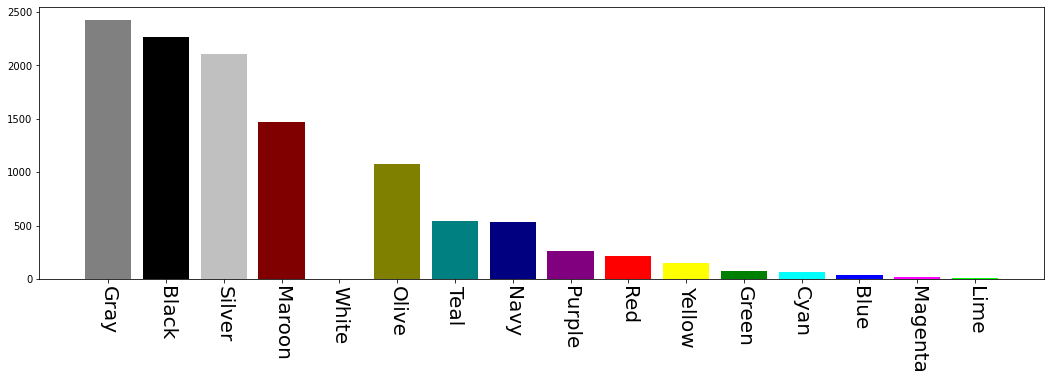

In [162]:
print(unique_gb_colors)
plt.subplots(figsize=(18,5))
colors = [tuple_to_hex(eval(c)) for c in unique_gb_colors.head(50)["color"]]
ticks = [basic_colors_dict[eval(c)] for c in unique_gb_colors.head(50)["color"]]
plt.bar(np.arange(len(colors)), unique_gb_colors.head(50)["count"], color=colors)
plt.xticks(np.arange(len(colors)), ticks, rotation=270, fontsize=20)
plt.show()

**Stany Zjednoczone**

In [163]:
us_colors = us_images.explode("cropped_colors")
us_colors["color"] = us_colors["cropped_colors"].apply(lambda x: x if isinstance(x, float) else str(x[0][0]))
us_colors["color_counts"] = us_colors["cropped_colors"].apply(lambda x: x if isinstance(x, float) else x[1])

us_colors = us_colors["color"].apply(pd.Series, 1).stack()
print(us_colors.head())
us_colors.index = us_colors.index.droplevel(-1)
us_colors.name = "color"

us_colors = us_colors.to_frame()
unique_us_colors = us_colors["color"].value_counts()
unique_us_colors = unique_us_colors.rename_axis("color").reset_index(name="count")
unique_us_colors.describe()

0  0    (192, 192, 192)
   0    (128, 128, 128)
   0          (0, 0, 0)
   0    (255, 255, 255)
   0        (128, 0, 0)
dtype: object


count
count    16.000000
mean   1591.875000
std    1778.588724
min      18.000000
25%     170.000000
50%     731.000000
75%    2679.000000
max    4960.000000

              color  count
0   (128, 128, 128)   4960
1         (0, 0, 0)   4527
2   (192, 192, 192)   4459
3       (128, 0, 0)   2841
4   (255, 255, 255)   2625
5     (128, 128, 0)   2353
6       (0, 0, 128)    980
7     (0, 128, 128)    952
8       (255, 0, 0)    510
9     (128, 0, 128)    469
10    (255, 255, 0)    335
11    (0, 255, 255)    178
12      (0, 128, 0)    146
13      (0, 0, 255)     63
14    (255, 0, 255)     54
15      (0, 255, 0)     18


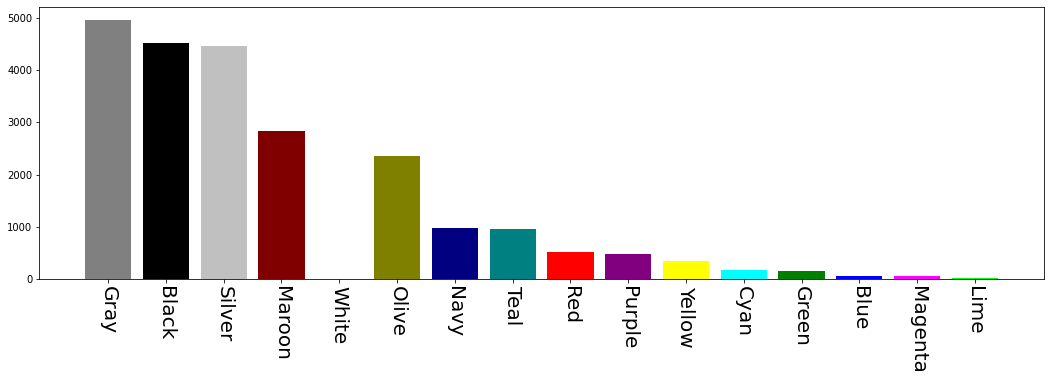

In [164]:
print(unique_us_colors)
plt.subplots(figsize=(18,5))
colors = [tuple_to_hex(eval(c)) for c in unique_us_colors.head(50)["color"]]
ticks = [basic_colors_dict[eval(c)] for c in unique_us_colors.head(50)["color"]]
plt.bar(np.arange(len(colors)), unique_us_colors.head(50)["count"], color=colors)
plt.xticks(np.arange(len(colors)), ticks, rotation=270, fontsize=20)
plt.show()

**Razem**

In [165]:
colors = pd.concat([gb_images, us_images])

all_colors = colors.explode("cropped_colors")
all_colors["color"] = all_colors["cropped_colors"].apply(lambda x: x if isinstance(x, float) else str(x[0][0]))
all_colors["color_counts"] = all_colors["cropped_colors"].apply(lambda x: x if isinstance(x, float) else x[1])

all_colors = all_colors["color"].apply(pd.Series, 1).stack()
print(all_colors.head())
all_colors.index = all_colors.index.droplevel(-1)
all_colors.name = "color"

all_colors = all_colors.to_frame()
unique_all_colors = all_colors["color"].value_counts() #
unique_all_colors = unique_all_colors.rename_axis("color").reset_index(name="count")
unique_all_colors.describe()

1  0    (128, 128, 128)
   0    (192, 192, 192)
   0      (128, 128, 0)
   0        (128, 0, 0)
   0          (0, 0, 0)
dtype: object


count
count    16.000000
mean   2368.750000
std    2644.146958
min      28.000000
25%     238.500000
50%    1113.500000
75%    3932.250000
max    7385.000000

              color  count
0   (128, 128, 128)   7385
1         (0, 0, 0)   6794
2   (192, 192, 192)   6568
3       (128, 0, 0)   4314
4   (255, 255, 255)   3805
5     (128, 128, 0)   3432
6       (0, 0, 128)   1514
7     (0, 128, 128)   1498
8     (128, 0, 128)    729
9       (255, 0, 0)    725
10    (255, 255, 0)    480
11    (0, 255, 255)    246
12      (0, 128, 0)    216
13      (0, 0, 255)     97
14    (255, 0, 255)     69
15      (0, 255, 0)     28


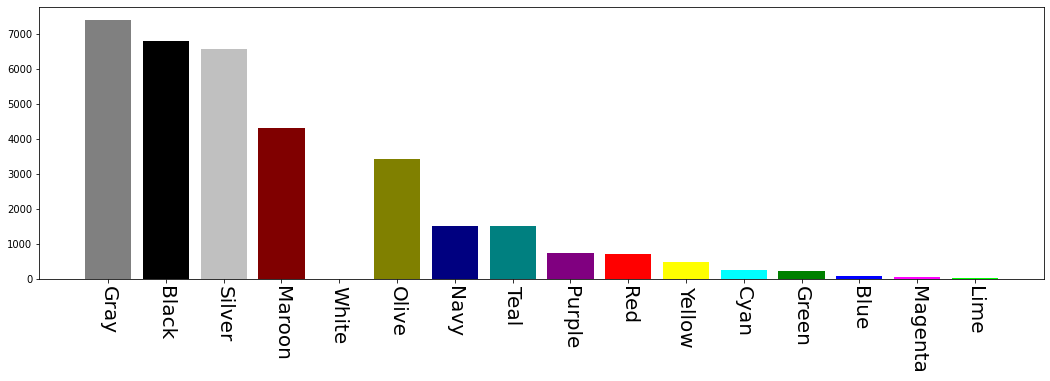

In [166]:
print(unique_all_colors)
plt.subplots(figsize=(18,5))
colors = [tuple_to_hex(eval(c)) for c in unique_all_colors.head(50)["color"]]
ticks = [basic_colors_dict[eval(c)] for c in unique_all_colors.head(50)["color"]]
plt.bar(np.arange(len(colors)), unique_all_colors.head(50)["count"], color=colors)
plt.xticks(np.arange(len(colors)), ticks, rotation=270, fontsize=20)
plt.show()


Zapianie danych z utworzonymi atrybutami

In [167]:
gb_data = videos.head(len(gb))
us_data = videos.tail(len(us))

save_csv("ped3_data", [gb_data, us_data], ["GB_videos_5p", "US_videos_5p"])

